In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = 100*loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 40000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = abs_residual + chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)






Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   1%|          | 3/400 [00:00<00:13, 29.15it/s]


Adam:   7%|▋         | 28/400 [00:00<00:02, 155.67it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 182.54it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 202.47it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 221.30it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 228.63it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 229.67it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 235.59it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 235.99it/s]


Adam:  56%|█████▌    | 223/400 [00:01<00:00, 238.06it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 234.42it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 237.56it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 239.46it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 239.78it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 240.49it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 242.20it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 244.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.72it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.97it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.95it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 245.73it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 246.06it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 246.88it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.00it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 242.77it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 242.59it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 243.59it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 243.95it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 235.20it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 238.10it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 239.48it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 241.93it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 236.80it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 250.33it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 242.35it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 237.54it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 243.86it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 246.24it/s]


Adam:  39%|███▉      | 155/400 [00:00<00:00, 249.47it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 250.94it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 251.66it/s]


Adam:  58%|█████▊    | 233/400 [00:00<00:00, 251.48it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 250.82it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 250.29it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 250.13it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 247.74it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 248.48it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 241.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 238.48it/s]


Adam:  13%|█▎        | 51/400 [00:00<00:01, 245.45it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 247.00it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 247.91it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 248.62it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:00, 249.84it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:00, 245.70it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 246.58it/s]


Adam:  57%|█████▋    | 227/400 [00:00<00:00, 246.15it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 248.77it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 248.84it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 249.20it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 248.89it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 248.36it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 249.89it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 248.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 248.54it/s]


Adam:  13%|█▎        | 51/400 [00:00<00:01, 251.12it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 234.71it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 237.81it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 236.86it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:01, 242.11it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:00, 240.11it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 219.87it/s]


Adam:  57%|█████▋    | 227/400 [00:00<00:00, 228.28it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 235.59it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 240.50it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 244.24it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 242.93it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 245.08it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 247.14it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.45it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.59it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.74it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.51it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.91it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 244.04it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 243.96it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 243.30it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 242.61it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 235.18it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 238.48it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 239.73it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 239.90it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 242.20it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 242.76it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 245.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.28it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.11it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.04it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 243.63it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.32it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 244.48it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.09it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 239.89it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 240.25it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.44it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.44it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 242.98it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 245.43it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 247.40it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 246.50it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 246.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.63it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 241.24it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 243.67it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 242.38it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 246.46it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 246.70it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 247.72it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 248.17it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 248.69it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 248.45it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 247.22it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 248.59it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 247.21it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 244.66it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 241.96it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 245.38it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   4%|▍         | 16/400 [00:00<00:02, 151.52it/s]


Adam:  10%|█         | 40/400 [00:00<00:01, 198.09it/s]


Adam:  16%|█▋        | 65/400 [00:00<00:01, 220.30it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 226.13it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 236.22it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 241.49it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:00, 239.00it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 242.22it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 244.19it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 246.86it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 248.39it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 244.64it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 244.31it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 241.46it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 245.69it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 247.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.24it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 252.52it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 251.68it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 249.69it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 249.67it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 249.50it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:01, 246.85it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 244.75it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 247.04it/s]


Adam:  57%|█████▋    | 229/400 [00:00<00:00, 238.53it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 235.64it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 235.93it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 239.10it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 243.01it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 240.63it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 244.06it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.91it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.51it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 246.77it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 244.82it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 244.78it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 240.91it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 241.14it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 228.85it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 233.45it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 234.49it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 233.19it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 237.05it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 223.51it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 229.30it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 233.39it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 237.38it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.79it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.84it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.43it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.30it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.00it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 243.15it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 242.46it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 242.03it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.80it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.90it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 243.99it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 244.67it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 245.99it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 238.96it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 241.99it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 242.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.30it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.40it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.55it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 239.15it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 240.78it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 242.87it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 242.92it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 236.34it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 240.71it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 243.44it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 244.52it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 239.73it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 240.44it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 242.49it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 244.33it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 242.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.79it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.97it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.59it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.62it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.68it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.46it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 239.84it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 243.33it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 246.86it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 247.78it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 248.29it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 245.20it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 244.99it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 245.92it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 243.55it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 240.84it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 230.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.86it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 248.14it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 249.18it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 242.53it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 243.18it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 243.91it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:00, 246.15it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 241.62it/s]


Adam:  57%|█████▋    | 227/400 [00:00<00:00, 240.96it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 240.19it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 242.89it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 245.17it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 245.74it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 243.27it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 244.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.12it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.15it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 240.56it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 246.07it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 247.84it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 248.44it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 247.91it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 248.30it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 248.18it/s]


Adam:  57%|█████▋    | 227/400 [00:00<00:00, 249.35it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 248.73it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 247.58it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 245.21it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 245.29it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 245.79it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 247.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.96it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.30it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.66it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 249.81it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 246.97it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 247.85it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:00, 249.06it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 250.44it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 251.64it/s]


Adam:  57%|█████▊    | 230/400 [00:00<00:00, 251.93it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 250.51it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 251.07it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 251.51it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 250.94it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 249.79it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 241.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 248.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 248.70it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 232.80it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 234.55it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 239.80it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 242.29it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 244.35it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 240.71it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 241.80it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 226.63it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 232.37it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 227.14it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 231.54it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 235.49it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 238.27it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 236.48it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 241.18it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.14it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.52it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 242.22it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 245.45it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 239.52it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 232.09it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 232.69it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 236.09it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 233.31it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 231.24it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 237.73it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 237.63it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 236.81it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 235.96it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 240.46it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 244.47it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 244.40it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 251.07it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 249.07it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 249.97it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 251.91it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 252.49it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:00, 253.14it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 252.24it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 250.23it/s]


Adam:  58%|█████▊    | 234/400 [00:00<00:00, 245.78it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 243.24it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 244.58it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 234.34it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 239.88it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 241.84it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 243.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 245.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.75it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.84it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 234.50it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 235.01it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 232.76it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.25it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.17it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.97it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 238.64it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 243.80it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 245.29it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 247.11it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 248.42it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 247.64it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 246.36it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 239.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.12it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.66it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.73it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 248.35it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 250.62it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 251.14it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:01, 245.00it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 243.33it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 240.78it/s]


Adam:  57%|█████▊    | 230/400 [00:00<00:00, 245.05it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 247.77it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 249.13it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 246.40it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 244.01it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 246.67it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 248.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.77it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.54it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 237.63it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 244.38it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 245.52it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 246.59it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 247.32it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 247.47it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 247.45it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 246.63it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 247.04it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 247.47it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 246.40it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 245.90it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 244.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 245.30it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.52it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.31it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 244.07it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 245.47it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 244.98it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 245.15it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 246.06it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 246.83it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.24it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.78it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 242.19it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 231.34it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 235.91it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 238.97it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 243.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 242.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 254.35it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 253.14it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 246.85it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 249.82it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 251.58it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:00, 252.36it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 253.04it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 251.20it/s]


Adam:  58%|█████▊    | 234/400 [00:00<00:00, 251.03it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 250.78it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 248.07it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 248.60it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 243.78it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 243.72it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 242.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 251.72it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 243.05it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 243.83it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 237.97it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 240.50it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:01, 240.67it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:00, 243.03it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 242.21it/s]


Adam:  57%|█████▋    | 228/400 [00:00<00:00, 245.16it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 247.68it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 242.35it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 243.58it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 243.49it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 245.27it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 246.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 250.43it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 251.87it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 243.64it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 247.68it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 246.48it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:00, 247.62it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 248.28it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 249.60it/s]


Adam:  58%|█████▊    | 231/400 [00:00<00:00, 250.93it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 246.28it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 246.93it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 246.57it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 246.18it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 246.42it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 247.38it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.76it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 242.03it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 240.05it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 242.01it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 242.74it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 244.54it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 246.43it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 247.52it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 246.95it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 246.88it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 248.38it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 247.00it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 246.20it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 246.63it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 248.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 253.56it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 253.52it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 251.58it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 250.90it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 249.03it/s]


Adam:  39%|███▉      | 155/400 [00:00<00:00, 247.08it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 246.06it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 243.80it/s]


Adam:  57%|█████▊    | 230/400 [00:00<00:00, 245.32it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 246.31it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 247.62it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 248.88it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 249.56it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 249.21it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 248.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 248.23it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.14it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.94it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 232.68it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 231.07it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 238.16it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 242.99it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:00, 245.46it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 246.27it/s]


Adam:  57%|█████▋    | 227/400 [00:00<00:00, 247.40it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 247.17it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 245.24it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 235.80it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 239.64it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 235.94it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 240.64it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 250.89it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 250.29it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 248.98it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 248.97it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 247.39it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:00, 247.53it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 248.05it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 246.97it/s]


Adam:  57%|█████▋    | 229/400 [00:00<00:00, 246.92it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 247.97it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 247.68it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 245.34it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 244.62it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 241.78it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 242.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 250.30it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 246.02it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 241.83it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 239.42it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 244.07it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:01, 245.20it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 246.98it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 247.58it/s]


Adam:  57%|█████▊    | 230/400 [00:00<00:00, 248.82it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 243.94it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 246.99it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 248.88it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 250.31it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 224.74it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 203.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.45it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.87it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 247.34it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 248.70it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 248.56it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 248.53it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:00, 248.97it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 248.93it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 248.61it/s]


Adam:  57%|█████▋    | 228/400 [00:00<00:00, 248.54it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 249.98it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 244.09it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 246.88it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 248.29it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 249.83it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 248.43it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 248.33it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 253.28it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 251.47it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 249.16it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 247.84it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 246.50it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:00, 248.28it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 249.47it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 248.74it/s]


Adam:  57%|█████▊    | 230/400 [00:00<00:00, 241.45it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 238.87it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 242.32it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 245.54it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 247.68it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 249.18it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 250.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.29it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.10it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 245.27it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 247.65it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 246.39it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 234.59it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 235.52it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 231.25it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 225.19it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 231.71it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 231.90it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 236.03it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 237.00it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 239.75it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 240.80it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 242.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.01it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 248.10it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.57it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 234.07it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 231.46it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.66it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 234.06it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 239.04it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 241.82it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 243.72it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 233.95it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 238.29it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 240.79it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 240.01it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 242.34it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 245.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.31it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.53it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 240.67it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 243.01it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 243.51it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 243.90it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 245.09it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 247.12it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 248.69it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 244.69it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.43it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 241.59it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 232.44it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 236.70it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 212.35it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 216.67it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 224.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 248.97it/s]


Adam:  13%|█▎        | 51/400 [00:00<00:01, 250.43it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 247.77it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 228.50it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 236.24it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:01, 241.42it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 243.85it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 244.44it/s]


Adam:  57%|█████▋    | 229/400 [00:00<00:00, 237.51it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 219.58it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 223.79it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 225.28it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 230.73it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 229.74it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 233.93it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 235.61it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.11it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 233.80it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 231.24it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 238.21it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 242.30it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 244.13it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 245.46it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 245.61it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 241.05it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 244.47it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 244.07it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 243.09it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 244.70it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 247.34it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 249.20it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.57it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 253.07it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 252.12it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 245.73it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 247.61it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 246.97it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:00, 246.47it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 246.82it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 249.12it/s]


Adam:  58%|█████▊    | 231/400 [00:00<00:00, 250.32it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 251.07it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 252.03it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 252.77it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 252.87it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 252.83it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 250.75it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 250.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 251.26it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 251.11it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 251.05it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 251.04it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 221.43it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:01, 218.26it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:01, 222.74it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 223.35it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 230.55it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 236.04it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 240.02it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 242.72it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 223.39it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 226.69it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 228.79it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 230.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.00it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.75it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 236.22it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 240.14it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 243.77it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 246.26it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 246.68it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 246.13it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 237.23it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 236.35it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 239.74it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 243.67it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 245.69it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 247.31it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 241.33it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 218.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 251.29it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 248.54it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 241.34it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 238.66it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 242.88it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:01, 244.75it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 239.47it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 239.63it/s]


Adam:  57%|█████▋    | 228/400 [00:00<00:00, 242.07it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 242.03it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 240.35it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 238.08it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 235.13it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 236.07it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 236.73it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.23it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 248.27it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 238.32it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.37it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 241.89it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 241.81it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 243.50it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 240.87it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 227.36it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 220.40it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 191.42it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 185.90it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 190.68it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 188.82it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 192.54it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 205.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 216.16it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.63it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 244.57it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 246.63it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 244.06it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 246.28it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 247.87it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:00, 249.75it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 251.07it/s]


Adam:  57%|█████▋    | 229/400 [00:00<00:00, 249.26it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 250.31it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 249.18it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 248.99it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 250.41it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 251.59it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 252.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 249.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 248.36it/s]


Adam:  13%|█▎        | 51/400 [00:00<00:01, 250.38it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 249.63it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 250.02it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 250.03it/s]


Adam:  39%|███▉      | 155/400 [00:00<00:00, 250.68it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 251.06it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 251.30it/s]


Adam:  58%|█████▊    | 233/400 [00:00<00:00, 251.02it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 251.76it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 251.54it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 245.58it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 242.56it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 241.05it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 241.44it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.92it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.97it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.99it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 248.72it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 249.42it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 249.25it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:00, 249.99it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 250.11it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 250.85it/s]


Adam:  58%|█████▊    | 231/400 [00:00<00:00, 250.97it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 249.70it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 249.40it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 250.64it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 251.16it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 251.06it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 251.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 250.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 248.73it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 247.71it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 247.99it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 249.32it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 251.00it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:00, 251.70it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 252.25it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 252.46it/s]


Adam:  58%|█████▊    | 231/400 [00:00<00:00, 252.59it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 252.28it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 250.52it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 248.52it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 247.38it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 246.65it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 245.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 248.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.25it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.59it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 248.13it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 247.79it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 237.76it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:01, 242.15it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 244.77it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 246.57it/s]


Adam:  57%|█████▋    | 229/400 [00:00<00:00, 247.20it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 247.72it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 236.45it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 237.91it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 239.54it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 240.23it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 241.13it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 242.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.99it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.44it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 240.88it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 242.20it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 243.13it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 243.05it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 245.42it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 246.98it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 248.13it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 249.23it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 247.36it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 248.63it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 249.36it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 249.85it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 249.92it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.44it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.30it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 243.52it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 246.37it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 247.38it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 248.20it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:00, 249.26it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 247.65it/s]


Adam:  57%|█████▋    | 228/400 [00:00<00:00, 249.43it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 250.04it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 249.95it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 250.59it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 251.21it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 251.63it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 251.30it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 249.18it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 251.38it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 250.87it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 251.11it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 250.00it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 249.16it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:00, 249.83it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 245.42it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 246.08it/s]


Adam:  58%|█████▊    | 231/400 [00:00<00:00, 246.71it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 246.53it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 248.42it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 241.07it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 242.93it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 243.86it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 242.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 245.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.78it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.94it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.48it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 243.89it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 244.99it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 247.09it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 244.29it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 242.82it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 238.63it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 238.79it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 228.46it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 234.95it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 238.49it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 236.50it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 238.30it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 231.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.19it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 217.98it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 219.93it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 231.43it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 238.33it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 242.18it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 244.40it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 237.70it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 239.51it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 239.45it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 240.60it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 242.00it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 243.05it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 222.92it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 226.38it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 231.48it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 230.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.57it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.57it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 233.57it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 235.57it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 239.37it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.17it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.64it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.34it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.96it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 239.33it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 241.55it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 242.91it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 238.89it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 241.05it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 243.44it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 244.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 250.95it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 249.56it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 246.29it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 241.27it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 242.90it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:01, 243.87it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:00, 236.34it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 239.15it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 234.22it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 234.37it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 238.54it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 241.43it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 243.11it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 244.42it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 243.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.31it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.72it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.55it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.93it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 234.63it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 240.42it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 240.47it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 234.63it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 227.99it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 233.77it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 238.30it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 241.18it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 242.74it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 244.46it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 245.36it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 245.67it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 245.33it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 245.98it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 212.85it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 221.30it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 224.76it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 223.61it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 232.61it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 231.85it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:00, 236.72it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 237.49it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 240.47it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 242.67it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 238.40it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 240.10it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 242.30it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 244.54it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 230.08it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 230.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 248.77it/s]


Adam:  13%|█▎        | 51/400 [00:00<00:01, 250.18it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 250.67it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 251.26it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 251.72it/s]


Adam:  39%|███▉      | 155/400 [00:00<00:00, 250.75it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 247.17it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 246.93it/s]


Adam:  58%|█████▊    | 231/400 [00:00<00:00, 246.19it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 247.97it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 248.30it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 248.44it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 249.49it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 243.64it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 224.14it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.20it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.47it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 235.37it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 241.68it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 233.50it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 239.12it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 241.41it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 244.54it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 245.40it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 246.65it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 245.82it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 245.51it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 246.35it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 247.75it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 248.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.38it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 232.59it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 229.91it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 225.36it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 227.71it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 227.23it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 227.19it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.85it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 236.40it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 238.41it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 235.15it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 233.65it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 237.59it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 236.99it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 231.87it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 225.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.82it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 233.33it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 234.26it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 234.25it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 239.10it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 241.89it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 238.10it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 233.29it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 222.75it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 226.23it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 230.77it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 235.86it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 239.38it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 236.74it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 231.60it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 231.29it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.72it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.35it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 219.17it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 223.11it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 233.09it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 237.32it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 235.83it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 232.04it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 236.98it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 239.28it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 241.70it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 242.87it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 239.63it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 241.60it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 243.62it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 244.90it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 244.67it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.60it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 194.33it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 224.44it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 233.01it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 238.46it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 239.07it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.99it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 239.87it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 243.26it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 244.10it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 245.40it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 245.44it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 246.44it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 246.15it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 216.58it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 220.99it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 227.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.29it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 249.54it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.99it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 208.61it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 219.21it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 227.22it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 232.82it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 238.04it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 237.10it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 227.71it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 221.46it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 224.07it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 227.52it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 229.60it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 212.93it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 213.95it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 218.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.91it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 248.08it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 248.19it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 249.18it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 250.67it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:00, 250.90it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 250.50it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 246.70it/s]


Adam:  57%|█████▊    | 230/400 [00:00<00:00, 244.59it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 242.83it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 243.09it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 244.12it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 244.04it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 244.37it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 244.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 245.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 196.23it/s]


Adam:  10%|█         | 40/400 [00:00<00:01, 182.29it/s]


Adam:  15%|█▍        | 59/400 [00:00<00:01, 177.35it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:02, 156.83it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 182.02it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 199.30it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 206.54it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:01, 219.26it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 227.02it/s]


Adam:  56%|█████▌    | 223/400 [00:01<00:00, 232.08it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 234.31it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 237.01it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 232.43it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 233.44it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 237.04it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 227.72it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 230.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 217.63it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.25it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 225.00it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 226.65it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.00it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.17it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 239.53it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 231.63it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 235.84it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 237.55it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 236.76it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 236.16it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 238.20it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 230.25it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 235.85it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 238.83it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 240.47it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.30it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 252.97it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 252.80it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 250.25it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 250.84it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 251.72it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:00, 249.05it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 250.48it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 238.26it/s]


Adam:  58%|█████▊    | 234/400 [00:00<00:00, 243.14it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 245.89it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 247.25it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 246.83it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 248.45it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 247.44it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 248.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 251.69it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 239.09it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 241.01it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 243.16it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 244.65it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:01, 245.54it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:00, 245.73it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 240.61it/s]


Adam:  57%|█████▋    | 227/400 [00:00<00:00, 236.13it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 234.81it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 238.94it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 241.47it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 242.92it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 237.69it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 241.69it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.37it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.12it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 241.41it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 241.84it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 244.08it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 241.14it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 234.54it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 238.03it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 240.40it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 242.08it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 242.65it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 243.59it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 243.88it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 239.16it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 235.81it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 239.79it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   4%|▍         | 18/400 [00:00<00:02, 173.72it/s]


Adam:  10%|▉         | 38/400 [00:00<00:01, 186.63it/s]


Adam:  15%|█▌        | 60/400 [00:00<00:01, 198.26it/s]


Adam:  21%|██▏       | 85/400 [00:00<00:01, 217.12it/s]


Adam:  27%|██▋       | 107/400 [00:00<00:01, 195.29it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 192.95it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 206.71it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:01, 219.40it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 226.03it/s]


Adam:  56%|█████▋    | 226/400 [00:01<00:00, 231.35it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 230.46it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 236.14it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 239.45it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 241.47it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 244.30it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 245.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.56it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 249.83it/s]


Adam:  13%|█▎        | 51/400 [00:00<00:01, 249.80it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 248.57it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 249.33it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 249.54it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:00, 249.93it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 250.71it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 251.40it/s]


Adam:  58%|█████▊    | 231/400 [00:00<00:00, 244.68it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 246.53it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 241.86it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 244.76it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 247.20it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 249.10it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 249.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 248.25it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 252.86it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 252.43it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 251.65it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 251.92it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 249.81it/s]


Adam:  39%|███▉      | 155/400 [00:00<00:00, 249.84it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 249.43it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 250.46it/s]


Adam:  58%|█████▊    | 232/400 [00:00<00:00, 250.85it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 251.23it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 250.91it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 250.83it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 248.73it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 249.57it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 249.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 250.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.47it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 247.28it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.70it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 244.79it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 247.16it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:00, 248.88it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 247.98it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 243.88it/s]


Adam:  57%|█████▋    | 228/400 [00:00<00:00, 245.64it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 247.76it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 249.10it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 250.40it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 251.14it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 249.51it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 249.89it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.96it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.43it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 234.46it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 233.81it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 218.92it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 228.00it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 227.67it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.79it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 237.83it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 242.38it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 245.66it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 246.49it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 247.86it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 249.49it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 250.66it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 251.03it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 250.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.75it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.82it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 247.47it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 245.80it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 198.52it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 211.24it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 215.91it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:01, 222.83it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:01, 205.37it/s]


Adam:  55%|█████▍    | 218/400 [00:01<00:00, 213.37it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 210.00it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 215.22it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 225.73it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 225.71it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 227.93it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 230.35it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 235.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.16it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.91it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.71it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 244.68it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.12it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 244.95it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 245.11it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 241.78it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 245.13it/s]


Adam:  57%|█████▋    | 228/400 [00:00<00:00, 247.18it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 248.35it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 247.99it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 249.05it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 249.94it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 249.88it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 249.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.12it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.50it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.92it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 248.50it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 251.10it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 252.42it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:00, 252.70it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 252.37it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 252.22it/s]


Adam:  58%|█████▊    | 232/400 [00:00<00:00, 251.13it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 249.65it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 248.58it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 247.55it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 247.92it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 247.95it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 248.94it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 249.29it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.04it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.64it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 241.92it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 240.48it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 243.52it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 245.46it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 247.38it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 247.36it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 247.32it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 248.00it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 247.17it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 247.01it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 247.01it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 246.47it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 244.56it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.10it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.91it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 250.77it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 248.43it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 247.94it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 241.43it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 244.66it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:01, 246.21it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 245.59it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 241.51it/s]


Adam:  57%|█████▋    | 229/400 [00:00<00:00, 244.30it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 245.65it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 247.03it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 247.80it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 248.27it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 248.70it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 248.89it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.61it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.15it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.08it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 245.74it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 247.36it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:00, 248.18it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 248.86it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 248.54it/s]


Adam:  57%|█████▊    | 230/400 [00:00<00:00, 249.68it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 250.18it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 249.92it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 250.74it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 250.90it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 251.19it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 251.77it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 249.16it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 252.03it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 250.96it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 251.46it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 250.57it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 247.70it/s]


Adam:  39%|███▉      | 155/400 [00:00<00:01, 241.46it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 239.83it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 242.10it/s]


Adam:  57%|█████▊    | 230/400 [00:00<00:00, 244.13it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 244.42it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 246.48it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 248.18it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 248.70it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 249.32it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 249.30it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.20it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 252.32it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 248.17it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 250.65it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 250.83it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 250.91it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:01, 242.32it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 244.69it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 246.86it/s]


Adam:  58%|█████▊    | 232/400 [00:00<00:00, 244.59it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 239.57it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 241.63it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 242.43it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 244.99it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 247.22it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 248.43it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.34it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 251.69it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 251.16it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 250.97it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 251.62it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 251.47it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:00, 251.78it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 250.52it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 249.27it/s]


Adam:  58%|█████▊    | 233/400 [00:00<00:00, 241.23it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 242.25it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 243.06it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 243.98it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 242.61it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 244.75it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 244.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.30it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.68it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 245.80it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 246.40it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 247.84it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 248.55it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 248.14it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 247.72it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 241.20it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 242.81it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 243.40it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 243.92it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 243.88it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 244.12it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 244.31it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 214.18it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.56it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 236.69it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 236.74it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 236.08it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 237.31it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 241.82it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 244.89it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 246.63it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 247.58it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 248.69it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 248.99it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 249.25it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 249.49it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 250.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.74it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.56it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 244.42it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 247.07it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 246.30it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 236.65it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 236.95it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:01, 225.04it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 230.24it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 235.34it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 231.70it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 234.56it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 239.37it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 239.79it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 199.14it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 189.82it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 185.49it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 216.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 203.31it/s]


Adam:  10%|█         | 42/400 [00:00<00:02, 176.64it/s]


Adam:  15%|█▌        | 61/400 [00:00<00:01, 177.41it/s]


Adam:  20%|█▉        | 79/400 [00:00<00:01, 178.19it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 198.40it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 213.75it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:01, 224.07it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 230.86it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 234.90it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 239.40it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 242.77it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 245.37it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 247.20it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 248.01it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 246.38it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 231.29it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 254.26it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 252.86it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 251.48it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 246.68it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 247.97it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:00, 249.18it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 248.42it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 244.16it/s]


Adam:  58%|█████▊    | 231/400 [00:00<00:00, 244.05it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 244.44it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 245.89it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 246.48it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 243.94it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 239.21it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 220.17it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.30it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   4%|▍         | 16/400 [00:00<00:02, 158.82it/s]


Adam:   9%|▉         | 35/400 [00:00<00:02, 175.54it/s]


Adam:  15%|█▌        | 60/400 [00:00<00:01, 208.63it/s]


Adam:  21%|██▏       | 85/400 [00:00<00:01, 224.33it/s]


Adam:  28%|██▊       | 110/400 [00:00<00:01, 230.90it/s]


Adam:  34%|███▎      | 134/400 [00:00<00:01, 224.25it/s]


Adam:  39%|███▉      | 157/400 [00:00<00:01, 224.47it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 230.87it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 236.16it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 220.70it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 222.04it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 228.86it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 230.69it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 225.79it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 220.27it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 228.41it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 226.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.16it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.67it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.01it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 242.50it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 244.97it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 245.26it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 247.35it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 248.53it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 248.73it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 246.32it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.21it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 220.77it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 215.34it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 222.08it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 230.45it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 228.48it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 224.80it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.60it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 253.43it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 253.18it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 251.61it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 250.96it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 251.08it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:00, 250.61it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 251.07it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 250.09it/s]


Adam:  58%|█████▊    | 234/400 [00:00<00:00, 250.79it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 250.63it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 245.30it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 247.09it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 248.01it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 248.14it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 248.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 249.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.83it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.51it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.70it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 240.88it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 243.37it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 243.74it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 245.98it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 247.21it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 248.00it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 247.83it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 246.52it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 247.89it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 248.90it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 247.76it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 247.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 247.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 245.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 252.04it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 250.41it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 248.48it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 247.04it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 248.72it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:00, 247.58it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 248.93it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 249.78it/s]


Adam:  58%|█████▊    | 232/400 [00:00<00:00, 249.93it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 250.00it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 249.67it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 250.02it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 235.84it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 232.39it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 237.27it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 242.73it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.39it/s]


Adam:  13%|█▎        | 51/400 [00:00<00:01, 249.54it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 251.25it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 238.94it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 231.80it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:01, 238.59it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 241.27it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 243.55it/s]


Adam:  57%|█████▋    | 228/400 [00:00<00:00, 244.13it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 241.24it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 242.42it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 245.07it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 247.22it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 248.53it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 244.63it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 251.84it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 251.45it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 244.71it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 239.36it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 242.40it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:01, 240.73it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:00, 241.71it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 245.02it/s]


Adam:  57%|█████▋    | 229/400 [00:00<00:00, 236.15it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 227.48it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 234.60it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 237.95it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 241.70it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 244.85it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 245.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.79it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.59it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 204.31it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 217.28it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 230.60it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 238.54it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 228.71it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:01, 192.05it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:01, 194.18it/s]


Adam:  54%|█████▍    | 217/400 [00:01<00:00, 206.65it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 218.27it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 223.02it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 222.26it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 224.11it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 232.34it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 236.36it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 238.63it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.05it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 208.12it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 220.72it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.81it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.06it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 242.61it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 245.93it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 246.58it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 245.99it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 245.93it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 246.68it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 248.45it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 249.43it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 243.31it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 245.61it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 247.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 251.44it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 243.05it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 228.36it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 214.03it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 222.41it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 225.18it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 232.36it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 236.33it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 238.66it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 239.71it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 239.99it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 236.27it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 232.99it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 239.32it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 243.37it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 244.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.14it/s]

Training time: 166.9912
当前为第1次循环，种子为0
Error y : 5.333619e-02
MAE: 4.548006e-03
MSE: 3.474904e-04
Chaos: 4.187219e-05
Residual: 3.258201e-04



Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   0%|          | 1/400 [00:00<01:14,  5.32it/s]


Adam:   6%|▋         | 26/400 [00:00<00:03, 110.66it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:02, 166.34it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 198.23it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 215.02it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 226.96it/s]


Adam:  39%|███▉      | 155/400 [00:00<00:01, 235.21it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 241.17it/s]


Adam:  52%|█████▏    | 206/400 [00:01<00:00, 242.15it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 243.06it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 243.22it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 247.03it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 249.56it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 251.72it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 252.39it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 251.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.43it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 206.55it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 230.59it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 240.89it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 243.98it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 245.36it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 247.17it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 248.78it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 249.85it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 245.28it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 243.33it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 244.82it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 246.99it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 249.26it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 250.55it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 250.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.50it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 252.72it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 230.55it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 237.72it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 243.05it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 246.21it/s]


Adam:  39%|███▉      | 155/400 [00:00<00:00, 248.89it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 247.93it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 249.36it/s]


Adam:  58%|█████▊    | 232/400 [00:00<00:00, 249.99it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 250.01it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 251.42it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 252.61it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 253.05it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 253.06it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 252.96it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 249.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.79it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.88it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 247.46it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 249.40it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 249.17it/s]


Adam:  38%|███▊      | 153/400 [00:00<00:00, 250.57it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 249.61it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 245.15it/s]


Adam:  57%|█████▋    | 229/400 [00:00<00:00, 245.29it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 238.25it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 231.08it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 235.61it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 239.52it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 242.19it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 240.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 230.74it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 236.80it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 231.95it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.52it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.24it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 243.24it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 239.79it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 241.83it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 245.66it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 248.15it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 249.62it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 251.18it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 251.50it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 249.32it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 242.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.19it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 252.19it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 252.52it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 254.01it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 253.07it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 249.59it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:00, 251.01it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 250.82it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 251.54it/s]


Adam:  58%|█████▊    | 234/400 [00:00<00:00, 252.31it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 252.80it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 252.53it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 246.64it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 249.01it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 247.84it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 247.61it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 249.63it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.60it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.93it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.12it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 241.90it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 238.59it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 242.59it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 239.52it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 236.38it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 235.01it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 238.62it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 240.39it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 243.37it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 245.27it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 246.01it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 246.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 242.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.69it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 247.48it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 250.88it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 250.49it/s]


Adam:  32%|███▏      | 128/400 [00:00<00:01, 252.71it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:01, 237.06it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 239.65it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 243.60it/s]


Adam:  57%|█████▊    | 230/400 [00:00<00:00, 244.56it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 246.76it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 243.21it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 245.34it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 246.66it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 248.01it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 249.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.50it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.25it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.74it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 244.84it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 247.80it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 245.31it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 244.92it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 248.11it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 245.04it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 245.20it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 246.77it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 248.61it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 246.53it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 241.97it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 239.77it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 232.07it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 242.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.47it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.18it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.70it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 240.50it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 239.75it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 242.90it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 244.30it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 242.61it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 238.73it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 241.56it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 243.36it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 245.63it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 246.70it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 248.49it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 248.14it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 248.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.87it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.41it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.92it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.57it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 233.73it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 233.79it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 233.07it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 231.35it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 231.36it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 236.56it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 238.90it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 240.42it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 239.58it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 228.47it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 229.95it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 233.51it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 236.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 249.56it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.68it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.64it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 243.96it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 244.74it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 246.03it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 247.60it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 247.61it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 242.20it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 243.23it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 245.67it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 241.45it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 243.37it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 245.71it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 246.50it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.79it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.86it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.63it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 236.68it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 234.53it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 233.25it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 238.10it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 241.16it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 243.84it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 237.27it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 234.41it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 213.80it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 215.81it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 223.13it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 223.99it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 226.09it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 232.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.18it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 254.01it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 248.53it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 249.45it/s]


Adam:  26%|██▌       | 103/400 [00:00<00:01, 248.68it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 249.08it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:00, 247.01it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 248.16it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 249.26it/s]


Adam:  58%|█████▊    | 231/400 [00:00<00:00, 246.25it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 247.10it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 220.99it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 230.27it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 236.84it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 236.82it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 239.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.25it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.98it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 249.95it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 244.85it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 240.34it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 243.31it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 245.39it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 248.22it/s]


Adam:  57%|█████▋    | 227/400 [00:00<00:00, 247.12it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 245.54it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 248.60it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 250.66it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 252.16it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 252.35it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 253.41it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 248.75it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 257.06it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 255.45it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 253.39it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 251.74it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 249.29it/s]


Adam:  39%|███▉      | 155/400 [00:00<00:00, 248.98it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 248.67it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 241.60it/s]


Adam:  58%|█████▊    | 231/400 [00:00<00:00, 244.86it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 247.31it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 248.29it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 249.06it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 248.20it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 249.62it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 249.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 248.27it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 251.60it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 233.55it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 231.42it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 239.28it/s]


Adam:  32%|███▏      | 127/400 [00:00<00:01, 241.98it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:01, 244.56it/s]


Adam:  44%|████▍     | 177/400 [00:00<00:00, 244.04it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 235.51it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 229.97it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 233.20it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 237.31it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 232.31it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 217.40it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 224.16it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 231.29it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 236.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.40it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.38it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.07it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 246.87it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 248.05it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 244.64it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 244.98it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 246.51it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 248.06it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 247.24it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 248.89it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 249.24it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 249.38it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 250.30it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 247.26it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 245.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 246.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.06it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 240.45it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 243.67it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 240.70it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 245.67it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 246.64it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 248.43it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 247.62it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 248.01it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 249.72it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 251.30it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 250.22it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 251.36it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 251.28it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 252.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 248.82it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 255.52it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 251.98it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 252.70it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 252.73it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 253.75it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:00, 245.13it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 247.76it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 249.20it/s]


Adam:  58%|█████▊    | 234/400 [00:00<00:00, 249.99it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 249.02it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 249.15it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 247.92it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 248.17it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 249.30it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 250.61it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 249.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 253.98it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 252.03it/s]


Adam:  20%|█▉        | 78/400 [00:00<00:01, 252.03it/s]


Adam:  26%|██▌       | 104/400 [00:00<00:01, 252.08it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 252.68it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:00, 251.99it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 252.29it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 252.74it/s]


Adam:  58%|█████▊    | 234/400 [00:00<00:00, 252.42it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 250.27it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 250.87it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 249.88it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 247.33it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 246.36it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 246.20it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 249.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.45it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.01it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 247.23it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 236.42it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 240.46it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 243.05it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 245.30it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 244.90it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 238.62it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 238.72it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 237.21it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 234.81it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 236.30it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 237.39it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 237.81it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 238.25it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.40it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.10it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 227.18it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.52it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.86it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.34it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.72it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.31it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.22it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.00it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.37it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.84it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 235.45it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.61it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.62it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 235.89it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 237.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.23it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 26/400 [00:00<00:01, 252.19it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:01, 235.52it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 236.91it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 236.78it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.76it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 232.87it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:01, 190.84it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:01, 186.46it/s]


Adam:  54%|█████▍    | 215/400 [00:01<00:00, 194.84it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 206.66it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 212.51it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 210.00it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 218.17it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 222.40it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 226.96it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 229.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.75it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.78it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 225.44it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 232.86it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 231.70it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 221.10it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 227.85it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 231.58it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 232.70it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 235.16it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 237.34it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 236.92it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 238.05it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 240.52it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 240.82it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 241.06it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 239.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.60it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.70it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.65it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.08it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 225.04it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 229.04it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 229.11it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 232.35it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 231.85it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 232.04it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.32it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 233.09it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 234.63it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 235.67it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 237.53it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 237.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.10it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.20it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.47it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.24it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.62it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 238.60it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.79it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 231.47it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 234.38it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 234.23it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 236.66it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 237.63it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 239.01it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 238.65it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 239.17it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 238.71it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 238.95it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.30it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.19it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 231.35it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 234.92it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 236.91it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 238.25it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 236.76it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 225.86it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 230.37it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 224.86it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 229.10it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 230.91it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 229.01it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 231.59it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 234.01it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 235.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.35it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.48it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.10it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 228.51it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.58it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 234.17it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 236.58it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 229.00it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 231.75it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 228.57it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 228.70it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 223.78it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 228.29it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 231.87it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 230.15it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 233.47it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.43it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.81it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 237.02it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 237.80it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 238.38it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 234.71it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 236.10it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 237.19it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 234.58it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 229.25it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 231.84it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 225.82it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 228.00it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 222.40it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 227.99it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 228.42it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 231.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.17it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 234.66it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 229.55it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.11it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.98it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.61it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.28it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.81it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.26it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 238.00it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 237.85it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 238.33it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 219.99it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 226.01it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 230.75it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 233.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.00it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 235.49it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 229.32it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 229.62it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 233.12it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 236.12it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 238.25it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 238.17it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 238.42it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 239.17it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 239.59it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 239.49it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 239.54it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 240.20it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 234.49it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 231.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.97it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 216.53it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 212.73it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 223.74it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 229.02it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 232.08it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 235.17it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 233.26it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 234.56it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 236.14it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 235.49it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 235.32it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 233.52it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.24it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.58it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 232.22it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 193.91it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 221.38it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 229.69it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.37it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 228.11it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 231.89it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 232.51it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 233.34it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 228.96it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 226.05it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 230.38it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 216.63it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 223.05it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 228.32it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 231.06it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 233.14it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.96it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 222.48it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 230.67it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 232.53it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 235.62it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 236.30it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 235.98it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 236.71it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 238.38it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 239.57it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 235.39it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 227.36it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 229.26it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 231.01it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 233.93it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 234.28it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 216.44it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.85it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.49it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.35it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 231.51it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 235.53it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 237.18it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 228.84it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 228.27it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 224.32it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 227.73it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 230.50it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 220.66it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 219.28it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 221.85it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 207.73it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.29it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 203.00it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 198.02it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 207.72it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 219.78it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 224.17it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 228.31it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 227.90it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 231.47it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 231.02it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 233.80it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 236.01it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 234.05it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 235.10it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 236.76it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 237.32it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.10it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.83it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.19it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 239.70it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 240.26it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 236.97it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 236.97it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 237.65it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 238.13it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 223.15it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 228.93it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 232.22it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 232.90it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 232.70it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 233.80it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 234.41it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 235.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.84it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 194.99it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 217.39it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 224.76it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 215.93it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.56it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 227.42it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 229.82it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 230.48it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 232.78it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 229.05it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 231.07it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 231.65it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 233.34it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 235.02it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 236.81it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 237.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.21it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 229.32it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.23it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.42it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 223.00it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 229.67it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 232.33it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 234.52it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 233.70it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 235.97it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 238.01it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 239.77it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 240.13it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 236.96it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 238.29it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 239.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.39it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.29it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.91it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 235.02it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 236.20it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 231.96it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 234.01it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 231.98it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 231.25it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 231.31it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 227.84it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 232.80it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 233.48it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 234.28it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 228.74it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 229.03it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 230.31it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.37it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.47it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.74it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.64it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.62it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.91it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.96it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 236.27it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 226.61it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 229.77it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 233.41it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 236.06it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 237.69it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 232.70it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 231.16it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 228.57it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 224.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.18it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 233.90it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 232.52it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 234.53it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 232.87it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 233.08it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 217.87it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 216.14it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 223.56it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 229.54it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 224.78it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 224.21it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 218.87it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 225.56it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 230.63it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 233.89it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.81it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.76it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.12it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.78it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.29it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.23it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 230.34it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 227.23it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 229.47it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 221.20it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 225.97it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 230.05it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 232.83it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 227.80it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.31it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 233.91it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 221.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   0%|          | 1/400 [00:00<02:39,  2.50it/s]


Adam:   2%|▎         | 10/400 [00:00<00:15, 25.16it/s]


Adam:   6%|▌         | 22/400 [00:00<00:07, 47.67it/s]


Adam:   9%|▉         | 35/400 [00:00<00:05, 68.72it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:04, 85.30it/s]


Adam:  15%|█▌        | 61/400 [00:00<00:03, 97.65it/s]


Adam:  21%|██        | 83/400 [00:01<00:02, 131.47it/s]


Adam:  26%|██▋       | 106/400 [00:01<00:01, 158.98it/s]


Adam:  32%|███▏      | 129/400 [00:01<00:01, 178.33it/s]


Adam:  38%|███▊      | 151/400 [00:01<00:01, 188.81it/s]


Adam:  44%|████▎     | 174/400 [00:01<00:01, 199.15it/s]


Adam:  49%|████▉     | 197/400 [00:01<00:00, 207.11it/s]


Adam:  55%|█████▌    | 220/400 [00:01<00:00, 212.73it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 214.81it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 206.67it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 213.20it/s]


Adam:  78%|███████▊  | 311/400 [00:02<00:00, 217.82it/s]


Adam:  84%|████████▎ | 334/400 [00:02<00:00, 220.38it/s]


Adam:  89%|████████▉ | 357/400 [00:02<00:00, 218.09it/s]


Adam:  95%|█████████▌| 380/400 [00:02<00:00, 218.91it/s]


Adam: 100%|██████████| 400/400 [00:02<00:00, 161.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.62it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.72it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.12it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.95it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.14it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.33it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 225.95it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 225.73it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 225.82it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 225.92it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 226.45it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 220.45it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 217.36it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 219.41it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 221.14it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 222.65it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 217.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.39it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.74it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.30it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 215.21it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 218.14it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 217.72it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 220.15it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 221.82it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 220.50it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 220.69it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 203.32it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 209.48it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 204.69it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 206.97it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 212.90it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 216.66it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 219.70it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 216.30it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.07it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 222.90it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 220.53it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 221.82it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 220.51it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 222.43it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 223.65it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 225.35it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 222.52it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 214.72it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 218.78it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 221.35it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 221.03it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 220.02it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 222.59it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 218.21it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 219.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.25it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.80it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.70it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.04it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.38it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.23it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.69it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 227.32it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 227.29it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 227.72it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 220.38it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 221.15it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 222.16it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 220.49it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 212.86it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 217.05it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 220.03it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 222.30it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.47it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 223.25it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 225.36it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 222.48it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 223.80it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 225.70it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 224.60it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 226.05it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 227.01it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 227.42it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 227.74it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 227.53it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 228.13it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 227.99it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 228.71it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 217.08it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 220.12it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.47it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 220.80it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 212.88it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 219.36it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 220.58it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 219.35it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 206.94it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 209.64it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:01, 213.46it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 218.19it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 221.50it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 221.14it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 224.47it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 208.88it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 215.38it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 210.87it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 215.63it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 216.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 216.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 220.80it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.54it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 216.35it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 220.64it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 217.38it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 220.74it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 223.14it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 224.96it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 226.63it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 227.14it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 223.58it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 220.09it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 222.59it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 224.10it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 225.16it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 225.45it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 225.97it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.55it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.30it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 218.53it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 224.37it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 225.50it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 217.55it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 220.89it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 222.30it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 219.79it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 222.14it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 224.22it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 224.36it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 225.45it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 224.09it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 225.26it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 215.39it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 218.99it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 221.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.01it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 217.41it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 214.98it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 214.96it/s]


Adam:  22%|██▏       | 88/400 [00:00<00:01, 205.34it/s]


Adam:  28%|██▊       | 111/400 [00:00<00:01, 212.03it/s]


Adam:  34%|███▎      | 134/400 [00:00<00:01, 217.71it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:01, 218.36it/s]


Adam:  44%|████▍     | 178/400 [00:00<00:01, 213.76it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 218.24it/s]


Adam:  56%|█████▌    | 224/400 [00:01<00:00, 220.54it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 223.49it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 225.21it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 226.49it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 227.89it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 228.56it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 225.74it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 226.68it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.56it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.41it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.44it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 227.47it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 226.69it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 227.24it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 218.70it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 221.72it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 222.99it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 220.71it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 219.81it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 222.37it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 218.59it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 220.75it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 221.59it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 215.24it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 215.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.52it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.87it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 225.91it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 224.01it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 215.80it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 220.28it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 223.59it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 225.15it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 224.10it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 218.43it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 220.10it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 212.05it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 206.17it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 211.58it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 215.63it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 218.74it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 220.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 218.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.59it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 229.68it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 226.90it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 228.08it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 223.99it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 225.72it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 225.36it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 226.37it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 226.91it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 223.42it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 225.78it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 226.98it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 227.04it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 224.10it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 222.59it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 224.39it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 225.51it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.68it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.70it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.69it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.74it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 228.64it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 226.82it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 226.65it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 226.93it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 227.48it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 227.64it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 226.12it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 227.23it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 228.27it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 228.40it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 228.50it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 206.49it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 205.84it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 212.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.87it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.05it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.36it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 228.87it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 215.01it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 214.77it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 219.55it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 222.09it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 223.94it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 224.93it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 218.81it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 211.11it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 216.49it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 212.95it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 216.88it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 216.38it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 219.99it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 223.96it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.97it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.01it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 226.54it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 214.89it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 219.57it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 217.57it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 217.67it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 221.64it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 224.41it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 224.89it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 219.78it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 222.75it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 224.59it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 223.36it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 225.55it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 226.92it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 227.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.77it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 209.40it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 205.50it/s]


Adam:  16%|█▋        | 65/400 [00:00<00:01, 214.92it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 221.06it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 224.62it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 226.21it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 227.10it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 226.19it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 224.48it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 214.26it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 217.78it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 221.28it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 223.51it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 218.81it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 222.44it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 216.51it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 221.12it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.79it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.05it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 218.29it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 204.38it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 214.29it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 218.97it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 223.18it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 225.08it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 226.41it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 227.55it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 228.39it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 228.30it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 228.56it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 228.70it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 228.30it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 228.34it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 227.74it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 222.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.43it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 220.17it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 213.11it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 215.15it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 220.18it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 217.76it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 222.22it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 224.36it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 225.49it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 226.05it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 226.86it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 227.50it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 228.55it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 228.20it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 228.08it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 225.75it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 227.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 203.85it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 212.32it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 218.56it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 222.88it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 224.56it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 222.93it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 221.38it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:01, 212.07it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 215.81it/s]


Adam:  57%|█████▋    | 227/400 [00:01<00:00, 218.89it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 221.59it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 223.75it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 224.83it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 223.39it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 224.97it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 224.04it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 226.44it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.94it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.60it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.85it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 230.04it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 229.09it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 229.38it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 229.29it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 220.25it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 220.78it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 211.47it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 209.69it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 215.01it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 218.71it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 220.15it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 223.48it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 224.92it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 219.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.98it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.27it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.18it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 228.75it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 227.60it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 227.60it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 226.40it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 220.57it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 220.73it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 214.80it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 218.60it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 218.66it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 214.58it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 217.40it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 220.31it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 222.60it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 213.89it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.48it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 220.97it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 209.02it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 212.06it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 216.46it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 219.24it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 222.94it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 223.40it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 219.79it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 214.59it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 194.94it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 203.55it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 200.59it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 209.69it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 215.07it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 218.00it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 222.27it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 214.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 196.03it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 206.93it/s]


Adam:  16%|█▌        | 63/400 [00:00<00:01, 206.68it/s]


Adam:  21%|██        | 84/400 [00:00<00:01, 204.52it/s]


Adam:  26%|██▋       | 106/400 [00:00<00:01, 209.79it/s]


Adam:  32%|███▎      | 130/400 [00:00<00:01, 216.75it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:01, 216.10it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:01, 220.82it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 223.09it/s]


Adam:  56%|█████▌    | 222/400 [00:01<00:00, 221.02it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 218.72it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 222.57it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 225.38it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 227.21it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 227.63it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 228.29it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 228.63it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.79it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 225.88it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 226.30it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 228.13it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 229.49it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 228.38it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 222.02it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 224.79it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 220.20it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 217.28it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 221.67it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 223.76it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 224.84it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 218.75it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 216.37it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 221.15it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 225.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 211.81it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 222.04it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.15it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.17it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 222.13it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 220.89it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 216.45it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:01, 210.38it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 216.09it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 220.02it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 223.16it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 223.32it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 225.00it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 226.88it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 227.73it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 228.24it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 227.95it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.87it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 215.84it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 212.53it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 217.43it/s]


Adam:  28%|██▊       | 111/400 [00:00<00:01, 218.22it/s]


Adam:  34%|███▎      | 134/400 [00:00<00:01, 219.04it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 222.91it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 221.39it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 224.12it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 220.54it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 213.13it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 217.94it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 214.21it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 219.27it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 218.44it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 213.74it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 218.35it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 218.30it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.21it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.91it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.25it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.31it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.98it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.96it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 224.88it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 226.67it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 226.97it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 226.54it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 227.36it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 227.57it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 227.90it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 227.78it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 228.14it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 228.23it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 226.65it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.80it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.22it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 222.70it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 217.77it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 219.04it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 220.16it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 222.41it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 225.05it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 226.50it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 227.76it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 228.24it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 228.02it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 228.69it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 227.69it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 227.00it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 226.61it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 222.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.46it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 228.25it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 228.78it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 225.83it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 226.10it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 222.27it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 214.64it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:01, 213.24it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 213.45it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 218.62it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 221.73it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 213.65it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 214.56it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 219.32it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 218.10it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 221.97it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 223.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.53it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.47it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 228.64it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 229.26it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 229.62it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 229.64it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 227.95it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 219.68it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 214.72it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 213.08it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 212.71it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 209.97it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 215.53it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 219.64it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 222.02it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 223.60it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 225.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.06it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.11it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 217.50it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 221.45it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 224.27it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 225.71it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 220.64it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 223.39it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 226.02it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 226.59it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 226.95it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 226.01it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 227.36it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 227.92it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 221.45it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 224.15it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 221.13it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 223.65it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.15it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.43it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 218.58it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.59it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 224.81it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.54it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 227.62it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 228.50it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 228.77it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 227.77it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 228.09it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 226.09it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 222.23it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 221.97it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 223.80it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 224.03it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 222.16it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.74it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.44it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.03it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 228.60it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.30it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.22it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.73it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 227.48it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 227.72it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 227.97it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 228.81it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 229.29it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 227.28it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 227.86it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 228.08it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 228.19it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 228.44it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 224.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.21it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 212.64it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 219.32it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 222.05it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 224.95it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 224.75it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 223.52it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 223.88it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 225.53it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 215.82it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 220.20it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 223.35it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 224.46it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 225.39it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 220.02it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 219.45it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 222.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.20it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 217.69it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 218.20it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 223.09it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 224.81it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 227.80it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 220.27it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 223.56it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 225.84it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 227.79it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 228.30it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 227.62it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 224.88it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 225.90it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 223.96it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 224.73it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 226.02it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 225.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.38it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.58it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.80it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 228.52it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 227.66it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 220.70it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 212.09it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 216.10it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:01, 216.06it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 213.95it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 218.99it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 222.79it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 180.87it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 192.28it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 202.17it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 209.36it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 215.85it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 219.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 213.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.02it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 215.57it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 211.17it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 206.46it/s]


Adam:  28%|██▊       | 111/400 [00:00<00:01, 197.38it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 208.13it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 212.71it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:01, 216.70it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 207.80it/s]


Adam:  56%|█████▋    | 226/400 [00:01<00:00, 214.00it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 218.95it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 221.97it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 222.07it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 220.71it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 223.19it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 222.65it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 222.37it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 216.74it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.18it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 220.72it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 224.42it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 215.89it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 219.78it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 219.18it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 222.23it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 224.42it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 225.41it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 224.95it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 226.27it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 226.98it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 228.14it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 228.54it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 229.18it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 229.63it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 229.01it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.48it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.98it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 229.20it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 228.27it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.47it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 227.75it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 223.67it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 221.05it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 222.29it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 222.30it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 225.44it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 227.38it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 227.49it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 227.93it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 228.16it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 222.84it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 225.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.84it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.02it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.23it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.87it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 230.97it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 231.71it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 232.24it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 230.35it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 230.22it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 218.58it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 222.07it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 211.00it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 216.97it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 220.63it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 223.96it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 225.23it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 223.29it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.52it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.36it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.80it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 229.41it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 229.61it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 230.15it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 229.83it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 228.77it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 228.75it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 228.04it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 226.14it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 216.31it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 219.80it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 213.18it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 218.48it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 203.46it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 210.51it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 215.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.82it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.46it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.60it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.22it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.68it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 227.66it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 228.07it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 228.40it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 219.39it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 222.26it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 222.87it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 224.20it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 225.32it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 225.79it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 226.49it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 227.55it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 222.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.32it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.55it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.95it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.78it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.72it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 225.23it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 226.47it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 224.27it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 225.97it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 217.90it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 220.32it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 221.65it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 223.73it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 225.13it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 223.28it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 218.38it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 222.01it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.43it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 218.38it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 223.20it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 225.83it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 225.03it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 226.45it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 215.84it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 215.44it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 219.60it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 221.12it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 216.71it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 221.06it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 223.45it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 225.18it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 226.23it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 226.92it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 227.40it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.18it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.44it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.31it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.00it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.45it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 228.51it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 229.19it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 228.79it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 228.72it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 228.44it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 228.67it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 228.68it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 223.09it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 225.26it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 226.59it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 226.67it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 226.93it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 227.51it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.71it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.57it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.83it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.98it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 227.39it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 224.82it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.47it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 225.68it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 226.90it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 227.57it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 227.17it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 227.41it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 227.97it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 228.51it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 229.89it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 225.19it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 219.28it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 221.73it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 193.59it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 213.52it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 216.69it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 222.49it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 224.81it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 225.70it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 220.84it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 223.86it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 226.29it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 226.86it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 228.06it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 225.39it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 224.18it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 222.70it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 224.41it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 225.85it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 226.67it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.63it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.32it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 217.42it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 221.95it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 220.51it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 209.66it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 215.86it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 218.21it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:01, 207.30it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 208.52it/s]


Adam:  57%|█████▋    | 227/400 [00:01<00:00, 209.86it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 214.25it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 217.00it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 220.25it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 223.46it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 225.30it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 217.35it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 220.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 217.57it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.90it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 218.97it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 222.64it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 223.03it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 219.41it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 220.97it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 222.77it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 224.55it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 225.41it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 224.09it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 224.86it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 224.73it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 221.92it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 221.30it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 219.75it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 220.14it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 219.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.80it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 205.21it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 210.73it/s]


Adam:  22%|██▏       | 88/400 [00:00<00:01, 213.45it/s]


Adam:  28%|██▊       | 110/400 [00:00<00:01, 206.93it/s]


Adam:  33%|███▎      | 132/400 [00:00<00:01, 210.16it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:01, 212.18it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:01, 212.95it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 212.27it/s]


Adam:  55%|█████▌    | 220/400 [00:01<00:00, 204.58it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 203.72it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 208.42it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 210.14it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 212.71it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 214.75it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 215.70it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 211.32it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 213.99it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 211.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 208.50it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 193.02it/s]


Adam:  16%|█▌        | 64/400 [00:00<00:01, 203.39it/s]


Adam:  22%|██▏       | 86/400 [00:00<00:01, 207.93it/s]


Adam:  27%|██▋       | 109/400 [00:00<00:01, 212.63it/s]


Adam:  33%|███▎      | 131/400 [00:00<00:01, 214.64it/s]


Adam:  38%|███▊      | 154/400 [00:00<00:01, 216.44it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:01, 212.53it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 210.36it/s]


Adam:  55%|█████▌    | 221/400 [00:01<00:00, 213.33it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 214.08it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 215.58it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 217.04it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 213.02it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 214.84it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 206.97it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 209.07it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 212.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 211.70it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 220.59it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 206.13it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 212.42it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 213.99it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 216.31it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 216.35it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 215.40it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:01, 212.84it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 209.78it/s]


Adam:  56%|█████▌    | 223/400 [00:01<00:00, 209.05it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 209.16it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 211.70it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 214.39it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 211.86it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 205.15it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 207.88it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 209.10it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 211.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 211.46it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 220.96it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 219.40it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 219.87it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 220.56it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 213.71it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 215.43it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 212.77it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:01, 214.54it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 213.05it/s]


Adam:  56%|█████▋    | 225/400 [00:01<00:00, 206.09it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 208.83it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 210.78it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 213.19it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 212.32it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 207.50it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 209.18it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 210.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 212.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 197.10it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 208.24it/s]


Adam:  16%|█▌        | 64/400 [00:00<00:01, 212.12it/s]


Adam:  22%|██▏       | 86/400 [00:00<00:01, 207.64it/s]


Adam:  27%|██▋       | 107/400 [00:00<00:01, 200.10it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 203.91it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 207.12it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:01, 210.46it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 209.25it/s]


Adam:  54%|█████▍    | 217/400 [00:01<00:00, 210.56it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 212.65it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 214.49it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 214.56it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 210.80it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 212.34it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 214.28it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 212.26it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 214.01it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 210.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.69it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 214.74it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 215.82it/s]


Adam:  22%|██▏       | 88/400 [00:00<00:01, 216.19it/s]


Adam:  28%|██▊       | 110/400 [00:00<00:01, 209.05it/s]


Adam:  33%|███▎      | 131/400 [00:00<00:01, 207.44it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:01, 206.62it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:01, 209.89it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 206.43it/s]


Adam:  54%|█████▍    | 217/400 [00:01<00:00, 204.93it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 206.05it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 211.01it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 214.55it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 215.00it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 217.03it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 217.31it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 215.08it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 217.10it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 212.76it/s]

Training time: 177.0854
当前为第2次循环，种子为1
Error y : 5.336021e-02
MAE: 4.543534e-03
MSE: 3.478029e-04
Chaos: 3.362144e-05
Residual: 3.421897e-04



Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.72it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.73it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 236.52it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.99it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 243.73it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 244.11it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 244.70it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 244.86it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 242.33it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 245.00it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 246.59it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 244.76it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 246.22it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 247.27it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 248.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.84it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.51it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.72it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 244.54it/s]


Adam:  32%|███▏      | 126/400 [00:00<00:01, 245.19it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 246.19it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 246.62it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 241.16it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 243.64it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 237.47it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 240.31it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 242.22it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 242.82it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 244.02it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 243.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 248.85it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 227.71it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 231.40it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 233.34it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 232.64it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 236.83it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 231.24it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 233.24it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 235.86it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 236.67it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 237.84it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 239.94it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 240.98it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 235.91it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 234.72it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 235.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.04it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.62it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.28it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 236.87it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 238.23it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 240.64it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 242.24it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 241.29it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 237.36it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 232.80it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 235.51it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 238.41it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 240.17it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 241.56it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 242.97it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 233.07it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 211.17it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 229.72it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 225.24it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 227.41it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 235.32it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 239.71it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 240.88it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 242.74it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 242.40it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 238.96it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 236.14it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 239.63it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 241.85it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 243.25it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 243.81it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 238.44it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.68it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.66it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 236.76it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 241.60it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 242.76it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 240.22it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 231.01it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:01, 226.15it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 230.97it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 234.50it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 237.46it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 239.16it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 241.63it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 238.41it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 239.79it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 240.21it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 242.06it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 214.59it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 218.63it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.71it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 235.75it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 238.89it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 240.16it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 239.42it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 240.07it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 233.56it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 236.36it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 237.46it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 240.03it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 241.31it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 241.20it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 239.55it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 240.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 228.28it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.33it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 242.00it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 242.56it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 243.25it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 241.68it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 237.71it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 240.02it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 241.77it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 240.23it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 241.69it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 241.82it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 239.96it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 240.04it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 241.09it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 223.38it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.72it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.87it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.41it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 246.49it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.36it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 241.83it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 243.44it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 238.34it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 240.28it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.04it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 242.09it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 238.59it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 241.27it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 241.75it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 242.96it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 244.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.73it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.09it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.64it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.51it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 239.33it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 242.01it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 240.04it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 240.61it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 239.41it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 241.57it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 242.20it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 241.35it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 241.08it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 234.15it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 236.80it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 239.05it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 236.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 207.54it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.23it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 236.65it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 232.46it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 235.03it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 228.83it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 230.02it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.97it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.73it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 226.35it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 230.14it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 231.28it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 235.19it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 235.56it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 232.35it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 235.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.91it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.01it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.49it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.42it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 237.78it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 239.64it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 233.54it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:01, 225.78it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 229.45it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 232.56it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 235.99it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 237.97it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 237.61it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 238.94it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 238.64it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 240.72it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 241.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.12it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 248.61it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.20it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 238.70it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.96it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.01it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 239.99it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 240.74it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 241.90it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 242.52it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.66it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 240.71it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 237.58it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 230.31it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 233.35it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 235.98it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 233.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.75it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.65it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.00it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.70it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 234.12it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 237.41it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 237.97it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 236.15it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 237.06it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 239.54it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 241.03it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 241.93it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 242.76it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 236.85it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 237.59it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 238.94it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 236.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.02it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.54it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.81it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.63it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 243.15it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 243.05it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 243.10it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 233.46it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 236.48it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 238.78it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 239.96it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 234.98it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 238.06it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 239.26it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 239.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.95it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.86it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 236.26it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 237.48it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 233.38it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 219.16it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 219.98it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 228.54it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 233.27it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 237.14it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 238.94it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 240.34it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 241.93it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 241.77it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 242.25it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 244.00it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 244.47it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.77it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.05it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 237.02it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.90it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 241.13it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 241.78it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 241.45it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 240.77it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.61it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 239.61it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 237.06it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 239.77it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 240.68it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 240.95it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 240.89it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 240.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.76it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.90it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.28it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.74it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.61it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.77it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 234.66it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 236.66it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 234.15it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 234.86it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 234.65it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 235.62it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 235.12it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 235.98it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 236.67it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 237.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.09it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.78it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 235.22it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 236.47it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.98it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 240.29it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 240.67it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 240.02it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 239.98it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 239.36it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 240.83it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 242.11it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 231.52it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 235.23it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 237.84it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 239.56it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 239.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.68it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.30it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.68it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 246.17it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 246.29it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 245.88it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 240.17it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 241.43it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 234.77it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 238.28it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 239.83it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 241.62it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 242.89it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 238.69it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 241.08it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 239.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.91it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 216.25it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.32it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.57it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 224.15it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.24it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 228.26it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 224.83it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.10it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 235.49it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 238.11it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 239.79it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 236.57it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 234.47it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 236.57it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 239.65it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 241.30it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.72it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.53it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.69it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.54it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 241.65it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.03it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.14it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:01, 224.28it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 224.61it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 226.81it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 230.64it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 223.20it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 228.81it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 232.24it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 235.02it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 236.09it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 238.97it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.16it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.71it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.98it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 243.62it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 240.69it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 241.55it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 239.18it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 237.99it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 229.48it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 225.85it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 230.80it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 234.26it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 235.58it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 237.34it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 240.37it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 242.27it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.97it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.15it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.22it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 225.27it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 222.79it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 225.63it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 230.61it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 234.88it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 238.00it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 230.54it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 235.56it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 238.22it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 234.91it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 238.27it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 239.60it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 239.21it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 240.79it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.77it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.38it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 202.99it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 218.57it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 227.49it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.71it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.62it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.07it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.27it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 238.91it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 236.30it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 238.06it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 239.88it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 241.21it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 241.73it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 242.85it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 242.97it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.59it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.74it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 243.33it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 243.07it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 243.37it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 241.87it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 241.97it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 240.62it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 240.83it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 241.49it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 241.48it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 236.61it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 237.90it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 234.00it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 235.28it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 237.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.71it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 234.66it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 237.83it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.94it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 238.78it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 240.07it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 240.47it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 240.84it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.09it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.84it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 240.95it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 241.11it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 240.45it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 240.51it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 239.99it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.61it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.14it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.97it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.00it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 231.89it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.21it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.80it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 238.84it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 239.50it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 236.66it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 237.61it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 239.36it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 239.84it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 240.02it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 240.31it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 239.92it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 238.90it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 239.56it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.12it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.52it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 237.57it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 237.81it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 236.43it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 236.78it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 237.44it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 233.82it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 235.55it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 234.94it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 235.58it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 236.65it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 237.32it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 239.43it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 240.63it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 236.59it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 237.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.96it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.45it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.77it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 239.06it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 239.95it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 240.98it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 235.12it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 230.94it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 229.44it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 233.20it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 235.49it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 237.90it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 239.16it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 239.88it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 240.73it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 240.99it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 239.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.49it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.37it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.45it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.20it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 238.57it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 239.41it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 239.68it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 239.65it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 233.99it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 236.19it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 239.13it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 239.84it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 240.41it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 240.40it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 240.63it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 232.99it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.34it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.21it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 235.71it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 236.93it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 236.66it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 237.54it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 238.76it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 239.52it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 234.82it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 224.81it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 229.48it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 232.34it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 232.60it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 231.39it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 229.33it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 223.61it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 228.32it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.60it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.32it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.56it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 233.14it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 235.27it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 236.67it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 237.67it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 235.37it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 234.73it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 236.29it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 238.01it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 238.55it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 238.80it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 239.76it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 239.65it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 239.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.74it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.13it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.62it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 239.39it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 240.15it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 239.49it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 236.21it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 234.57it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 235.59it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 235.94it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 237.17it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 239.29it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 240.34it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 240.96it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 241.27it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 234.94it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 236.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.01it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 227.55it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 233.60it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 232.35it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 235.50it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 237.13it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 237.95it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 238.85it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 239.60it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 239.43it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 238.95it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 229.24it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 233.45it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 234.87it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 236.68it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 237.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.05it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.78it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.35it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 215.64it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 219.82it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 224.17it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 230.23it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 233.69it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 235.77it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 232.03it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 225.46it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 229.49it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 232.46it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 235.01it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 237.32it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 239.74it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 239.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.59it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.16it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.90it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.63it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.55it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.10it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 225.72it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 231.15it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 230.22it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 232.47it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 235.09it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 236.84it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 238.76it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 239.73it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 238.22it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 237.67it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.01it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.00it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.58it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 234.57it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 235.83it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.81it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 235.65it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 235.88it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 237.20it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 238.40it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 237.61it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 229.43it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 224.52it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 228.25it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 231.89it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 230.31it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 228.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.85it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.82it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.38it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.34it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.72it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.30it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 224.23it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 228.86it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.29it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 236.03it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 237.37it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 238.29it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 239.05it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 238.04it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 236.41it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 238.71it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 239.67it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.41it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.51it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.30it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 236.70it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 238.67it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 236.66it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 230.24it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 226.94it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 232.12it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 235.26it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 237.22it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 237.27it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 238.23it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 239.75it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 240.40it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 231.65it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.26it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.44it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 227.71it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 234.29it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 236.87it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 237.85it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 239.09it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 239.68it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 239.46it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 239.08it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 238.33it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 235.91it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 237.71it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 237.20it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 233.81it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 236.39it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 224.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 195.58it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 221.34it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 221.92it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 229.47it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 234.14it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 233.23it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:00, 235.07it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 237.42it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 213.25it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 217.54it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 224.66it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 228.90it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 232.99it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 235.30it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.65it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 235.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.28it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 226.37it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 223.58it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 231.34it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 230.99it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 233.03it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 230.25it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 224.41it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 228.84it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 228.60it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 231.15it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 229.32it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 229.11it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 232.56it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 233.19it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 234.07it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.86it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.41it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.89it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 228.28it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 228.03it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.62it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 234.38it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 236.94it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 238.84it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 239.97it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 240.66it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 231.46it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 229.76it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 233.09it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 235.76it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 237.30it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 238.70it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.47it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 217.07it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 231.33it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 226.16it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 231.36it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 234.09it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 230.13it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 232.83it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 234.71it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 235.72it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 228.59it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 231.07it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.82it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.61it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.69it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 235.08it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 234.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.14it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.65it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.80it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.70it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 230.20it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 220.87it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 226.83it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 231.19it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 232.88it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 235.20it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 236.58it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 237.45it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 237.62it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 238.02it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 237.93it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 237.77it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 238.14it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.07it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.65it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 213.74it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 225.69it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 231.38it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 231.72it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 234.40it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 233.61it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 234.78it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 233.13it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 233.62it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 235.05it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 234.99it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 228.79it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 231.48it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 227.26it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 226.45it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.70it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.34it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.50it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.84it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 235.89it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.84it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 239.25it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 237.82it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 222.20it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 228.09it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 227.22it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 218.47it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 218.67it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 224.59it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 228.40it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 230.02it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 233.31it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.85it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.71it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.42it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.32it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.85it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 230.62it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 233.21it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 235.53it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 237.17it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 230.52it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 232.92it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 233.91it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 231.36it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 233.79it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 235.44it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 236.90it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 230.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.71it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.84it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.90it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.24it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 222.08it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 226.32it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:01, 225.37it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 229.79it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 230.62it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 229.82it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 220.69it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 226.55it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 231.53it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 232.87it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 234.39it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 235.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.34it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.26it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.53it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.97it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.56it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 235.52it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 237.60it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 232.31it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 235.18it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 236.70it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 238.22it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 238.40it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 237.82it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 235.44it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 233.81it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 231.52it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 234.22it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.25it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.84it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.05it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.78it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 232.15it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 233.88it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 232.64it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 232.92it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 234.62it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 235.55it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 233.36it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 234.98it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 236.15it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 236.64it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 237.04it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 229.64it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 225.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.74it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.25it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.92it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 223.54it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 227.44it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.60it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.59it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 230.65it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.74it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.13it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.87it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.93it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.64it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.83it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 234.47it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 229.71it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 231.45it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.07it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.93it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.97it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.65it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.56it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 226.95it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 231.22it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 226.15it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.29it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 230.60it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 223.45it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 220.91it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 225.28it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 220.33it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 221.08it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 225.11it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 228.25it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.78it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.83it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.64it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.35it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.90it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 229.44it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 224.50it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 228.98it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 231.64it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 221.06it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 226.87it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 230.25it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 230.08it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 231.79it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 226.87it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 226.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.05it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.88it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.71it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.66it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.42it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.73it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.23it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.86it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.90it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.91it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.93it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.25it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.06it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.95it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.86it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.91it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 234.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.18it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.15it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.00it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.83it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 221.75it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 226.11it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 223.15it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 227.11it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 227.52it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 230.88it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 223.92it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 226.18it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 223.03it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 227.34it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 222.63it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 222.54it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 226.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.86it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.92it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.38it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.36it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 230.20it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 232.62it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 231.48it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 229.27it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 231.18it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 231.96it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 232.69it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 234.40it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 235.88it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 236.01it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 237.08it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 237.81it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 239.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.20it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.73it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.19it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.70it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.14it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.93it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 238.38it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 238.60it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 238.63it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 238.70it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 237.81it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.93it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 237.79it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 238.16it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 227.19it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 224.10it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 221.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.06it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.70it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.57it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.08it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.59it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 238.85it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 238.73it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 234.58it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 235.98it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 235.69it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 236.53it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 237.29it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 237.78it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 237.34it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 237.54it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 237.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.29it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 219.01it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 226.15it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 224.79it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 228.95it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 228.79it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 228.10it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 231.53it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 228.50it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 229.63it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 231.54it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 231.15it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 226.78it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 229.67it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 231.74it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 233.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.48it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.65it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.74it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.89it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 228.94it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 231.18it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.35it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.24it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.38it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.38it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 232.30it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.06it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 230.79it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 227.44it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 226.13it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 226.38it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.19it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.73it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.34it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.34it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.89it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.10it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.05it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.74it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.26it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.63it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.86it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.47it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.08it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.49it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 235.92it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 233.63it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 230.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.31it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 237.45it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 233.11it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 211.08it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 215.82it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 223.29it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 227.54it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 228.93it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 231.25it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.19it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 231.25it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 233.03it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 234.73it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 223.93it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 227.71it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 226.25it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.66it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.38it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 226.87it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.97it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 233.14it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 234.74it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 236.52it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 231.27it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 231.49it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 232.92it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 230.90it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 231.52it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 232.29it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 227.29it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 227.14it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 224.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.18it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.34it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.09it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.38it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.31it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 236.15it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 233.19it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 233.87it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 231.00it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 226.97it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 228.68it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 231.38it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 233.52it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 234.58it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 223.10it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 227.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.70it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 224.97it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 231.12it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 222.96it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 224.54it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 229.20it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 230.43it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 231.41it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 233.45it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 234.84it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 222.52it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 223.91it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 224.97it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 220.69it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 226.03it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 228.41it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 230.80it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.33it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.71it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.53it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.53it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.42it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 224.90it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 229.17it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.41it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.38it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 221.88it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 226.72it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 226.72it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 229.59it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 230.30it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 233.02it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 234.44it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 235.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 216.67it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 230.20it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 216.34it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 224.55it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 230.41it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 227.94it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 231.39it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 233.94it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 235.37it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 236.14it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 236.44it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 230.23it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 228.69it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 231.50it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 233.54it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 235.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.57it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.39it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.89it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.50it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.39it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.75it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 228.49it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 227.58it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 221.14it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 225.18it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 229.27it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 223.65it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 228.61it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 231.38it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 230.74it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 231.61it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 231.90it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.68it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.29it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 235.75it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 237.14it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 236.01it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 236.63it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 221.42it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 226.42it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 230.78it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.70it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 233.19it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 235.03it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 232.89it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 235.30it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 236.42it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 236.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.37it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.03it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.55it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 239.58it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 240.05it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 239.11it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 239.19it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 239.35it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 239.98it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 239.94it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 237.23it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 237.61it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 237.54it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 237.89it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 237.86it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 237.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.11it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.52it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 232.62it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 235.40it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 236.85it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 225.53it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 229.56it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 222.97it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 225.42it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 229.36it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 232.40it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 234.03it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 231.36it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 232.97it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 235.73it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 223.99it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.60it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.28it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.88it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.74it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.29it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.96it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.48it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.23it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.30it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.93it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 227.91it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 229.23it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.03it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 234.75it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 225.71it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 225.61it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 229.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.18it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.35it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.16it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.52it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.05it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 238.07it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.24it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.83it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 229.56it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.19it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.87it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.83it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 235.80it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 232.92it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 233.65it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 234.80it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 236.28it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.70it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.45it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.98it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.62it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 228.35it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.17it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 229.32it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 228.75it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 229.74it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 230.73it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 232.53it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 233.96it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 230.88it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 231.77it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 232.64it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 234.22it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 234.63it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.30it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.89it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.92it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 225.77it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 230.34it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 233.32it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 234.79it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 234.66it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 234.17it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 234.38it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 226.48it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 226.64it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 230.80it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 233.72it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 234.71it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 235.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.75it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.78it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 210.76it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 212.50it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 222.02it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 221.17it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 225.74it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 228.34it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 231.12it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 232.91it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 233.98it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 233.92it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 233.27it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 234.40it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 235.10it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 225.16it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 228.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.74it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.33it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.24it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.53it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.45it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.03it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.91it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.16it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.99it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.58it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 237.28it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 231.02it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.01it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.56it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.18it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 233.61it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 234.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.77it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.64it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 220.86it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 224.41it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 229.35it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 232.11it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 228.62it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 224.81it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 223.58it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 227.65it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 230.66it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 232.87it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 234.04it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 235.21it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 236.47it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 237.34it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 237.98it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.29it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.21it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.85it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.78it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.99it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 228.79it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 223.29it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 227.59it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 230.19it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 231.00it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 231.83it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.40it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 224.81it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 228.39it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 231.31it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 232.90it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 233.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 211.66it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.46it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 231.39it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 224.20it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 225.12it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 228.69it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 231.11it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 226.57it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 229.44it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 231.67it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 234.00it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 234.17it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 235.99it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 229.88it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 226.43it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 229.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.81it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.58it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.53it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.33it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.49it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 223.90it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 222.84it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 224.64it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 225.89it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 229.85it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 232.23it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 234.24it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 235.22it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 233.61it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 231.03it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 224.72it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 229.80it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.38it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.88it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.92it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.88it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.89it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.72it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 236.24it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 236.66it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 237.46it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 232.44it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 227.18it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 228.00it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 229.91it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.07it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.54it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 234.98it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 236.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.18it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.44it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 212.53it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 223.13it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 218.23it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 222.84it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 226.55it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 230.48it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 225.47it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 221.72it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 226.40it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 225.45it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 229.41it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 232.23it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 235.83it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 230.28it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 231.43it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.07it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.91it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.39it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 220.15it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 218.54it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 225.12it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 223.55it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 228.17it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 231.80it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 235.32it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 234.01it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 234.82it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 236.05it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 236.72it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 234.44it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 230.73it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 233.70it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.60it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.20it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.34it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.07it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.13it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.77it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.73it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 236.61it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 224.68it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 222.14it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 226.18it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 229.90it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.29it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.20it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 236.15it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 231.65it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 232.18it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.83it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.55it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.39it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.79it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.04it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 234.79it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 231.46it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 227.67it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 229.02it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 231.85it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 234.19it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 234.68it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 235.28it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 235.98it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 236.53it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 237.43it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.02it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.27it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.77it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.61it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.88it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.63it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.71it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.77it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.29it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 234.55it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 235.32it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 229.41it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 232.21it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 229.29it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 225.47it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 225.29it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.82it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.23it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.53it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.54it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.72it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.61it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 227.80it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 231.44it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.77it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.49it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.31it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.36it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 230.84it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.28it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 230.11it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 224.31it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 228.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.59it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.61it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 238.32it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 237.77it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 237.67it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 238.17it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 238.67it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 237.59it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 237.79it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 237.33it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 237.97it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 234.73it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 234.05it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 235.10it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 236.43it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 228.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.82it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.59it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.14it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.54it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 238.86it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 238.66it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 237.53it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 224.22it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 224.32it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 228.26it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 229.26it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 231.31it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 232.97it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 233.77it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 232.88it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 233.45it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.50it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 219.50it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 225.81it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.49it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.11it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 228.62it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 225.56it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 224.04it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 227.04it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 227.70it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 231.04it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 232.49it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 233.65it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 227.89it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 225.39it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 227.67it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.04it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.33it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.24it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 219.72it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 225.61it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 221.68it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 224.13it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 227.71it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 215.09it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 222.22it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 225.84it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 226.60it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 226.71it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 229.60it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 231.05it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 233.45it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.63it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.70it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 222.33it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 221.93it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 228.31it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 231.96it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 234.45it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 233.58it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 229.81it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 228.55it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 230.91it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.13it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 233.74it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 234.71it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 235.61it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 236.12it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 236.94it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.73it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.84it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.79it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.32it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.19it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.11it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.76it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.64it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.99it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 237.23it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 228.75it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 231.07it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 233.14it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 234.58it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 232.38it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 234.06it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.74it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.19it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 228.19it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 231.76it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 234.61it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 227.31it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 231.08it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 232.14it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 229.62it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 229.89it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.50it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.99it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.65it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 229.59it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 231.96it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 233.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.22it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.07it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.00it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.47it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 239.10it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 239.09it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 231.81it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 233.54it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 234.34it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 235.37it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 235.92it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 236.13it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 235.95it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 233.34it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 234.58it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 234.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.50it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.37it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.19it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.24it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.78it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 228.68it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 229.10it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 229.35it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 229.37it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 228.04it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 228.44it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 228.47it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 228.82it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 228.34it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 227.53it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 228.13it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 224.48it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 226.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.62it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 217.08it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 222.58it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 225.01it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 226.10it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 226.89it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 227.13it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 228.18it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 228.84it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 229.49it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 229.65it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 229.10it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 228.78it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 228.81it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 229.06it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 226.68it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 215.35it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.86it/s]

Training time: 171.6708
当前为第3次循环，种子为12
Error y : 5.328221e-02
MAE: 4.537834e-03
MSE: 3.467876e-04
Chaos: 4.034003e-05
Residual: 3.421796e-04



Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.05it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 240.82it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.42it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 237.01it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 239.98it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 229.39it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:01, 220.51it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 225.56it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 231.82it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 232.33it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 236.99it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 238.57it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 241.05it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 243.65it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 245.40it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 245.22it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.24it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.67it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 241.39it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 240.07it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 240.51it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 242.82it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 244.24it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 244.28it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 245.86it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 246.06it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 232.07it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 231.46it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 236.00it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 238.53it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 241.07it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 243.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.98it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.97it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 244.21it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 241.69it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 234.23it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 238.35it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 240.51it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 240.28it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 237.36it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 227.45it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 232.84it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 235.63it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 224.74it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 219.95it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 223.57it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 229.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.71it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 233.55it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 220.12it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 228.93it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 234.01it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 236.59it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 239.26it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 231.37it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 235.44it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 238.74it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 240.08it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 241.92it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 241.80it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 241.38it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 242.53it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 243.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.06it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.44it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.11it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 245.36it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 237.19it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 239.89it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 240.69it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 240.94it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 241.03it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.81it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 242.62it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 243.30it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 244.26it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 244.50it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 244.85it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 245.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.70it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.07it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.28it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.57it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.78it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 235.67it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 228.38it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 233.24it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 235.29it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 237.79it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 237.08it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 239.20it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 240.59it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 241.58it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 241.98it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 242.20it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 242.68it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 242.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.37it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.20it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.22it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 244.70it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 243.84it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 244.13it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 244.45it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 243.73it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 241.19it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 233.78it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 232.45it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 234.03it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 236.31it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 237.70it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 238.36it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 236.45it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 238.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.97it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.62it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.80it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 243.87it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 244.14it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 243.63it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 244.18it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 243.37it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 243.58it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.05it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 239.83it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 236.02it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 236.69it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 238.33it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 238.58it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 239.56it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 241.31it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.49it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.76it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.29it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.22it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 243.27it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.25it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 242.41it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 243.19it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 242.64it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 242.38it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 242.99it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 243.28it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 230.87it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 231.99it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 232.25it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 236.18it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.43it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 234.37it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 238.37it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 241.46it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.36it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.03it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 238.79it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 235.55it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 238.89it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 239.17it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 240.46it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 241.77it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 241.25it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 237.43it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 240.16it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 240.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.02it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.07it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 244.46it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 244.53it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 234.63it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 233.11it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 237.48it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 239.73it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 241.54it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 241.68it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 241.48it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 241.71it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 234.27it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 236.53it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 232.10it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 236.20it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.24it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.56it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.77it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.07it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.08it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.47it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.75it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 242.69it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 238.26it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 230.76it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 234.24it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 237.92it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 236.18it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 238.10it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 240.45it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 241.77it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 242.75it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.54it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 220.38it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 232.26it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 229.01it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 232.45it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 235.97it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 239.07it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 236.64it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 238.98it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 241.18it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 242.82it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 237.89it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 233.38it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 234.92it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 226.38it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 231.41it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.58it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.48it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 245.11it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 244.77it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 244.35it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 238.77it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 240.66it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 242.31it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 236.96it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 239.25it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 240.89it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 238.57it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 222.91it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 217.98it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 225.85it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 228.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.15it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.15it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 237.86it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.57it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 239.70it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 239.79it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 234.33it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 236.84it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 231.55it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 234.29it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 229.66it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 234.00it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 231.48it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 235.65it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 238.08it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 239.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.56it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.24it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.59it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 238.66it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 225.87it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 230.28it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 229.50it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 231.11it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 235.07it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 237.71it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 237.95it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 236.31it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 238.57it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 240.06it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 240.78it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 241.49it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 242.49it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 239.86it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.52it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.37it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 243.94it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 229.87it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 234.17it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 237.60it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 239.92it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.48it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 241.97it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 243.18it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 243.27it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 242.34it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 242.80it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 243.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 242.75it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.65it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 236.40it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 229.99it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 235.84it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.95it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 240.30it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 231.38it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 232.36it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 235.97it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 238.28it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 239.28it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 240.33it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 241.23it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 241.57it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 241.91it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 241.31it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.46it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.36it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 231.40it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 226.56it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 232.52it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 226.09it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 230.38it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 235.33it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 222.26it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 226.93it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 232.89it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 223.98it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 229.31it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 234.11it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 237.28it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 236.53it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 235.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.70it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 206.56it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 230.34it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 236.09it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 240.57it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 240.79it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 236.56it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 229.70it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 233.09it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 235.32it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 235.71it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 236.87it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 238.43it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 239.41it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 240.13it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 239.12it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 238.70it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.50it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.47it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.87it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 238.46it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 239.90it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 240.47it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 240.34it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 240.35it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 239.63it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 239.62it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 226.90it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 229.04it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 231.20it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 233.53it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 234.56it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 235.49it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.28it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.60it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.76it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 240.48it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 239.66it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 238.77it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 237.66it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 238.74it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 239.01it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 239.37it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 238.66it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 235.27it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 238.44it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 240.28it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 235.67it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 231.45it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 220.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.87it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.50it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.64it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.80it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 225.99it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 231.98it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 232.74it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 231.13it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 235.13it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 235.66it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 237.99it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 240.16it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 237.01it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 236.66it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 238.87it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 238.06it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 237.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.10it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.19it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 235.06it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.25it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.47it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 239.04it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 238.66it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 239.96it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 241.57it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 242.23it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 243.16it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 241.35it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 242.71it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 243.08it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 243.73it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 242.35it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 241.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.30it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.62it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.66it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.17it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.43it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 240.57it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 241.44it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:01, 225.32it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 230.45it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 234.74it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 237.80it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 239.63it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 241.04it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 241.41it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 241.71it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 236.38it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 236.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.72it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.95it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.64it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.97it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 234.48it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 236.80it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 234.70it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 216.89it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 217.54it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 222.06it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 228.21it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 225.72it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 230.43it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 233.69it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 236.27it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 237.83it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 239.13it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.15it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.15it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.33it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 238.77it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 238.32it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 240.90it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 241.49it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 236.06it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 235.82it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 237.47it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 231.64it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 227.42it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 231.05it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 227.63it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 229.09it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 233.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.32it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 240.50it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 240.66it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 241.01it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 241.20it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 229.34it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 231.05it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 229.33it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 233.17it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 236.23it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 237.03it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 226.72it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 229.94it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 230.08it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 231.95it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 232.22it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.91it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.29it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.02it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 239.06it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 239.56it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 240.10it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 240.33it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 240.51it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 238.55it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 232.57it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 233.22it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 221.55it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 218.90it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 225.53it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 230.20it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 233.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 214.34it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 229.72it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 225.05it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 231.77it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 233.24it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.52it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.07it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.79it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.77it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 225.13it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 229.27it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 225.16it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 225.51it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 229.92it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 233.26it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 235.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.87it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.63it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 219.22it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 227.03it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 232.35it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 235.46it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 227.76it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 231.08it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 234.27it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 236.66it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 238.35it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 239.74it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 240.03it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 239.33it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 236.97it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 237.26it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 234.49it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.07it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.69it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 226.89it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.57it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.12it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 222.15it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 226.71it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.38it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.90it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.22it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.59it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.12it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 235.83it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 237.22it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 238.87it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 234.94it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.85it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.08it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 236.08it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 238.06it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 239.10it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 225.79it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 231.03it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 234.63it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 237.00it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 237.49it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 238.11it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 239.32it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 240.06it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 239.44it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 240.10it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 240.00it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.18it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.11it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.71it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.12it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.81it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 237.50it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 231.60it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 228.27it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 230.47it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 233.99it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 237.10it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 237.66it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 238.97it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 240.03it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 241.26it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 237.04it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 238.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.41it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 237.42it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.09it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 234.36it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 234.61it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 225.02it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 230.32it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 233.67it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 235.88it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 237.36it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 239.14it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 240.00it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 237.53it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 229.22it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 231.78it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 234.97it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.82it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 227.83it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 233.73it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 236.94it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 238.81it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 239.18it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 238.23it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 238.19it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 239.48it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 238.93it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 239.36it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 239.26it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 239.36it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 239.46it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 239.94it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 239.90it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.96it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.77it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.89it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 239.64it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 239.21it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 238.88it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 239.02it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 239.30it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 239.27it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 239.43it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 239.21it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 239.55it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 240.28it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 237.58it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 238.57it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 240.01it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.09it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.31it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.90it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.24it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 234.31it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 234.00it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 235.66it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 224.75it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 230.19it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 225.55it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 229.99it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 228.19it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 230.41it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 233.67it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 234.57it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 237.56it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.65it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.96it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 233.10it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 235.49it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 238.33it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 237.32it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 237.57it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 239.42it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 236.82it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 227.58it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 231.11it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 234.49it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 235.29it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 232.66it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 225.79it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 228.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.55it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.89it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.17it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.95it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.62it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 226.80it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 230.41it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 234.00it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 236.78it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 236.48it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 235.96it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 237.44it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 238.73it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 238.20it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 239.78it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 238.39it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 237.29it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.90it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 223.06it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.11it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.65it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.50it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.01it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 239.71it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 235.45it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 237.26it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 237.97it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 232.27it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 231.31it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 232.32it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 234.22it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 236.73it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 237.22it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.13it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.88it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 223.44it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 225.56it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.14it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 226.37it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 228.01it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.34it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.64it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.48it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 236.11it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 238.28it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 238.48it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 238.84it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 239.37it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 224.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.32it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.54it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.33it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.71it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 232.08it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 234.66it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 235.99it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 237.81it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 233.59it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 230.98it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 232.25it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 235.88it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 231.16it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 233.29it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 235.53it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 236.67it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.28it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.62it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 235.60it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 238.02it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 235.98it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 231.33it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 226.92it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 223.13it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 225.13it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 228.54it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 229.36it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 232.54it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 233.44it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 236.25it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 236.89it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 238.29it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 239.63it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.29it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 227.89it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.22it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.47it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.67it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 235.18it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 237.02it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 238.72it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 239.10it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 240.92it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 240.98it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 238.06it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 238.90it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 239.80it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 228.46it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 229.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.45it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.63it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 237.53it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.71it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 238.23it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 240.35it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 238.70it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 230.76it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 231.23it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 231.45it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 232.53it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 235.04it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 236.66it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 238.41it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 239.66it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 240.43it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 234.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.06it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.70it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.28it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.91it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.98it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 240.35it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 240.38it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 237.09it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 231.09it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 225.35it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 228.31it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 232.56it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 235.28it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 237.18it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 237.88it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 238.97it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 238.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.99it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.03it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.65it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 240.06it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 240.12it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 240.05it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 236.24it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 238.07it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 236.63it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 238.10it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 236.73it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 236.19it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 229.34it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 230.03it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 220.62it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 214.03it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 219.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.38it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.90it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.86it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.84it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.35it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 238.32it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 236.45it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 238.40it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 239.72it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 239.33it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 240.08it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 240.05it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 234.93it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 236.96it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 238.23it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 228.73it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 231.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.05it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.30it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 236.30it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 236.43it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 235.76it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.72it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.74it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 238.14it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 238.19it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.58it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 237.38it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 237.94it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 237.98it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 238.83it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 237.32it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 238.31it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 238.99it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 212.56it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.15it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 234.03it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.54it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.94it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 240.02it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 240.59it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 240.69it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 240.82it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 240.32it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 240.00it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 237.69it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 238.83it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 239.42it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 239.76it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 229.73it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.38it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.39it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.58it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 228.62it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 225.37it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 226.34it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 231.39it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.65it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.72it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 237.53it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 236.46it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.73it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 222.14it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 223.43it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 227.94it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 231.33it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 233.16it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.35it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 229.15it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 233.83it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 234.62it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 235.47it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 237.24it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 235.76it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 237.23it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 238.42it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 234.22it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 236.38it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 236.90it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 236.98it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 237.80it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 237.96it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 236.64it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.20it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.79it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.45it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.70it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.13it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.17it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.75it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 238.40it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.33it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.56it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 237.23it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 237.44it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.92it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.49it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 235.51it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.36it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 229.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.00it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.30it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.00it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.07it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.03it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.08it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.28it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 229.69it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.70it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 235.22it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.63it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 227.21it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 218.73it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 223.48it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 228.44it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 230.31it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 232.10it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.73it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 212.69it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 222.93it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 227.81it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.18it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.98it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.94it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.48it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.32it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 237.25it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 237.47it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 237.31it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.92it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.83it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.68it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 236.69it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.34it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.91it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.98it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.77it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 224.92it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 224.82it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 227.45it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 231.06it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 224.13it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 228.78it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 230.46it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.32it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 227.55it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 230.76it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 217.88it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 223.27it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 226.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.59it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.14it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.83it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.87it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 235.61it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 235.58it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 229.63it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 232.46it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 233.74it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 234.85it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 228.62it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 229.21it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 231.79it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 233.20it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 233.86it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 234.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.16it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 195.01it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 219.05it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 228.08it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 230.23it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 225.18it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 227.59it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 231.25it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 233.18it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 231.58it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 234.10it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 225.61it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 229.75it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 232.53it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 234.49it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 235.12it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 229.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 195.66it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 217.10it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 226.52it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 220.69it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.86it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 231.56it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 232.64it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 227.11it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 227.56it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 230.76it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 233.00it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 234.99it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 236.59it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 237.01it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 236.87it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 236.44it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.52it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.62it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.62it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.07it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.16it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.62it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.93it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.00it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.19it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.38it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.27it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.49it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 235.24it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 222.14it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 224.98it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 228.78it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 231.61it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.00it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.52it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.19it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.67it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.94it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 228.95it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.08it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.61it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.82it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 230.44it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 221.56it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 222.55it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 221.85it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 224.98it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 227.36it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 224.52it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 227.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.91it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.06it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.23it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 224.39it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.04it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.29it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 222.32it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 226.34it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 229.05it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.82it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.22it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.17it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.89it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.78it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 229.52it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 226.69it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 229.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.01it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.41it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 233.81it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 226.66it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 230.50it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 231.84it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 229.91it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 228.34it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 230.97it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 232.34it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 230.57it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 230.73it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 232.27it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 232.55it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 230.08it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 223.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.99it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.48it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.12it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.44it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.72it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.36it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.90it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.83it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.77it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.62it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 227.06it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 229.22it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.00it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 231.54it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.81it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.99it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 216.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.42it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.47it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.32it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.63it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 233.85it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 233.70it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 222.81it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 227.07it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 229.32it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 232.49it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 233.82it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 234.77it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 235.42it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 231.89it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 233.95it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 231.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.05it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.48it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.57it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 227.43it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 229.60it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 218.05it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 221.68it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 226.77it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 230.85it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 230.14it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 232.20it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.31it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 234.27it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 235.26it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 236.09it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 237.15it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 237.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.55it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 239.94it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 237.57it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 232.54it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 233.86it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 235.20it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 235.55it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 237.54it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 227.80it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 224.82it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 229.06it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 231.43it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 233.60it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 234.54it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 235.71it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 237.30it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 237.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.34it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.21it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.54it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.01it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.48it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.86it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.38it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 234.34it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 229.19it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.66it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 219.24it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 225.12it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 229.07it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 231.11it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 231.32it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 230.96it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.87it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.74it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.70it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.12it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.65it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.94it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 222.85it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 227.11it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 229.69it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.80it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.26it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.00it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.72it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.61it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 228.77it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 217.38it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 223.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.97it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 218.32it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 227.44it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 231.02it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 229.35it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 231.22it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 234.65it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 236.24it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 237.70it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 238.15it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 237.26it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 238.44it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 233.01it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 226.84it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 222.07it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 221.94it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.06it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.55it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.98it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.56it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.46it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 218.02it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 222.28it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 225.72it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 214.67it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 221.34it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 227.04it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 230.60it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 233.68it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 234.95it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 227.87it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 229.50it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.69it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.46it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 224.54it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.28it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.44it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.57it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.75it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.79it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.43it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.11it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 229.44it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 231.46it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 231.50it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.45it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.59it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 232.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.83it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.23it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 220.95it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 227.39it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.85it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 229.44it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.05it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.41it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 230.45it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.78it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 236.45it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 228.62it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 224.59it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 228.57it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 231.45it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 233.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.43it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 196.67it/s]


Adam:  10%|█         | 40/400 [00:00<00:01, 189.79it/s]


Adam:  16%|█▌        | 63/400 [00:00<00:01, 205.53it/s]


Adam:  21%|██        | 84/400 [00:00<00:01, 203.06it/s]


Adam:  26%|██▋       | 106/400 [00:00<00:01, 207.56it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 214.53it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 215.85it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:01, 222.73it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 227.88it/s]


Adam:  56%|█████▌    | 223/400 [00:01<00:00, 230.64it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 232.77it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 234.80it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 233.20it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 231.33it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 229.28it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 227.00it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 227.12it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.28it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.01it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.52it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.41it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 231.84it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 233.14it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 234.43it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 235.61it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 235.25it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 215.32it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 212.90it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 214.77it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 219.14it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 220.62it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 225.59it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 230.08it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 228.95it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.98it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.30it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.54it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.33it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 228.41it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 231.23it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.67it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 226.97it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 231.12it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.19it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 233.35it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 233.95it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 228.46it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 230.90it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 228.27it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 231.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.99it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.45it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.64it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.37it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.05it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.04it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.51it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.13it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.68it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 236.54it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.47it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.69it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 230.44it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 223.84it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 228.76it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 222.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.14it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.64it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.38it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.46it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.17it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.87it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.74it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.31it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 236.49it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.17it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 221.58it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 225.83it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 228.64it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 225.42it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 227.59it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 218.60it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 222.67it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.13it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.08it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.45it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.47it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.46it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.36it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 229.63it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.04it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.74it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.32it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.65it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 215.37it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 220.03it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 224.22it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 227.63it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 222.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.09it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.76it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.97it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.59it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 234.00it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 232.11it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 233.29it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 219.00it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 221.16it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 219.38it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 218.02it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 221.25it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 224.08it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 226.47it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 229.07it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 230.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.81it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.56it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 228.98it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 234.04it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 233.07it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 236.01it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 231.58it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 231.17it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 232.54it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 233.61it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 233.91it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 234.21it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 228.42it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 229.55it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 231.45it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 232.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.52it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.82it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.72it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.75it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 226.94it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 226.56it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 225.67it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 229.48it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 231.24it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 232.64it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 226.45it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 229.80it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 232.13it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 233.69it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 233.44it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 235.11it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 231.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 205.81it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 225.25it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 221.01it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 227.84it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 231.81it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 233.88it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 232.79it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 233.58it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 229.07it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 231.76it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 218.02it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 220.69it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 226.15it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 230.17it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 232.22it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 233.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.62it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.14it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.75it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.19it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.18it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.78it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.34it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 226.70it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 229.12it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 228.32it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 229.42it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 230.69it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 232.24it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 233.27it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 233.71it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 229.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.39it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.70it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.22it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 208.74it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 215.91it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 223.80it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 227.13it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 230.23it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 226.33it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 225.53it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 229.13it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.08it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 222.73it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 227.00it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 225.92it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 229.30it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 231.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.84it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.52it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.58it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.50it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 221.80it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 226.30it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 223.62it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 228.18it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 231.77it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.66it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 236.36it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 235.87it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 233.27it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 232.77it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 233.66it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 233.16it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.86it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.79it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.93it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 234.85it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 235.78it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 236.47it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 235.34it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 234.01it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 235.21it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 230.46it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 232.20it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 233.86it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 234.48it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 231.21it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 232.98it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 233.73it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 231.41it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.47it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 223.83it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 224.86it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 229.72it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 232.23it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 234.62it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 226.17it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 229.26it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 228.97it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 220.96it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 226.47it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 229.72it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 222.66it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 226.83it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 224.33it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 222.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.62it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 215.47it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 220.96it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 230.46it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 230.91it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 230.57it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 232.35it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 234.96it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 233.92it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 232.21it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 223.34it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 228.37it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 231.13it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 221.87it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 226.27it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 228.78it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 227.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.84it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.19it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.78it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.04it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 234.74it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 235.79it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 236.79it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 236.64it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 236.76it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.10it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 236.52it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 237.34it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 237.40it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 235.19it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 235.93it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 232.80it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 233.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.55it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.45it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.59it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.27it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 238.23it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 238.10it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 238.20it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.02it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.47it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.35it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.74it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.27it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.22it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.93it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 235.00it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 234.07it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.15it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.48it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.62it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.99it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.54it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.43it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.48it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.39it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.27it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 236.00it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 230.10it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 231.94it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 233.19it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 234.72it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 235.06it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 235.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.08it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 236.75it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 235.00it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 230.52it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 233.97it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 233.93it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 234.73it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 227.94it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 230.13it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 231.38it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 230.05it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 233.35it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 234.53it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 235.63it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 234.89it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 228.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.10it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.02it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.72it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.56it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.26it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.37it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.22it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.24it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.99it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 230.18it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 228.98it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 226.48it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 229.64it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 232.03it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 234.15it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 219.06it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 221.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.55it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 220.87it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.18it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.70it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 226.76it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 228.28it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.09it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 227.38it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 229.35it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.90it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.83it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 221.74it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 218.82it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 223.97it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 229.19it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 231.38it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 227.80it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.05it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.86it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 225.34it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 220.93it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 203.04it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 213.19it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 217.85it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 223.23it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 222.00it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 222.24it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 224.01it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 221.46it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 226.10it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 225.15it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 210.85it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 210.43it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 218.39it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 223.37it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.65it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.76it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.87it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.69it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.48it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 230.96it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 229.44it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.23it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.44it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.08it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.47it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.67it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.94it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.51it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.28it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 235.22it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.22it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.31it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.40it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.14it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.74it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.26it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.27it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.21it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 224.29it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 218.34it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 223.88it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 224.77it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 226.79it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 229.46it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 232.36it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 234.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.86it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.59it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 205.24it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 218.58it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 225.27it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 227.60it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 225.56it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 226.80it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 228.31it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 224.93it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 226.16it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 226.52it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 217.69it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 220.48it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 222.09it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 223.00it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 225.32it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 220.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.95it/s]

Training time: 172.2579
当前为第4次循环，种子为33
Error y : 5.316226e-02
MAE: 4.524304e-03
MSE: 3.452288e-04
Chaos: 1.433172e-04
Residual: 3.216953e-04



Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   0%|          | 2/400 [00:00<00:52,  7.62it/s]


Adam:   6%|▋         | 26/400 [00:00<00:04, 89.45it/s]


Adam:  13%|█▎        | 51/400 [00:00<00:02, 141.28it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 173.98it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 195.31it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 208.75it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 213.87it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:01, 222.41it/s]


Adam:  49%|████▉     | 197/400 [00:01<00:00, 227.62it/s]


Adam:  56%|█████▌    | 222/400 [00:01<00:00, 231.53it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 233.56it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 235.77it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 236.99it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 239.05it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 237.49it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 236.28it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 233.12it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 206.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.54it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.73it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.29it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 240.48it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 235.68it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 236.77it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 229.20it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 228.96it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 230.78it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 228.00it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 230.03it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 233.21it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 235.78it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 235.82it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 236.87it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 238.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.91it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.50it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.35it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.41it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 239.34it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 235.91it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 236.56it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 234.87it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 235.50it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 235.69it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 235.68it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 237.83it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 235.30it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 236.97it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 232.87it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 233.30it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 233.68it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.76it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.32it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 236.64it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 238.11it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 231.64it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 232.92it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 226.31it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 221.10it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 224.54it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 225.88it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 228.36it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 229.41it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 229.38it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 230.97it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 232.07it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 234.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.77it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.06it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.08it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.69it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 236.27it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 231.56it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 235.02it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 235.72it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 237.01it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 237.56it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 236.01it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 237.39it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 238.40it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 238.05it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 238.15it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 238.04it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 238.51it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.20it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.18it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.65it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 239.92it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.70it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 232.77it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 237.29it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 238.75it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 235.74it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 237.25it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 237.51it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 237.07it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 236.88it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 235.81it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 236.60it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 234.04it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 225.50it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.85it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 205.12it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 215.94it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 226.13it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 231.30it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 228.92it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 231.37it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 234.61it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 235.10it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 234.56it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 236.53it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 237.72it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 235.80it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 236.18it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 234.78it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 225.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.83it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.06it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 225.69it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 231.46it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 235.53it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 237.84it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 239.37it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 240.12it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 240.14it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 238.62it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 224.47it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 226.33it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 230.64it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 234.25it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 227.60it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 230.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.96it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.57it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.06it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.17it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 233.76it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 234.39it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 220.75it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 220.36it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 226.51it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 230.32it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.07it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 234.44it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 236.64it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 236.01it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 236.56it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 238.25it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 236.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.92it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.15it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.37it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.32it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.66it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.46it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.48it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 230.60it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.15it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.09it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 235.71it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 237.93it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 227.35it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 231.56it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 222.65it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 227.48it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 227.97it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.23it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.49it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.52it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 236.94it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 239.58it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 239.87it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 239.03it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 239.41it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 230.42it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 233.90it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 235.96it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 234.99it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 230.36it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 232.61it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 234.74it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 236.39it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 235.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.68it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.50it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.86it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 240.13it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 239.72it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 239.67it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 240.02it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 240.17it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 239.86it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 239.55it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 229.03it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 230.60it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 228.51it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 228.67it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 232.94it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 234.50it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 236.06it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.05it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 237.69it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.16it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 238.96it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 239.52it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 230.60it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 231.59it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 233.77it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 231.36it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 228.26it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 224.84it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 227.86it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 231.33it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 233.74it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 234.38it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 231.94it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.70it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 207.61it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 212.51it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 215.22it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 222.59it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 228.31it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 226.55it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 222.08it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 226.96it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 217.52it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 224.41it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 229.33it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 229.97it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 223.65it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 228.85it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 231.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.81it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.47it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 233.82it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 236.72it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.17it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 236.88it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 238.02it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 238.31it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 238.66it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 237.99it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 237.67it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 228.50it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 225.55it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 228.74it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 231.26it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 232.18it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 234.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.87it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.59it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 226.00it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 228.68it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 232.90it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 233.73it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 236.27it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 230.96it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 234.08it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 231.80it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 231.37it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 234.57it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 236.50it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 236.61it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 237.38it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 237.96it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.49it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 237.45it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 221.47it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 228.97it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 224.66it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 223.22it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 227.42it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 231.90it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 227.58it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 231.47it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 227.88it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 230.78it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 233.90it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 235.50it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 231.08it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 232.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.08it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.04it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.81it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.57it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.55it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.82it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.36it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 229.85it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.29it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 232.41it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 227.43it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 225.71it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 228.60it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 227.04it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 226.39it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 226.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.54it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.72it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 220.83it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 218.27it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 224.78it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 225.90it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 229.60it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 232.66it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 234.67it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 236.01it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 238.20it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 237.63it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 238.18it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 234.04it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 229.31it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 225.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.72it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.60it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.37it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 230.24it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 235.30it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 237.60it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 237.93it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 238.16it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 237.89it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 234.60it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 237.18it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 239.39it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 237.70it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 237.92it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 225.42it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 223.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.33it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 212.44it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 228.95it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 228.51it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 227.56it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 231.66it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 229.68it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 230.26it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 231.88it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 234.75it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 236.33it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 234.45it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 224.70it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 226.56it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 230.79it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 233.69it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 235.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.22it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 229.03it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 232.24it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 233.54it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.47it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 225.60it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 218.68it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 224.75it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 228.10it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 230.79it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 216.98it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 223.13it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 227.26it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 229.14it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 231.33it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 233.20it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.01it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.75it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.93it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.03it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.83it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.55it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 229.70it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.15it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 234.70it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 236.29it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 237.10it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 236.40it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 235.23it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 234.64it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 235.78it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 235.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.39it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.63it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.95it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 237.31it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 232.11it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 233.54it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 235.52it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 237.50it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 238.01it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 238.69it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 237.89it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 236.81it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 236.61it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 237.27it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 235.36it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 222.94it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 226.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.55it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 224.57it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 231.78it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 233.56it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 235.79it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 235.49it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 233.96it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 234.26it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 236.52it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 238.09it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 238.86it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 240.17it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 240.33it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 236.79it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 238.48it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 239.68it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.07it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.89it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.62it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.63it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 222.52it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 222.27it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 225.24it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.04it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.96it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.39it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 225.75it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 220.88it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 226.06it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 227.44it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 230.83it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 232.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.44it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 234.87it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 220.58it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 222.94it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 228.50it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 223.24it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 228.74it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 232.12it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 230.79it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 227.03it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 230.13it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 218.06it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 223.60it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 227.75it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 230.69it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 232.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.68it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.79it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.52it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.00it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.94it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.36it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.83it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 222.91it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 226.88it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 230.44it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 230.27it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 233.28it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 234.14it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 235.83it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 232.32it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 223.75it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.63it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.66it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.93it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.76it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.22it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.44it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 236.56it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 237.11it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.93it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 238.29it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 234.17it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 236.53it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 237.48it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 237.85it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 238.33it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 233.27it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.00it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.44it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 233.21it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 235.08it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 236.16it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 236.57it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 237.65it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 237.79it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 238.15it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 237.02it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 232.67it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.00it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.09it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.61it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.88it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 237.22it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 237.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.52it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.66it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.73it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 234.55it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 236.28it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 228.87it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 230.99it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 230.37it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 226.96it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 222.93it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 225.35it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 229.12it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 231.52it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 233.06it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 229.84it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 228.99it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 228.31it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.62it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.16it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.11it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 239.95it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.95it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.54it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 233.05it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 228.52it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 221.55it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 226.09it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 229.56it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 221.08it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 224.66it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 225.17it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 229.12it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 231.55it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 225.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.62it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.27it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.10it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.20it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.10it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 226.22it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 230.28it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 231.49it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.36it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.38it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.43it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.01it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 225.65it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 226.53it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 228.85it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 230.22it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 229.12it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.68it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 226.80it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 223.81it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 226.53it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 227.29it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 216.38it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 223.03it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 224.18it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 228.06it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 230.69it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 233.00it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 232.48it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 233.88it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 235.30it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 235.88it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 232.47it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.72it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.95it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.44it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.47it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.70it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.48it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.94it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.73it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.06it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 238.31it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 237.86it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 238.22it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 237.95it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 234.66it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 234.37it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 235.84it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 236.37it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.28it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.71it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.78it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.93it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.59it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 238.76it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 228.77it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 228.21it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 231.86it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.12it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 233.78it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 235.37it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 237.05it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 237.99it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 238.23it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 238.30it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.86it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.09it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.39it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.37it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.86it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 224.92it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 227.87it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 229.80it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 216.78it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 217.76it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 217.20it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 222.76it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 220.69it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 222.63it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 227.50it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 230.01it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.57it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.32it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.84it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 235.81it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.69it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.76it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 237.98it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 238.69it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 237.49it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 235.28it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 233.91it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 235.24it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 236.14it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 236.73it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 237.59it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 237.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.24it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 237.10it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 236.25it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.90it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 237.69it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 237.78it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 238.07it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 229.49it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 233.00it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 234.59it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 232.80it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 229.73it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 230.29it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 233.75it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 236.09it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 236.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.91it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.80it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 235.55it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.74it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.97it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 239.34it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 239.86it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 239.64it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 231.49it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 233.83it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 230.25it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 232.97it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 234.89it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 235.16it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 230.58it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 224.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.50it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.73it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.03it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 232.26it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 235.19it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 234.05it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 236.02it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 230.48it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 232.37it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 227.79it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 230.77it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 232.79it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 234.73it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 236.34it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 237.70it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 237.44it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 239.27it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.57it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.21it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.85it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 230.86it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 225.84it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 228.79it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 230.37it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 227.08it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 228.82it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 231.63it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 233.62it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 235.74it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 229.47it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 232.02it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 226.99it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 230.87it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 229.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.29it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 208.21it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 210.07it/s]


Adam:  16%|█▋        | 65/400 [00:00<00:01, 204.63it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 217.69it/s]


Adam:  28%|██▊       | 111/400 [00:00<00:01, 214.51it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 220.71it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 218.64it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 220.83it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 221.93it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 225.50it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 227.83it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 230.58it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 232.85it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 220.84it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 225.34it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 227.04it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 225.12it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.50it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.18it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.32it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 236.89it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.69it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 235.43it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 232.21it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 234.84it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 236.17it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 235.94it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 236.96it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 234.95it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 235.85it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 230.87it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 233.45it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 235.25it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 231.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   0%|          | 1/400 [00:00<02:47,  2.38it/s]


Adam:   1%|          | 4/400 [00:00<00:42,  9.24it/s]


Adam:   4%|▍         | 18/400 [00:00<00:09, 41.97it/s]


Adam:   6%|▋         | 25/400 [00:00<00:07, 47.02it/s]


Adam:  10%|█         | 40/400 [00:00<00:04, 74.15it/s]


Adam:  15%|█▍        | 59/400 [00:00<00:03, 105.50it/s]


Adam:  18%|█▊        | 73/400 [00:01<00:02, 114.57it/s]


Adam:  24%|██▍       | 96/400 [00:01<00:02, 146.85it/s]


Adam:  28%|██▊       | 113/400 [00:01<00:01, 152.18it/s]


Adam:  34%|███▍      | 136/400 [00:01<00:01, 173.33it/s]


Adam:  40%|███▉      | 159/400 [00:01<00:01, 189.10it/s]


Adam:  46%|████▌     | 182/400 [00:01<00:01, 199.57it/s]


Adam:  51%|█████     | 203/400 [00:01<00:00, 200.83it/s]


Adam:  56%|█████▋    | 226/400 [00:01<00:00, 208.77it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 215.21it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 213.07it/s]


Adam:  74%|███████▍  | 295/400 [00:02<00:00, 216.11it/s]


Adam:  80%|███████▉  | 318/400 [00:02<00:00, 219.11it/s]


Adam:  85%|████████▌ | 340/400 [00:02<00:00, 217.37it/s]


Adam:  90%|█████████ | 362/400 [00:02<00:00, 215.65it/s]


Adam:  96%|█████████▌| 384/400 [00:02<00:00, 215.41it/s]


Adam: 100%|██████████| 400/400 [00:02<00:00, 155.20it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.08it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.41it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 229.36it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 227.74it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 227.21it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 227.52it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 226.62it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 222.86it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 221.65it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 217.88it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 214.10it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 218.55it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 219.28it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 222.91it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 223.62it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 225.76it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 226.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.16it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.17it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.32it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.95it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 214.02it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 219.44it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 223.11it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 224.88it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 226.07it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 227.11it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 222.57it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 215.12it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 219.18it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 221.59it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 223.86it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 225.03it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 221.47it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 224.68it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.10it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.06it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.68it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.87it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 227.22it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 227.07it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 226.08it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 225.34it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 226.07it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 225.15it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 225.70it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 226.69it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 224.86it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 225.48it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 226.28it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 225.38it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.14it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.00it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.10it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.46it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.06it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.24it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 228.16it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 228.75it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 228.76it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 228.74it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 228.44it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 228.80it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 228.76it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 229.12it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 229.01it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 229.22it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 228.74it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 228.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.79it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.25it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.14it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.88it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.93it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 221.62it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 216.97it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 219.36it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 217.81it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 221.28it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 223.19it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 225.08it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 223.40it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 222.65it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 224.38it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 225.72it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 220.16it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 212.00it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.00it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 213.22it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 218.48it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 221.82it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 221.34it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 223.70it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 224.91it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 220.54it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 223.27it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 225.39it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 226.89it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 219.99it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 222.54it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 224.10it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 223.21it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 208.88it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 214.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.06it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 204.29it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 217.35it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 222.41it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 219.71it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 209.36it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 215.12it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 219.64it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 222.75it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 218.51it/s]


Adam:  57%|█████▋    | 227/400 [00:01<00:00, 221.60it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 215.31it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 209.02it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 206.95it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 213.05it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 210.05it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 216.50it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 212.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 214.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.49it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 229.85it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 230.36it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 229.96it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 229.64it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 228.38it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 227.89it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 224.83it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 225.94it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 216.22it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 219.11it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 221.80it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 223.79it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 223.72it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 224.95it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 219.01it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 221.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.01it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.26it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.78it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.31it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.98it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.93it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 215.71it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 217.72it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 222.03it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 223.66it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 224.04it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 225.51it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 226.23it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 222.43it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 220.39it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 221.77it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 218.61it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 220.16it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.28it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.01it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.86it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.71it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 224.28it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 225.73it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 225.28it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 217.42it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 219.08it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 217.81it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 216.67it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 214.26it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 218.19it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 216.80it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 211.62it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 216.89it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 220.47it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 222.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.85it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.46it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.85it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 228.43it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 228.10it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.07it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 227.66it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 228.08it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 226.66it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 221.12it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 223.37it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 224.04it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 217.18it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 220.06it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 221.75it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 222.38it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 209.97it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 214.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.62it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.86it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.15it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.90it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.39it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 227.94it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 228.12it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 228.01it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 228.32it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 226.36it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 226.84it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 227.30it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 227.72it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 228.46it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 226.76it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 222.90it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 222.01it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.92it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 195.20it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 213.51it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 221.24it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 224.44it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 225.34it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 223.17it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 213.93it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:01, 216.18it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 219.71it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 222.16it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 224.81it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 224.81it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 224.20it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 211.99it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 212.67it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 217.45it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 217.22it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 215.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.60it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.45it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 211.49it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 213.24it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 219.76it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 212.69it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 211.75it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:01, 215.21it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 217.21it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 218.60it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 220.16it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 221.07it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 222.82it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 224.33it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 224.18it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 182.93it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 188.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 209.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.73it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.13it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.74it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.05it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 222.59it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 224.48it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 225.84it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 227.13it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 227.47it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 226.68it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 224.02it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 225.34it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 225.08it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 226.53it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 224.27it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 218.53it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 218.92it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.85it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 224.46it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.06it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 217.68it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.23it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 224.81it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 224.45it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 222.90it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 225.06it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 221.92it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 224.26it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 225.75it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 218.60it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 220.68it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 222.98it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 225.12it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 225.87it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 221.73it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.93it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.69it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 227.30it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 218.27it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 221.87it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 223.51it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 223.44it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 224.93it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 226.09it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 226.70it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 224.34it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 225.27it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 220.60it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 221.80it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 216.11it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 214.30it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 218.45it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.93it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.28it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.93it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.43it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 223.90it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 217.90it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 221.48it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 223.35it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 224.11it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 225.42it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 225.90it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 225.91it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 226.79it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 227.10it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 227.09it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 227.49it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 226.70it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 229.57it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 228.97it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 223.68it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 219.06it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 217.29it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 221.24it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 219.01it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 222.79it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 222.71it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 225.48it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 227.21it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 224.79it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 225.61it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 226.15it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 227.02it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 228.14it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 205.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.24it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 206.19it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 216.81it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 222.13it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 222.78it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 212.95it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 217.89it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 217.55it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:01, 214.56it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 205.65it/s]


Adam:  56%|█████▋    | 226/400 [00:01<00:00, 212.20it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 216.91it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 221.35it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 220.77it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 223.17it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 224.43it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 225.59it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 219.38it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 217.92it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 198.22it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 209.91it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 219.90it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 223.26it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 224.98it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 226.12it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 227.19it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 228.33it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 223.12it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 224.10it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 223.51it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 225.84it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 227.24it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 227.95it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 226.67it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 217.76it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 216.70it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.96it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.52it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 228.11it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 228.21it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.91it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 228.22it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 227.90it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 226.61it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 227.04it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 227.35it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 227.23it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 227.36it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 211.48it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 215.05it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 213.71it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 218.27it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 221.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.28it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.98it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 208.86it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 212.77it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 218.11it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.33it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 218.71it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 221.98it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 222.11it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 223.86it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 214.98it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 213.87it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 218.50it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 220.84it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 221.14it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 223.06it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 224.40it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.38it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.16it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 228.31it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 224.11it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.02it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 227.66it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 215.83it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 220.03it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 223.28it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 226.29it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 210.45it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 207.01it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 212.70it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 203.42it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 208.50it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 214.12it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 214.14it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 216.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 216.62it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 210.64it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 210.53it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 216.70it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 220.19it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 215.20it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 219.64it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 220.32it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 219.95it/s]


Adam:  57%|█████▋    | 227/400 [00:01<00:00, 208.59it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 209.93it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 211.91it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 206.98it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 206.92it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 213.39it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 217.21it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 220.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 214.26it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.70it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.46it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.65it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 217.09it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 217.70it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 216.31it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 219.37it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:01, 214.71it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 218.88it/s]


Adam:  57%|█████▋    | 227/400 [00:01<00:00, 221.78it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 221.18it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 223.73it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 225.54it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 226.36it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 226.01it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 226.35it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 227.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.74it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.30it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.63it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.39it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 229.44it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 229.24it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 219.86it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 218.76it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 221.26it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 223.89it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 226.37it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 227.85it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 229.15it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 229.16it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 229.42it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 229.39it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 229.71it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 229.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.97it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.28it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.96it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.55it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 224.83it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 217.63it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 215.58it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 219.70it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 222.89it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 224.19it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 218.86it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 222.12it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 224.48it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 225.81it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 226.92it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 227.88it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 228.02it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 227.78it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.70it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.79it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.03it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 226.75it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 223.75it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 225.84it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 226.99it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 221.87it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 224.03it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 224.18it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 224.39it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 215.86it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 219.45it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 222.46it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 224.60it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 224.55it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 221.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.30it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.98it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.34it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.25it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 227.64it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 228.35it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 229.55it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 229.85it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 228.08it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 228.76it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 228.50it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 218.26it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 220.96it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 223.92it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 225.24it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 227.26it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 228.43it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 225.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.12it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.76it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 209.86it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 219.19it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 223.14it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 224.44it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 225.76it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 226.92it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 219.30it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 219.85it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 218.73it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 216.91it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 221.43it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 223.79it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 225.14it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 219.53it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 223.29it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 225.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.19it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.95it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 227.74it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 228.33it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 228.61it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 228.58it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 226.39it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 227.69it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 228.32it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 223.59it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 216.38it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 220.59it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 223.19it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 222.06it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 224.11it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 226.75it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 227.04it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 227.47it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.04it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.61it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 216.00it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 220.62it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.71it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 225.84it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 227.04it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 227.27it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 225.98it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 222.01it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 213.16it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 217.55it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 217.94it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 221.70it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 223.79it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 224.38it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 224.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.55it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.43it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.05it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.86it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.97it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 228.22it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 226.30it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 227.08it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 227.46it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 227.64it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 221.97it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 223.91it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 225.49it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 225.67it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 226.79it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 227.68it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 228.93it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 230.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.28it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 220.29it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.68it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.90it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.92it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.93it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 227.78it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 227.34it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 228.11it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 226.03it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 220.29it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 223.03it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 224.67it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 225.95it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 214.11it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 217.95it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 221.39it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 220.63it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.65it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 216.09it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 221.99it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 223.83it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 222.30it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 225.26it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 227.06it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 227.30it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 226.97it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 227.62it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 219.53it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 222.12it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 224.64it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 225.75it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 225.19it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 226.87it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 227.22it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.35it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.56it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.18it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 227.44it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 219.26it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 221.94it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 222.29it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 223.99it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 225.34it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 227.47it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 218.12it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 222.29it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 223.64it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 224.87it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 226.34it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 226.84it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 227.16it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.07it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.65it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 224.90it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 215.27it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 221.02it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 218.19it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 216.28it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 221.11it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 219.60it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 216.38it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 217.24it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 220.91it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 219.13it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 206.56it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 213.80it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 216.97it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 220.99it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 224.67it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.28it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.46it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 231.37it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 227.55it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 217.31it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 220.63it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 223.09it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 215.52it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 219.65it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 222.88it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 224.87it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 221.11it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 223.98it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 226.26it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 224.29it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 226.09it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 226.80it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 227.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   4%|▍         | 18/400 [00:00<00:02, 175.68it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 208.47it/s]


Adam:  16%|█▌        | 64/400 [00:00<00:01, 211.06it/s]


Adam:  22%|██▏       | 87/400 [00:00<00:01, 218.11it/s]


Adam:  28%|██▊       | 110/400 [00:00<00:01, 219.54it/s]


Adam:  33%|███▎      | 133/400 [00:00<00:01, 221.66it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:01, 223.76it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 223.41it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 224.04it/s]


Adam:  56%|█████▋    | 226/400 [00:01<00:00, 226.78it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 216.30it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 220.47it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 213.64it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 218.23it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 220.91it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 222.23it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 224.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.14it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.41it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 227.78it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 223.00it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 226.05it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 227.85it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 227.78it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 228.32it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 228.63it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 229.05it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 228.87it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 229.43it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 229.59it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 228.43it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 228.77it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 229.01it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 224.80it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 216.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.63it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.87it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 228.76it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 229.79it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 230.11it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 227.15it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 221.29it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 225.02it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 225.15it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 219.52it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 223.20it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 217.39it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 220.81it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 222.30it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 224.66it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 226.17it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 227.70it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.05it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 217.49it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.10it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 228.15it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 228.91it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 229.63it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 230.49it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 230.04it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 230.02it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 229.87it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 230.05it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 229.40it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 230.29it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 231.15it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 229.64it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 229.19it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 215.45it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.78it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 220.75it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.71it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 226.60it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 228.14it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 229.78it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 226.99it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 227.14it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 222.01it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 225.03it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 224.78it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 211.37it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 216.89it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 219.79it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 222.53it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 214.44it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 219.49it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.80it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 223.85it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 226.06it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 222.74it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 224.09it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 226.27it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 228.63it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 223.76it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 222.95it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 225.25it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 220.43it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 221.96it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 224.30it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 226.63it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 227.29it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 228.49it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 228.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.68it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 224.08it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.10it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 227.56it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 229.21it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 216.24it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 219.81it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 221.97it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 215.31it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 219.60it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 223.42it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 220.73it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 224.14it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 222.31it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 224.08it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 224.65it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 225.91it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 226.43it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.18it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 224.03it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 226.20it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 227.11it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 228.36it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 228.22it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 227.78it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 224.79it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 212.71it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 216.53it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 220.68it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 223.92it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 224.68it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 226.74it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 227.90it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 228.88it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 229.40it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 215.94it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 217.03it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 220.09it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 224.47it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 225.74it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 226.95it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 227.48it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 228.34it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 228.63it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 225.52it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 221.83it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 221.07it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 221.50it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 222.42it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 217.96it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 220.66it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 221.40it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 224.14it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.31it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 218.64it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 221.45it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 222.72it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.55it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 223.94it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 221.86it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 222.58it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 222.94it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 220.94it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 222.02it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 212.46it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 213.22it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 215.97it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 217.89it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 218.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.92it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 220.56it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.64it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 211.06it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 210.58it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 215.32it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 217.68it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 220.57it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 222.52it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 218.56it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 220.04it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 222.14it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 223.56it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 212.74it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 216.69it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 218.73it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 220.51it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 221.43it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 217.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.65it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.87it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 218.33it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 220.94it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 222.05it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 216.66it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 214.78it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:01, 214.74it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 217.95it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 220.69it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 222.23it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 221.95it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 223.13it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 224.22it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 222.41it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 221.20it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 219.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.30it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 198.88it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 203.94it/s]


Adam:  16%|█▌        | 63/400 [00:00<00:01, 205.70it/s]


Adam:  21%|██        | 84/400 [00:00<00:01, 196.52it/s]


Adam:  26%|██▋       | 106/400 [00:00<00:01, 204.24it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 210.79it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:01, 216.22it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:01, 215.92it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 216.04it/s]


Adam:  55%|█████▍    | 219/400 [00:01<00:00, 216.95it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 219.91it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 219.30it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 218.75it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 218.04it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 219.88it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 220.27it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 222.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 216.30it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.98it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.31it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.97it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.60it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 218.24it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 202.68it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 207.85it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:01, 207.77it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 207.28it/s]


Adam:  56%|█████▌    | 224/400 [00:01<00:00, 213.41it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 207.95it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 212.97it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 216.78it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 219.13it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 209.72it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 207.53it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 212.75it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 212.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   4%|▍         | 17/400 [00:00<00:02, 163.58it/s]


Adam:  10%|█         | 40/400 [00:00<00:01, 195.16it/s]


Adam:  15%|█▌        | 60/400 [00:00<00:01, 187.27it/s]


Adam:  20%|██        | 82/400 [00:00<00:01, 198.80it/s]


Adam:  26%|██▌       | 102/400 [00:00<00:01, 189.56it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 198.54it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 202.97it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 209.21it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 209.99it/s]


Adam:  54%|█████▎    | 214/400 [00:01<00:00, 214.35it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 217.36it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 217.43it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 212.13it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 216.11it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 212.60it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 210.61it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 215.26it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 218.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 208.62it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 217.20it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 209.93it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 217.52it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 206.98it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 212.33it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 216.89it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 220.18it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:01, 215.53it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 216.47it/s]


Adam:  56%|█████▋    | 225/400 [00:01<00:00, 216.18it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 217.58it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 220.04it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 221.83it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 223.47it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 222.02it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 219.14it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 210.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 216.21it/s]

Training time: 178.7031
当前为第5次循环，种子为123
Error y : 5.329505e-02
MAE: 4.537420e-03
MSE: 3.469547e-04
Chaos: 3.706205e-05
Residual: 3.342470e-04



Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   0%|          | 1/400 [00:00<04:14,  1.57it/s]


Adam:   6%|▋         | 26/400 [00:00<00:07, 46.93it/s]


Adam:  13%|█▎        | 51/400 [00:00<00:03, 88.68it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:02, 124.86it/s]


Adam:  25%|██▌       | 100/400 [00:01<00:01, 152.05it/s]


Adam:  31%|███▏      | 125/400 [00:01<00:01, 176.29it/s]


Adam:  38%|███▊      | 150/400 [00:01<00:01, 195.40it/s]


Adam:  44%|████▎     | 174/400 [00:01<00:01, 204.23it/s]


Adam:  50%|████▉     | 198/400 [00:01<00:00, 209.59it/s]


Adam:  55%|█████▌    | 221/400 [00:01<00:00, 215.07it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 221.86it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 229.08it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 233.70it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 236.65it/s]


Adam:  86%|████████▋ | 345/400 [00:02<00:00, 235.61it/s]


Adam:  92%|█████████▏| 369/400 [00:02<00:00, 233.00it/s]


Adam:  98%|█████████▊| 394/400 [00:02<00:00, 236.21it/s]


Adam: 100%|██████████| 400/400 [00:02<00:00, 173.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.07it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.81it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 246.72it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 246.76it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 245.40it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 245.52it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 244.53it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 245.59it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 245.09it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 236.77it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 240.85it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 242.88it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 240.13it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 238.56it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 235.73it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 226.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.90it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 248.13it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 247.72it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 247.08it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 245.51it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 245.16it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 246.24it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 245.77it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 246.28it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 244.60it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 244.00it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 245.11it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 243.46it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 243.96it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 244.40it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.75it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 244.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.45it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.16it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 236.82it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 240.46it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 237.33it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 239.72it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 241.53it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 242.32it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 235.68it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 239.33it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 238.12it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 240.19it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 229.54it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 234.97it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 238.21it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 228.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.10it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.13it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.28it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 233.95it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 233.23it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 235.25it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 228.14it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 233.58it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 230.49it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 234.68it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 233.21it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 229.54it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 233.86it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 236.36it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 233.16it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 235.37it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.57it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.22it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.55it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 224.72it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 222.42it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 221.99it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 228.69it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 228.80it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 233.49it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 236.58it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 237.83it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 237.66it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 237.37it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 238.70it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 239.45it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 239.05it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 230.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.40it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.39it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.42it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 243.99it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 226.37it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 214.59it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 220.59it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 220.97it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 227.24it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 227.84it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 233.64it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 237.47it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 239.50it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 241.28it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 241.86it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 242.94it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 244.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.91it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.33it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 238.60it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.13it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 241.24it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.05it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 242.49it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 242.69it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 235.31it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 235.63it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 233.69it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 235.46it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 236.56it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 238.57it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 238.23it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 239.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.09it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.34it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 232.55it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 229.35it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 219.32it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 227.50it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 227.47it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 232.90it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 236.53it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 237.50it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 239.51it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 240.92it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 241.11it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 241.59it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 236.17it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 237.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.40it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.98it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.17it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 217.93it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 225.19it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 232.12it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 235.86it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 238.45it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 239.59it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 239.18it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 237.28it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 229.21it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 233.79it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 236.07it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 238.36it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 236.31it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 237.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.92it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.05it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.17it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 239.95it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 236.29it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 238.72it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 240.10it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 241.54it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 241.05it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 227.35it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 232.10it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 227.15it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 222.17it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 224.76it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 228.30it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 232.78it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 235.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.81it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 241.93it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 230.33it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 233.53it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 236.47it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 239.48it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 237.42it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 231.95it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 234.66it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 235.32it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 237.97it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 240.14it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 241.65it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 237.55it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 235.82it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 238.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.07it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.68it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 241.44it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 243.41it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 229.72it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 232.28it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 232.90it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 236.27it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 236.99it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 238.84it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 237.71it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 232.83it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 227.21it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 228.28it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 229.13it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 226.44it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 226.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.07it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.12it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.22it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 243.75it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.24it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 231.36it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 235.14it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 237.79it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 239.68it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.60it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 241.45it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 232.09it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 235.52it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 237.66it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 237.51it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 233.90it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.34it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.91it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.59it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.68it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 234.41it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 237.97it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 227.55it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 225.71it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 229.93it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 232.64it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 234.92it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 236.59it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 238.34it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 239.19it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 241.24it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 241.76it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 242.99it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.10it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.20it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.29it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.83it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 231.22it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 234.49it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 238.50it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 228.94it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 234.46it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 238.11it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 239.79it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 240.04it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 241.54it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 242.03it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 241.15it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 236.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.86it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 225.18it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 231.41it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 236.40it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 237.63it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 238.26it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 239.69it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 232.06it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 234.19it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 236.52it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 239.07it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 239.58it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 240.45it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 240.69it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 240.51it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 240.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.77it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 241.52it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 242.23it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 242.20it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 242.41it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 242.24it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 241.02it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 242.24it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 242.65it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 242.74it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 243.44it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 243.10it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 243.57it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 244.42it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 243.51it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 243.22it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 242.68it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.91it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.76it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 243.62it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 244.12it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.79it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.65it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 243.23it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 243.01it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 242.47it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 242.65it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 242.36it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 242.17it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 242.92it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 243.06it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 243.06it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.78it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.06it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.55it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.68it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.44it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 231.00it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 236.00it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 238.82it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 236.51it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 238.58it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 240.18it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 240.90it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 241.81it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 241.98it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 242.40it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 234.12it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 232.59it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 236.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.84it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.74it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.46it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.36it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 239.57it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 240.61it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 241.46it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 241.74it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 242.31it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 242.80it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 239.63it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 240.45it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 240.49it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 240.62it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 241.76it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 241.55it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 242.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.97it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.84it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.05it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 223.36it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 231.83it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 236.54it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 239.66it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 241.69it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 241.99it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 241.71it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 241.95it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 242.66it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 242.70it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 242.20it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 242.45it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 237.49it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 239.10it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.96it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.46it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 223.26it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 228.04it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 234.79it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.92it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 240.64it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 236.31it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 236.89it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 238.53it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 239.95it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 239.34it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 241.27it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 242.11it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 242.10it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 242.77it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 242.89it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.18it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 220.65it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.49it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.84it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 239.13it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 240.67it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 241.42it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 239.13it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 232.60it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 230.95it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 234.89it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 237.82it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 239.67it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 241.06it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 242.21it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 242.79it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 243.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.06it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 240.44it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 242.08it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 243.44it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 241.02it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 242.22it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 243.40it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 244.47it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 244.15it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 237.75it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 239.64it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 240.92it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 241.55it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 237.05it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 239.47it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 240.43it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.63it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.05it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.87it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 241.48it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 237.27it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 237.55it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 239.00it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 239.45it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 239.57it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 239.23it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 238.79it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 239.75it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 240.08it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 241.26it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 240.85it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 240.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 214.54it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.21it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 230.65it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 235.78it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.90it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 239.29it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 239.82it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 240.72it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 238.46it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 236.29it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 238.04it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 239.05it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 239.86it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 240.49it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 241.06it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 239.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.41it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.13it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.00it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 237.77it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 227.41it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 232.82it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 235.89it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 237.60it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 240.00it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 238.63it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 237.75it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 238.76it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 239.46it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 239.77it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 240.22it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 240.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.09it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.45it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 239.46it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 239.19it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.44it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 238.23it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 238.98it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 239.05it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 239.73it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 240.90it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 241.67it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 241.27it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 225.64it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 230.39it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 228.61it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 233.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.01it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.11it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.59it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.71it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 241.53it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 239.35it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 233.32it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 231.03it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 230.84it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 232.96it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 234.02it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 236.88it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 238.65it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 234.73it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 235.39it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 237.44it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 237.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.34it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 228.60it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 234.50it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 216.98it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 221.70it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 228.45it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:01, 227.78it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 232.75it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 234.92it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 236.21it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 238.36it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 237.32it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 237.98it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 239.60it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 240.59it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 239.22it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.35it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 229.33it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.76it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.85it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.14it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 236.58it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 238.32it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 240.33it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 237.11it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 237.01it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 236.98it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 232.97it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 236.13it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 225.15it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 228.50it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 223.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.36it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.36it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.57it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.37it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 239.99it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 236.75it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 237.30it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 238.13it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 237.88it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 237.92it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 238.95it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 239.18it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 234.54it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 235.64it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 232.39it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 235.35it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 192.48it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 221.93it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 231.42it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 236.28it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.58it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 238.01it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 239.32it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 240.21it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 232.05it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 235.22it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 237.09it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 238.77it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 240.31it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 241.01it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 241.52it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 237.25it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.19it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.10it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.29it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 227.40it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 232.32it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 233.91it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 236.26it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 238.17it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.08it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.53it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 232.33it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.01it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 235.48it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 237.48it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 237.93it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 238.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.29it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.67it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.37it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 234.62it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 236.05it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.62it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 238.16it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 238.84it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 236.46it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 233.43it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 235.65it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 237.96it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 230.97it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 233.39it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 231.39it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 234.80it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 237.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.31it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.36it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.12it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 239.50it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 239.29it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 239.25it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 235.11it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 236.75it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 238.11it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 237.54it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 238.48it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 239.37it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 238.94it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 239.19it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 238.97it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 235.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.60it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 223.88it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 231.08it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 235.93it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.34it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 238.42it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 239.27it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 239.38it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 238.54it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 238.25it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 238.62it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 239.31it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 239.01it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 238.43it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 238.41it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 239.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.91it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.57it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 226.38it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.72it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 234.41it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 235.89it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 236.33it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 237.77it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 237.84it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 238.34it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 239.40it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 230.21it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 230.82it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 233.83it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 232.86it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 233.42it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 236.18it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.81it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.24it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.98it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 225.17it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 224.42it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 229.96it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 233.08it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 235.66it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 236.58it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 237.54it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 237.64it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 237.48it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 238.88it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 235.82it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 236.94it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 237.63it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 228.69it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.73it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.37it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.00it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 227.27it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.08it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.25it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.99it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 236.39it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 221.40it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 227.04it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 232.29it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 226.83it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 231.12it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 233.13it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 233.31it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 235.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.82it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.03it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 233.36it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 235.60it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 234.06it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 235.71it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 238.01it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 233.08it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 234.62it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 235.71it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 234.95it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 235.93it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 237.88it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 237.52it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 236.92it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 236.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.12it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 211.83it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 220.92it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.17it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 230.67it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 233.55it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 236.20it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 233.49it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 235.31it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 234.10it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 236.44it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 235.53it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 228.76it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.14it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.55it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 234.83it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 229.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.56it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.13it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.63it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 228.39it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 230.15it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 232.68it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 221.09it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:01, 227.26it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 231.19it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 219.37it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 221.09it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 218.49it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 221.24it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 225.25it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 227.40it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 228.21it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 231.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 217.99it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 213.94it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 225.02it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 230.83it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 234.50it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 236.24it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:00, 237.54it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 235.37it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 236.04it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 236.39it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 236.97it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 236.07it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 235.66it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 226.24it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 230.73it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 233.31it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.77it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.62it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.00it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.58it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.65it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 227.56it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 219.89it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 223.66it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 227.67it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 224.67it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 229.36it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 231.12it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 226.27it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 229.88it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 230.42it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 233.90it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.47it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.00it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 228.56it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 205.77it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 211.98it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 220.63it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 225.13it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 230.01it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 227.72it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 230.66it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 221.74it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 226.40it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 227.14it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 230.85it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 232.62it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 235.01it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 227.32it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.56it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.34it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 230.38it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 233.27it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 233.68it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 235.17it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 236.77it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 233.04it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 230.68it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 224.52it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 228.20it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 229.68it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 231.06it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 233.43it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 234.04it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 234.92it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 230.20it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.86it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.96it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.99it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.54it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.78it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 239.10it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 237.38it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 237.85it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 236.48it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 237.53it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 234.83it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 229.56it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 224.67it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 225.40it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 225.63it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 229.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.38it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.66it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.77it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 228.52it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 227.62it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 227.84it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 225.99it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 228.88it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 231.45it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 233.59it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 235.02it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 235.97it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 237.07it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 226.83it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 230.12it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 233.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.92it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.98it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.59it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.11it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.83it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.32it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 227.15it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 227.56it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 225.25it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 225.76it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 230.27it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 227.98it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 230.39it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 232.44it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 227.84it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 230.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.62it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.19it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 235.07it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 235.55it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 234.57it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 235.87it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 226.26it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 230.43it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 228.42it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 228.80it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 228.02it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 231.30it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 223.53it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 228.16it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 230.94it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 231.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.42it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.83it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 234.71it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 220.78it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 227.04it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 222.51it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 224.76it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 212.84it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 218.80it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 216.86it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 222.91it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 225.53it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 226.48it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 225.33it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 226.51it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 229.27it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.40it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.92it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 231.14it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 234.87it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 227.26it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 231.20it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 233.74it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 226.41it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 225.67it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 228.52it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 230.98it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 232.81it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 233.94it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 229.42it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 231.73it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 233.56it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 234.63it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 217.95it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 230.09it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 233.59it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 229.03it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 229.79it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 231.83it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 234.52it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 229.76it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 222.99it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 226.51it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 226.87it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 229.20it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 231.70it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 233.27it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 234.47it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 223.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.63it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.50it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.12it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.73it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 235.02it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 235.84it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 235.30it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 236.29it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 232.39it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 233.19it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 230.74it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 229.11it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 222.60it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 224.94it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 225.54it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 228.17it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 230.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.24it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.80it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.66it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 224.52it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 225.61it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 221.58it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 226.58it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 222.15it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 226.74it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 229.72it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 228.66it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 231.54it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 230.71it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 231.80it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 223.85it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 227.69it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.20it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.72it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.30it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.05it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.48it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.98it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.78it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 234.35it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.56it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 228.26it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 231.01it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.70it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.25it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 234.96it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 235.22it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 233.73it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.12it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.31it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.28it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.52it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.62it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 222.19it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 227.09it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 230.27it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 232.75it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.62it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 220.60it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 223.93it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 228.42it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 229.61it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 231.80it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 227.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.97it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 209.77it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 226.85it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 230.94it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 231.35it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 210.17it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 214.68it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 222.06it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 223.12it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 225.40it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 229.58it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 232.32it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 233.42it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 234.85it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 234.77it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 235.67it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 233.95it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.09it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.00it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 237.67it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.51it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.25it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.89it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 225.59it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 227.98it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 231.02it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 233.47it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 224.64it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 228.61it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 228.57it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 231.52it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.61it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 228.07it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 226.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.47it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.60it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.66it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 227.16it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.81it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 223.05it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 227.24it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 229.84it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.99it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 217.81it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 221.94it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 225.19it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 228.64it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 226.86it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 229.30it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 231.56it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 233.95it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.10it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.63it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.53it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.47it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.02it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.79it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 223.24it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 225.76it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 228.54it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 226.54it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 230.43it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.58it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 233.84it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 235.30it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 235.63it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 235.39it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 234.90it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.00it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.06it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.94it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.28it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 227.51it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.71it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 229.10it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 230.45it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 229.15it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 230.47it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 230.41it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 230.73it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 232.30it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 233.05it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 233.95it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 230.73it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 230.97it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.14it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.21it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.51it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.73it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.96it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.75it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.88it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.17it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.19it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.87it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.32it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 226.63it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 230.43it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.78it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.65it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.71it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 235.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.19it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.82it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.36it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.51it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.12it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.57it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.20it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.86it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.77it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.05it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.55it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.74it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 231.37it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.02it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.56it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 234.16it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.74it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.44it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.10it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.30it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.82it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 229.39it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 227.94it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.16it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.41it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 225.81it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 218.15it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 214.75it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 217.80it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 221.93it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 225.53it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 227.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▍         | 19/400 [00:00<00:02, 187.49it/s]


Adam:  10%|█         | 41/400 [00:00<00:01, 205.26it/s]


Adam:  16%|█▌        | 63/400 [00:00<00:01, 208.16it/s]


Adam:  22%|██▏       | 87/400 [00:00<00:01, 218.71it/s]


Adam:  28%|██▊       | 111/400 [00:00<00:01, 225.09it/s]


Adam:  34%|███▎      | 134/400 [00:00<00:01, 222.03it/s]


Adam:  39%|███▉      | 157/400 [00:00<00:01, 221.67it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 223.19it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 219.28it/s]


Adam:  57%|█████▋    | 227/400 [00:01<00:00, 223.32it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 227.35it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 229.95it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 231.16it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 231.61it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 231.81it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 231.80it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 231.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.34it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.65it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.18it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.80it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.70it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.68it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 231.08it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.41it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 234.97it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 227.19it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 230.43it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 222.52it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 227.88it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 232.26it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 234.33it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 236.29it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 231.64it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.27it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.07it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.26it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.36it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.59it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.76it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 238.49it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 238.10it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 238.26it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 238.48it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 237.89it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.79it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 237.65it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 238.84it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 238.83it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 237.35it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 237.94it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.66it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.19it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.20it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 235.96it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.07it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 238.38it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 233.68it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 228.42it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 230.93it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 233.35it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 233.99it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 234.28it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 234.88it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 235.28it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 236.10it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 235.78it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.12it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.71it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.69it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.29it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.68it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.97it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 221.91it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 223.63it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 228.44it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.83it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 232.23it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 229.69it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 231.39it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 225.19it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 229.20it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 229.93it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 230.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.99it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.79it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.34it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.99it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.47it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 236.92it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 237.45it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 235.23it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 234.76it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 235.61it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 236.93it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 237.71it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 237.15it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 236.03it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 233.10it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 234.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.45it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 223.04it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 229.71it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 218.67it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 226.41it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 224.36it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 228.96it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 225.47it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 229.44it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 231.76it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 230.32it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 233.31it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 234.62it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 236.07it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 237.47it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 238.50it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.19it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 205.12it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 223.87it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 228.70it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 232.28it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 234.85it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 236.30it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:00, 237.22it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 237.68it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 229.14it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 232.82it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 232.49it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 231.96it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 233.64it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 236.05it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 234.85it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 227.06it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.82it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.50it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.23it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 234.28it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 234.50it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 234.49it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 234.86it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 235.71it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 236.76it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.53it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 236.95it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 230.83it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 232.24it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 232.48it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 231.87it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 233.78it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 235.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.05it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.23it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 238.39it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 236.90it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 237.35it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 235.99it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 235.91it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 237.05it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 237.74it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 237.39it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 237.68it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 232.49it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 233.83it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 234.50it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 235.49it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 236.00it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.34it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.85it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.59it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.84it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.99it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.33it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 229.91it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 230.16it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.94it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 230.48it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.86it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.59it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 235.01it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.83it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 236.93it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 235.41it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 235.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.33it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.71it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.96it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.25it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.84it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.52it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 239.44it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 231.84it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 233.85it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 228.20it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 230.30it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 230.32it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 232.62it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 234.24it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 233.66it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 226.44it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 228.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.26it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 193.94it/s]


Adam:  10%|█         | 41/400 [00:00<00:01, 201.08it/s]


Adam:  16%|█▌        | 64/400 [00:00<00:01, 212.64it/s]


Adam:  22%|██▏       | 88/400 [00:00<00:01, 222.72it/s]


Adam:  28%|██▊       | 111/400 [00:00<00:01, 221.42it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 226.76it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 230.58it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 230.64it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 233.20it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 235.39it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 236.66it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 237.36it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 236.96it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 238.19it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 237.23it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 235.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.89it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.33it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.43it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 231.07it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 233.71it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 232.31it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 225.54it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 228.41it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 232.12it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 235.34it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 236.54it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 237.48it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 234.89it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 234.72it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 234.25it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 235.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.08it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.27it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.76it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 225.35it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 229.25it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 232.19it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 232.47it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 231.60it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 233.44it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 235.69it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 236.62it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 237.16it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 237.84it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 237.81it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 236.20it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 230.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.71it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.92it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 219.27it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 227.89it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 228.68it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 230.82it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 225.42it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 229.83it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 232.86it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 235.03it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 236.38it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 236.75it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 237.60it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 237.00it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 237.35it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 237.09it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 237.27it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.56it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.31it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.92it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.12it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 238.37it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 233.39it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 234.90it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 223.89it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 227.10it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 230.29it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 232.71it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 234.26it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 235.13it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 234.97it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 225.27it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 227.13it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 227.94it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.52it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.93it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.58it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 237.96it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 231.93it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 234.86it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 236.02it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 234.69it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 232.73it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 233.88it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 231.86it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 233.99it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 233.81it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 233.97it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 234.03it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 233.79it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 229.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.63it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.13it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.80it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.21it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 238.20it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 238.11it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 234.62it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 235.11it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 236.11it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 237.73it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 238.28it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 238.12it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 238.47it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 237.89it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 237.53it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 237.03it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 236.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.26it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.92it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.94it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 238.69it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 238.94it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 239.00it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 238.32it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 237.93it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 237.18it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 237.35it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 237.62it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 237.84it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 237.31it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 237.49it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 237.79it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 237.11it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 237.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.53it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.90it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.98it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.48it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.42it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.30it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.03it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.36it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 237.86it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 237.68it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 231.40it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.16it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 231.27it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 234.05it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 232.54it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 224.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.01it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.88it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.21it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.43it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.30it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.93it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.58it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 236.50it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 234.18it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 231.41it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.57it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 235.04it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 224.54it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 228.03it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 229.60it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 232.44it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 228.68it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.79it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.44it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.03it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.32it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.07it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 236.84it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 237.56it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 237.40it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 236.34it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 230.22it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 232.42it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 233.80it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 232.85it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 223.24it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 228.39it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 228.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.67it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.32it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.19it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.29it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.26it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.68it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.36it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.77it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.49it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.55it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.52it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.16it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.90it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 234.15it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.30it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 234.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.52it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.72it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 238.14it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 236.55it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 229.49it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 232.17it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 229.15it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 232.15it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 227.58it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 231.65it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 234.74it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 235.95it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 234.93it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 235.79it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 235.99it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 232.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 206.43it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 223.07it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 200.96it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 197.06it/s]


Adam:  28%|██▊       | 110/400 [00:00<00:01, 200.43it/s]


Adam:  34%|███▎      | 134/400 [00:00<00:01, 212.35it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 219.68it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 222.80it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 210.14it/s]


Adam:  57%|█████▋    | 227/400 [00:01<00:00, 214.68it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 221.49it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 222.23it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 226.17it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 217.85it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 223.45it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 228.67it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 230.29it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.19it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.49it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.96it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.18it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.90it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.16it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.04it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 221.27it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 225.33it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 229.36it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 231.99it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 233.85it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 235.13it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 235.95it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 237.31it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 234.50it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 226.28it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.92it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.05it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.84it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.86it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.11it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.45it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 231.59it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 231.69it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.45it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.84it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.12it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.82it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.58it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.80it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.32it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.72it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 231.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.49it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.30it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.72it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.03it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 228.41it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 228.85it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 218.40it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 224.13it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 228.02it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 217.38it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 221.00it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 223.09it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 223.37it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 226.43it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 229.33it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 232.01it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.00it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.15it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.09it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.66it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.72it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.46it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 231.20it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.62it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.69it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.83it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.81it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.82it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 235.51it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 229.99it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 233.35it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 234.00it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 225.43it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.48it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.71it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.42it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 225.76it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 229.10it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 231.78it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 227.07it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 230.03it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 232.47it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 230.82it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 229.16it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 231.97it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 234.11it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 235.88it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 235.63it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 236.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.72it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.85it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 223.01it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 219.08it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 226.20it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 229.93it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 226.99it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 230.29it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 228.69it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 221.01it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 226.28it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 229.81it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 230.30it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 213.24it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 208.17it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 209.40it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 217.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.47it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.61it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.01it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.45it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.26it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 220.20it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 218.04it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 215.94it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 222.61it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 227.95it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 226.70it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 229.73it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 216.67it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 211.03it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 217.86it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 219.97it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 224.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.84it/s]

Training time: 172.7079
当前为第6次循环，种子为321
Error y : 5.329098e-02
MAE: 4.536103e-03
MSE: 3.469020e-04
Chaos: 4.707430e-05
Residual: 3.201546e-04



Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.79it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.92it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.05it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 234.17it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 239.66it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 223.91it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 228.05it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 233.82it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 237.07it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 239.54it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 240.10it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 241.76it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 240.11it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 240.96it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 242.03it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 244.49it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.99it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 227.02it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 219.37it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.72it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 235.72it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 235.99it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 239.30it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 241.17it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 241.45it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 224.31it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 230.62it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 235.39it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 230.98it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 236.00it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 238.95it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 230.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.68it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 234.64it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.06it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 227.59it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 223.50it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 228.82it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 231.56it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 229.97it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.28it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 226.48it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 231.91it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 236.02it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 237.41it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 239.25it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 239.88it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 240.61it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.40it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.71it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.50it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 240.64it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 240.15it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 238.84it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 240.53it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 241.00it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 242.50it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 243.32it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 240.45it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 239.90it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 241.36it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 241.96it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 242.09it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 242.43it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 243.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.26it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 247.48it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 244.33it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 237.54it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.64it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.31it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 239.01it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 229.66it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 225.82it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 231.12it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 235.27it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 230.79it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 227.74it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 222.79it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 222.52it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 224.63it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 224.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.30it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.71it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 236.23it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.88it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 232.34it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 231.06it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 228.67it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 233.50it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 235.26it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 235.85it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 238.47it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 239.08it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 240.70it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 242.65it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 242.26it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 242.55it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 242.80it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.50it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 216.64it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.83it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 201.35it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 213.69it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 220.17it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 228.22it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 231.28it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 216.81it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 222.76it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 229.74it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 233.88it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 237.65it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 236.81it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 239.29it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 240.67it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 240.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.57it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.83it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.91it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 240.19it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 240.44it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 240.52it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 242.00it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 233.18it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 228.92it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 231.35it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 232.73it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 223.43it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 224.17it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 228.54it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 231.74it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 227.30it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 232.37it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.26it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 241.81it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 242.19it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 216.69it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 225.02it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 229.41it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 233.95it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 236.21it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 238.19it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 239.85it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 241.27it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 243.63it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 242.97it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 242.38it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 241.28it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 241.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.72it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 212.94it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 225.43it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.81it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.15it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 223.39it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 227.07it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 227.03it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 231.01it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 234.55it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 230.19it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.80it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 231.93it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.44it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 238.27it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 239.26it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 234.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.33it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.58it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 241.06it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.45it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 241.03it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 241.90it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 241.53it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 242.11it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 237.42it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 234.23it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 237.25it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 238.34it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 239.70it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 226.65it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 228.23it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 228.25it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 234.07it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.46it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.94it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.87it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 234.46it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 226.64it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 225.03it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:01, 228.42it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 226.95it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 230.90it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 234.85it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 236.74it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 237.51it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 238.97it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 239.77it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 240.84it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 235.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.40it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.22it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.14it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.27it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 233.74it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.27it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 239.08it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 230.77it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 233.50it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 231.07it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 233.02it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 234.95it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 229.67it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 233.68it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 236.09it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 238.31it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 239.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 214.24it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 219.22it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 228.82it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.03it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.23it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 231.91it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.71it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 237.18it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 239.73it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 240.16it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 239.80it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 238.48it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 237.99it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 237.13it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 237.85it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 237.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.57it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.49it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.72it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.85it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 235.38it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.45it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 228.97it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 233.53it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 237.86it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 238.33it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 238.07it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 229.46it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 234.61it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 236.18it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 238.35it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 238.83it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 234.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.56it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.63it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.98it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.17it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.51it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 216.58it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 223.06it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 228.83it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 234.10it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 236.10it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 238.46it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 239.97it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 241.34it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 241.29it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 240.62it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 240.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.20it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.19it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.66it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.12it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 241.90it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.27it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 241.98it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 239.50it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 231.17it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 235.33it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 237.76it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 240.54it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 239.08it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 240.19it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 241.23it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 232.47it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 233.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.47it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.87it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.09it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 238.43it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 241.07it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.25it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 243.93it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 243.93it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 243.47it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 240.79it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.64it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 241.23it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 241.58it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 240.87it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 240.66it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 233.56it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.03it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.05it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.02it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 235.28it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 227.25it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 232.64it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 236.08it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 238.13it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 238.35it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 239.87it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 240.23it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 241.07it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 241.22it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 241.13it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 240.24it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 240.05it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 239.06it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.83it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.01it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.72it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 241.38it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 241.23it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 240.56it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 239.58it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 240.13it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 239.44it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.99it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 242.24it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 243.41it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 242.28it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 243.33it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 242.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 243.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.77it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.47it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.12it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.12it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 241.73it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 242.57it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 243.92it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 243.61it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 244.31it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 240.44it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 243.10it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 242.59it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 243.68it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 242.59it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 240.70it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 234.85it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 238.14it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.00it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 225.18it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 221.30it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 227.38it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 224.27it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 224.65it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 230.34it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 234.24it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 237.11it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 235.22it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 237.63it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 239.34it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 240.69it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 233.22it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 236.85it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 238.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.91it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.00it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.61it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 243.05it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.14it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 241.08it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 240.79it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 241.07it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 234.17it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 224.77it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 228.33it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 223.41it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 226.18it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 228.63it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 233.16it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 232.75it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 236.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.53it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 213.32it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 217.69it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 217.46it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 226.54it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 229.09it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 225.11it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 226.14it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 232.44it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 220.31it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 227.67it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 224.56it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 226.74it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 230.09it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 234.48it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 237.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.34it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 226.83it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 227.22it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.80it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.52it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 239.05it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 240.16it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 241.36it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 237.31it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 239.25it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 240.47it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 237.85it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 239.45it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 238.28it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 239.73it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 240.96it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.29it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.63it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.56it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 228.06it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 219.17it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 225.77it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 226.80it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 231.58it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 234.96it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 234.79it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 235.61it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 235.97it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 227.89it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 229.29it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 232.35it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 235.01it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 236.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 207.98it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 221.50it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 231.32it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 234.41it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 235.65it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 228.82it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 229.44it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 233.73it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.45it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 238.94it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 239.94it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 241.01it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 241.64it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 242.28it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 242.86it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 240.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 227.81it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.44it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.41it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 240.34it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 240.51it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 236.54it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 234.32it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 237.50it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 227.59it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 232.07it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 234.24it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 233.89it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 235.50it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 238.11it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 236.51it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 237.77it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.85it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 205.16it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 209.62it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 222.63it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 229.98it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 234.03it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 234.96it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:00, 237.12it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 229.17it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 231.53it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 233.40it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 235.55it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 228.83it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 230.94it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.85it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 235.65it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 237.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.10it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.72it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 241.42it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 241.55it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 241.51it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 241.47it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 242.11it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 225.14it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 230.81it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 231.76it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 233.71it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 237.25it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 223.24it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 229.10it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 226.28it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 228.30it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.57it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.40it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 234.93it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 227.46it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 233.61it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 236.62it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 236.81it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 237.48it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 230.02it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 224.93it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 229.24it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 227.61it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 227.77it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 230.99it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 234.28it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 223.94it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 229.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.25it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.62it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.97it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.76it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 238.84it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 233.59it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 236.89it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 238.67it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 239.65it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 239.47it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 239.99it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 240.13it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 239.91it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 240.15it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 236.41it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 236.33it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 237.00it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.29it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.79it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.76it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.48it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 239.52it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 240.18it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 241.91it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 242.06it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 240.56it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 240.85it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 241.14it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 240.95it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 239.81it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 241.12it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 240.10it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 240.60it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 241.41it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.46it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.95it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.03it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.30it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 239.06it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 239.97it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 229.18it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:01, 214.68it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 222.98it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 227.02it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 225.23it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 224.13it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 229.53it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 228.95it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 231.64it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 235.12it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 237.61it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 216.69it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.84it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 234.84it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.42it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.16it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 236.87it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 237.57it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 238.61it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 237.58it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 238.34it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 238.59it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 235.38it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 236.62it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 237.74it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 238.63it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 237.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 205.21it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.10it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 231.11it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 236.77it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 234.64it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 236.32it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 237.34it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 237.88it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 238.70it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 238.45it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 239.36it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 238.83it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 229.31it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 229.45it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 224.13it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 228.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.03it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 236.71it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.57it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 231.70it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 220.21it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 219.43it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:01, 226.40it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 228.90it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 233.54it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 235.96it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 238.37it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 239.50it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 230.73it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 233.54it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 233.07it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 235.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.15it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.26it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.64it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 234.70it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 233.69it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 231.76it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 233.87it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.55it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.65it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 237.97it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 239.33it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 239.05it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 239.65it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 238.30it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 239.47it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 239.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.77it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.64it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 220.08it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 228.41it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.98it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 227.61it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 225.46it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 230.15it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 233.53it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 231.18it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.09it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 234.06it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 236.17it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 238.18it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 229.92it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 234.26it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 236.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.44it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 230.62it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 235.68it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 235.91it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 230.32it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 231.77it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 230.33it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 230.62it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 229.71it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.54it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 236.15it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 238.83it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 238.99it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 226.42it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 227.38it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 230.28it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.61it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.91it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 239.08it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.88it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 240.34it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 240.59it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 241.56it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 227.17it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 224.64it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 222.92it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 228.91it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 233.38it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 236.03it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 237.89it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 239.40it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 240.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.01it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.62it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.95it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.81it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.36it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 242.82it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 232.68it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 229.81it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 227.49it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 231.74it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 228.85it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 230.58it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 231.33it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 231.14it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 232.79it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 235.80it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 238.07it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.93it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 232.87it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 232.73it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 235.93it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.97it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 239.20it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 235.66it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 235.87it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 234.02it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 236.35it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 237.70it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 238.52it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 238.82it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 237.61it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 238.21it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 240.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.52it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.10it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.62it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 227.25it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.53it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 235.44it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 235.06it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 237.05it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 236.21it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 232.58it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 233.67it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 233.76it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 226.94it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 229.87it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 227.72it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 231.69it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 232.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.76it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.17it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.13it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.60it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 225.13it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 230.67it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 226.93it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 230.15it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 232.78it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 235.16it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 224.55it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 227.79it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 230.83it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 231.54it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 231.96it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 234.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.41it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.72it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 225.63it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 225.05it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 229.95it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 232.94it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 234.77it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 234.72it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 236.27it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 236.04it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 236.85it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 237.37it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 237.76it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 231.48it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 233.88it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 235.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.56it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.06it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.54it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.65it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 225.03it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 228.19it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 231.15it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 226.86it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.63it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.28it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 232.81it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 230.19it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 223.89it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 228.33it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 230.11it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 227.89it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 230.50it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.52it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.21it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.96it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.11it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 225.79it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 231.01it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 223.15it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 219.49it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 224.60it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 227.99it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 229.72it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 230.69it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 233.59it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 235.40it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 234.32it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 235.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.90it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 232.16it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 229.38it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 218.02it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 225.91it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 227.89it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 232.23it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 229.07it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 230.79it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 232.28it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 234.71it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 230.61it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 232.80it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 233.67it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 223.58it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 222.79it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 224.51it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.21it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.13it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.89it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.29it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 235.43it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 220.50it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 224.80it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 227.79it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 230.08it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 234.08it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 236.10it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 237.12it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 234.57it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 236.81it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 234.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.75it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.51it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.36it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 237.64it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 239.64it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 235.20it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 230.12it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 233.14it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 236.26it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 237.30it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 238.03it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 233.50it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 225.75it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 229.12it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 232.80it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 235.00it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 236.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.79it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.09it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.96it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.88it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.90it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.46it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.44it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 227.52it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.63it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.08it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.16it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.00it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.07it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 226.85it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 229.36it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 231.53it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 223.77it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.56it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 234.42it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 235.74it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 236.32it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 235.11it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 236.44it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 236.33it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 222.88it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 227.87it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 231.30it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 233.73it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 234.22it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 227.38it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 230.63it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 223.19it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 222.51it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.42it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.77it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.95it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.86it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.43it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.28it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 230.30it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.02it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.78it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.45it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.47it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.33it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.24it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.65it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.63it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 236.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.73it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.85it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.23it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.62it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.89it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 230.81it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.80it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 234.75it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.68it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 237.09it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 237.20it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 237.13it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 232.95it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 233.95it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 234.63it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 233.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.16it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.67it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 231.45it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 235.14it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 231.12it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 233.57it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 230.71it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 232.28it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 233.80it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 235.20it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 236.41it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 237.26it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 236.25it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 235.90it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 232.16it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 234.29it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 235.38it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.40it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.16it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.17it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.36it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.35it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.86it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.51it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.11it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.73it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 229.28it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 229.46it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 231.72it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 234.16it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 235.31it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.86it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.03it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 235.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 199.14it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 219.91it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 228.65it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 220.36it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.56it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 227.10it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 224.18it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 227.77it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 231.70it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 233.36it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 227.73it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 229.78it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 226.01it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 221.46it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 222.40it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 224.27it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 226.40it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.81it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.16it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 221.53it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 225.90it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.81it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.69it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.34it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.78it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.10it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.72it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 236.06it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.20it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 237.06it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 237.93it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 238.27it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 238.27it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 238.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.50it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 220.65it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 228.24it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 220.18it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 222.68it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 228.70it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 231.73it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 228.16it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 219.16it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 219.21it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 210.46it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 218.94it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 223.96it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 225.58it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 225.38it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 217.54it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 219.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.07it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.60it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 239.27it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.85it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 238.05it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.65it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 227.63it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 229.20it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 228.53it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 231.39it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 233.67it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 235.07it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 233.24it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 234.81it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 235.92it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 235.89it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.18it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.95it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 237.72it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 235.25it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 234.56it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 236.99it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 237.93it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 238.43it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 234.02it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 235.55it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 228.88it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 231.72it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 224.52it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 228.79it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 231.81it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 233.55it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 232.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▍         | 19/400 [00:00<00:02, 188.46it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 219.90it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 228.87it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 233.20it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 234.43it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 236.57it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 233.91it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 223.50it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 225.63it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 228.81it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 225.36it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 228.70it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 230.04it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 231.28it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 233.68it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 234.92it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.33it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.86it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.70it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.24it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.75it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.47it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 238.30it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.77it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.46it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 237.72it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 238.34it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 238.25it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.49it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.30it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.61it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 233.79it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 235.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.80it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.47it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.73it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 235.72it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.04it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 235.22it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 236.15it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 237.32it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 235.20it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 235.71it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 236.17it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 236.71it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 237.04it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 238.06it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 230.43it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 232.07it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.36it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.77it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.80it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.08it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.06it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.87it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.74it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 238.39it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 238.81it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 238.78it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 238.95it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 238.61it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.33it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 229.92it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 230.34it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 232.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.04it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.91it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.52it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 207.64it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 217.63it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 221.36it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 226.45it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 230.08it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 232.51it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 233.64it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 230.37it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 233.10it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 230.70it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 233.24it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 234.90it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 235.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.79it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.14it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.40it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 237.07it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 232.34it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 235.15it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 236.44it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 237.52it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 237.54it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 234.17it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 232.68it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 233.41it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 234.21it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 234.58it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 231.11it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 232.48it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 234.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.52it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.10it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.61it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 238.85it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 239.00it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 238.95it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 238.80it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 230.30it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 233.09it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 222.98it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 224.17it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 228.70it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 231.44it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 233.64it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 220.88it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 225.94it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.07it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 235.69it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 235.29it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.32it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 237.40it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 238.71it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 238.85it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 238.53it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 238.29it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 236.84it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 236.46it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 236.90it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 236.61it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 237.09it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 235.94it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 236.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.23it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.58it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.77it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.04it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.67it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 238.54it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 238.46it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 238.06it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.14it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.09it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 230.63it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 233.61it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 236.15it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 236.65it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 235.42it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 236.24it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 236.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.23it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.82it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.57it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.17it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.97it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.91it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 238.03it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 238.03it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 238.39it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 238.54it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 238.50it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 237.29it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 235.71it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.35it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 237.02it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 237.76it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 238.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.15it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.58it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.74it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.38it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.81it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.68it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 238.26it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 238.38it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 238.24it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 236.92it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 237.13it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.09it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.42it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 234.89it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.07it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 231.49it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.49it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.98it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.94it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.60it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 234.79it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 231.15it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 233.51it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 228.38it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 222.95it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 227.04it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 224.59it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 227.07it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 231.14it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.29it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 232.99it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 234.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.62it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.54it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 199.37it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 216.28it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 220.86it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 223.56it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 228.38it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 231.77it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 234.64it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 220.48it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 224.78it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 224.82it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 228.74it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 229.09it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 231.41it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 232.44it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 224.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.14it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 216.05it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 214.51it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 221.70it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 227.16it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 225.78it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 226.65it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 226.20it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 219.00it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 219.57it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 218.42it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 224.32it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 228.02it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 221.03it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 225.83it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 228.88it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 221.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.60it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.41it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.66it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.84it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.29it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.23it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 225.79it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 228.31it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 227.44it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 230.34it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 226.54it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 228.63it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 231.83it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 226.86it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 229.47it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 231.90it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 231.13it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.47it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.94it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.16it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.81it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 222.71it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 226.41it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 223.09it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 224.68it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 226.21it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 229.83it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 221.00it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 220.70it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 216.65it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 222.90it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 223.06it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 225.30it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 229.96it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.53it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.13it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.80it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.35it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.57it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.05it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 231.89it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 219.35it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 223.40it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 226.56it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 229.00it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 231.13it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.40it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 227.28it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 230.52it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 232.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.84it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.61it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.14it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.29it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.69it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.08it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 213.68it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 220.81it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 225.93it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 227.97it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.03it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 234.34it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 235.95it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 236.40it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 234.76it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 235.50it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 225.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.82it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 197.43it/s]


Adam:  10%|█         | 41/400 [00:00<00:01, 202.36it/s]


Adam:  16%|█▋        | 65/400 [00:00<00:01, 218.60it/s]


Adam:  22%|██▏       | 87/400 [00:00<00:01, 214.11it/s]


Adam:  28%|██▊       | 110/400 [00:00<00:01, 219.35it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 226.64it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 230.86it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 233.34it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 234.95it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 236.25it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 237.02it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 236.63it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 236.58it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 224.58it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 228.10it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 229.74it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 227.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.87it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.56it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.28it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.19it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 228.76it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 224.33it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 229.05it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 231.01it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 226.92it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 229.86it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 221.80it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 225.57it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 228.93it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 230.81it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 232.87it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 233.88it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 234.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.79it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.36it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.82it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.79it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.33it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 225.22it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 225.46it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.09it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 210.37it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 216.51it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 214.09it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 216.50it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 222.74it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 222.92it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 224.08it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 227.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.27it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 224.37it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.57it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 231.35it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 234.88it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 235.41it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 233.21it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 233.23it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 235.01it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 233.32it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 223.52it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 221.69it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 220.88it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 224.89it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 228.37it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 231.65it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 234.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.38it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.64it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 240.14it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 239.18it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 230.30it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 232.75it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 234.26it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 222.42it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 227.13it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 230.82it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 233.12it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 233.60it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 221.81it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 221.39it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 225.88it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 229.67it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.24it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.41it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.47it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.19it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.76it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.72it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 227.34it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 229.79it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 227.52it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 230.76it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 232.70it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 232.84it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.84it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.25it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 228.10it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 224.21it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 227.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.75it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.16it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.44it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 228.28it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.34it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.20it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 230.11it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 231.53it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.62it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 231.97it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.22it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.08it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.54it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.44it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.98it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 235.32it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 236.14it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.46it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.05it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.11it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.39it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 238.21it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 238.08it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.09it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.29it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 227.43it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 216.96it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 214.89it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 222.35it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 224.22it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 225.62it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 228.24it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 227.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.82it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 230.73it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 234.47it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 235.40it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 234.74it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 235.80it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 230.37it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 228.10it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 231.05it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 227.27it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 226.33it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 229.81it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 225.43it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 220.43it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 222.97it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 227.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.79it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.27it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.67it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.33it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 226.02it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.41it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 230.77it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 230.74it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.99it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.77it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.70it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.36it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.26it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 229.18it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 229.31it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 220.90it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 226.29it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.77it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.56it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.01it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.02it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.66it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.57it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 228.16it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.42it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.80it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.24it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.31it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 217.97it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 223.26it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 227.73it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 230.01it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 232.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.70it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.07it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 215.72it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 224.28it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 222.87it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 227.96it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 231.75it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 234.26it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 224.59it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 227.65it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 229.66it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 231.29it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 233.47it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 232.88it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 233.97it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 232.35it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.86it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.54it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.98it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.06it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.92it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.09it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.47it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.52it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.87it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 228.95it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 231.79it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.32it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.27it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 234.95it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 232.78it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 233.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.70it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.76it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.93it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 227.91it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.39it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.76it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.99it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.03it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.09it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.19it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 225.59it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 226.30it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 229.11it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 224.78it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 220.69it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 225.99it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 224.73it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.93it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.00it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 217.28it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 223.38it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 228.57it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 230.21it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.51it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 227.77it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 230.74it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 232.11it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.14it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.41it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.58it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.29it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.55it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 235.77it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▍         | 19/400 [00:00<00:02, 186.98it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 217.35it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 223.67it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 229.25it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 232.46it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 234.52it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 236.24it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 236.06it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 230.97it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 233.14it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 232.15it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 232.99it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 234.01it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 227.05it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 230.11it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 232.63it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.14it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.04it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.29it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 231.40it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 232.66it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 233.77it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 234.77it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:00, 236.02it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 236.44it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 237.25it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 237.15it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 234.56it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 234.74it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 233.37it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 233.95it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 235.18it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 236.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.79it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.90it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.24it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.22it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.34it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.33it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.12it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.75it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.39it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 228.52it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 230.73it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.04it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.65it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.60it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.51it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.98it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 230.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.19it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.04it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.09it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 219.72it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 220.47it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 220.72it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 225.59it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 228.99it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 226.12it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 229.87it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 231.83it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 234.43it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 236.03it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 237.07it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 237.24it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 237.47it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.89it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.78it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 239.02it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.58it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.32it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.75it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.72it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.32it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 237.98it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 237.82it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 232.25it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.84it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 235.25it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 235.80it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 236.77it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 234.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.27it/s]

Training time: 172.3633
当前为第7次循环，种子为1234
Error y : 5.334587e-02
MAE: 4.541302e-03
MSE: 3.476162e-04
Chaos: 4.047244e-05
Residual: 3.283611e-04



Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   0%|          | 1/400 [00:00<00:42,  9.40it/s]


Adam:   0%|          | 2/400 [00:00<00:54,  7.35it/s]


Adam:   6%|▋         | 26/400 [00:00<00:03, 94.84it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:02, 143.04it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 176.19it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 189.69it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 203.81it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 215.41it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:01, 223.47it/s]


Adam:  49%|████▉     | 195/400 [00:01<00:00, 226.06it/s]


Adam:  55%|█████▌    | 220/400 [00:01<00:00, 230.52it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 232.90it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 234.93it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 236.12it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 237.37it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 238.82it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 239.75it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 237.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 202.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.89it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.80it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.35it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.18it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.38it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.61it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.94it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.68it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.50it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 236.31it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 237.16it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 238.18it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 238.64it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 240.00it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 240.99it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 241.69it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.06it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 211.08it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 218.70it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 224.89it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 229.38it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 234.12it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 234.12it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 220.53it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 227.07it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 231.87it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 235.23it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 235.92it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 234.73it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 236.90it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 237.91it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 234.86it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 237.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.73it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.20it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 234.68it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 237.65it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 239.09it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 239.79it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 239.88it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 236.98it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 238.08it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 238.97it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 239.51it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 238.63it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 237.22it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 238.11it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 238.50it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 237.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.14it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.92it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.01it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.70it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.88it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 239.07it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 233.79it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 231.31it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 228.18it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 230.75it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.32it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 219.75it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 223.56it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 227.64it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 230.07it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 220.46it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 221.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.42it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.42it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 219.04it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 227.90it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 229.48it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 232.86it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 226.67it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 230.37it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 233.62it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 235.48it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 236.80it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 235.39it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 236.56it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 234.03it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 235.86it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 236.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.40it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.99it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.70it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 234.07it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 235.99it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.40it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 230.96it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:01, 227.89it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 229.67it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 231.74it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 234.93it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 233.67it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 228.64it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 229.93it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 233.12it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 231.50it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 233.37it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.06it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.38it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 227.79it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 233.33it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 235.84it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 235.76it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 229.46it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 232.75it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 235.88it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 237.46it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 238.51it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 237.70it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 232.90it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 235.43it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 232.23it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 234.87it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 229.73it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.71it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.73it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 240.31it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 240.87it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 238.13it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 228.95it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 232.89it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 235.53it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 237.81it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 238.83it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 239.71it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 240.06it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 240.68it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 240.84it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 241.64it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 237.47it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 236.38it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.19it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.81it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 234.06it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 237.04it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 238.03it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 239.31it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 232.77it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 235.65it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 236.28it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 238.19it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 238.57it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 238.03it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 235.18it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 237.20it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 238.78it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 238.14it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 238.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.27it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.88it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.20it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 239.41it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 240.08it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 240.90it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 241.26it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 236.50it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 237.94it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 232.12it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 234.08it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 235.79it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 237.41it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 238.17it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 237.94it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 237.96it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.34it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 231.31it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 234.70it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.85it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 220.03it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 222.59it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 227.21it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 231.85it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 235.07it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 236.99it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 237.65it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 239.41it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 239.60it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 239.24it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 239.70it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 235.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.47it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.32it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.86it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.18it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 239.84it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 240.23it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 239.85it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 237.58it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 218.33it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 224.52it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 228.48it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 227.22it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 230.73it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 233.72it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 232.17it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 232.59it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 223.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.50it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.37it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 219.68it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 229.12it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 234.11it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 232.72it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 235.53it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 237.09it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 238.17it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 237.81it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 238.72it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 239.33it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 238.74it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 237.81it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 233.38it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 236.13it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 236.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.86it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.53it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.74it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 217.31it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 225.58it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 230.55it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 233.36it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 234.13it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 234.72it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.53it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.51it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.01it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 231.16it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 229.38it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 227.94it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 228.54it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 231.78it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.45it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.79it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.51it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.17it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.51it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 238.75it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 239.90it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 239.40it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 240.05it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 238.85it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 239.71it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 239.69it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 239.83it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 238.12it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 238.89it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 237.64it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 236.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.25it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 216.53it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 214.96it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 225.34it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.29it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.11it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 236.39it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 237.73it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 237.47it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 238.14it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 239.06it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 240.39it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 240.77it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 240.87it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 237.64it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 233.90it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.75it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.72it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 222.24it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 230.94it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 231.17it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 234.91it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 236.21it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 233.85it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 233.65it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 234.73it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 235.34it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 229.35it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 227.62it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 230.35it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 233.40it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 234.96it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 233.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.29it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.84it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 236.47it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 238.15it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 236.65it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 232.99it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 235.96it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:01, 196.71it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 204.43it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 206.71it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 215.48it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 223.36it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 225.72it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 226.05it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 229.67it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 226.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.30it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.84it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.15it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.52it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 233.28it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 237.40it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 238.61it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 237.85it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 238.62it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 237.29it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 236.46it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 238.52it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 233.23it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 236.74it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 229.79it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 233.37it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.86it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 234.78it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 237.56it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 238.70it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 239.52it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 239.16it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 238.73it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 239.01it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 238.46it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 234.87it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 235.51it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 235.43it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 235.65it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 235.77it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 229.25it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 229.70it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.71it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.98it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.50it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.31it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.10it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.20it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.74it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.76it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 238.10it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.36it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.32it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.55it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 233.99it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 235.21it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 237.06it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 238.25it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.10it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.50it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.79it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.49it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 236.78it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.14it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.01it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 237.91it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 236.01it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 225.98it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 228.20it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 231.38it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 225.49it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 224.68it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 229.45it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 232.27it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 227.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.28it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.97it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.55it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.72it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 239.65it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 233.93it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 232.46it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 233.92it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 235.17it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 236.51it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 237.36it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 236.68it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 232.60it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 235.33it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 237.04it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 237.49it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 238.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.42it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.98it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 221.26it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 229.49it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 231.63it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 232.81it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 235.17it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 226.36it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 230.14it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 234.27it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 236.28it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 237.98it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 238.80it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 239.61it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 239.29it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 237.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.29it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.81it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.42it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.77it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.68it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.49it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.62it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 237.82it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 236.11it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 236.70it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 232.67it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 234.15it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 235.54it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 236.26it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 226.25it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 228.28it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 223.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.42it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.83it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.36it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 229.20it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 230.30it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.99it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.68it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 227.87it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 224.14it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 228.28it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 230.22it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 229.91it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 231.76it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 233.57it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 235.10it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 229.27it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.84it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.41it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.94it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.29it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.42it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.70it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.09it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.92it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.17it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 224.53it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 228.33it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 230.44it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.29it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 230.06it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 230.38it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 229.93it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 227.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.99it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 196.68it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 220.46it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 223.03it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 228.90it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 231.58it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 230.98it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 230.14it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 232.15it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 233.68it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 230.07it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 226.30it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 229.37it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 227.96it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 232.31it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 234.04it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 234.78it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.10it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.80it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.87it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 215.96it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 225.22it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 230.85it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 233.31it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 234.39it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 235.44it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 221.14it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 218.83it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 224.77it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 228.46it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 231.31it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 232.75it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 230.52it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 232.75it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.17it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.72it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.97it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 224.72it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 220.15it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 225.05it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 228.05it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 230.59it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 228.39it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 225.97it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 228.40it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 226.41it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 216.05it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 222.21it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 214.34it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 218.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 217.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.15it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.99it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.59it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 228.76it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.02it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 230.75it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.82it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.76it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 226.29it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 228.25it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 230.00it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 225.17it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 228.29it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 226.11it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 229.10it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 228.77it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.75it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.34it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 229.43it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 233.17it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 228.54it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 228.86it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 229.73it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 226.15it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 229.35it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 227.65it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 227.78it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 230.62it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 233.89it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 235.53it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 236.44it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 235.88it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 236.64it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.55it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 199.36it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 221.16it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 214.66it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 223.08it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.39it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 229.71it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 226.81it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 229.00it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 231.79it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 233.70it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 232.62it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 226.43it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 228.02it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 229.44it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 231.40it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 233.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.84it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.99it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.56it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.31it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.32it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.97it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 225.77it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 224.84it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 227.09it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 230.61it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 232.67it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.62it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 234.06it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 229.73it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.21it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 233.73it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 230.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.25it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.32it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.95it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 231.77it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 225.63it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 229.90it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 232.34it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 231.58it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 231.97it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 232.70it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 233.02it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 231.39it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 230.47it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 228.62it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 231.21it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 234.07it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 235.49it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.00it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.75it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.15it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.67it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.19it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.41it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 231.99it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 232.72it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 234.24it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 234.24it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 234.28it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 233.68it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 235.36it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 236.85it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 235.42it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 227.89it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 230.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.89it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 230.41it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 235.00it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 230.61it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 227.80it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 231.38it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 230.63it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 230.05it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 230.76it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 232.80it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 233.54it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 235.13it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 235.91it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 236.77it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 237.36it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 237.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.95it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.69it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.83it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.65it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.16it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.97it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.71it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.02it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 237.52it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 236.17it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.83it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.91it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.90it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.79it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.68it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 229.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.66it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.74it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.13it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.52it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.88it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.53it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.47it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.69it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 237.88it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 230.11it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 229.65it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 230.87it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.55it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 231.59it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 232.74it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 234.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.66it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.59it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.49it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.22it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.75it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.81it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.97it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 234.34it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.40it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.99it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 237.05it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 237.16it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.86it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.33it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 222.67it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 226.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.41it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.12it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.44it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 228.73it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.57it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.88it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.51it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.86it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 220.16it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 218.36it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 223.60it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 227.69it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 224.78it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 228.73it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 225.82it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 224.78it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.40it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.76it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 229.95it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 233.09it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 235.26it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 236.38it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 226.30it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 227.95it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 221.50it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 225.76it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 228.84it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 231.38it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 226.60it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 225.07it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 228.32it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 230.44it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 232.28it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.91it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.76it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 237.98it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 226.93it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 229.42it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 231.73it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 233.23it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 235.48it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 232.56it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 234.17it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 235.56it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 236.04it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 235.66it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 229.22it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 226.93it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 229.35it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 231.01it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   0%|          | 1/400 [00:00<02:48,  2.37it/s]


Adam:   1%|          | 4/400 [00:00<00:43,  9.20it/s]


Adam:   4%|▍         | 18/400 [00:00<00:08, 43.39it/s]


Adam:   6%|▋         | 26/400 [00:00<00:07, 49.37it/s]


Adam:  11%|█         | 43/400 [00:00<00:04, 81.19it/s]


Adam:  15%|█▌        | 61/400 [00:00<00:03, 104.96it/s]


Adam:  19%|█▉        | 77/400 [00:01<00:02, 119.32it/s]


Adam:  25%|██▍       | 99/400 [00:01<00:02, 147.00it/s]


Adam:  30%|███       | 120/400 [00:01<00:01, 162.76it/s]


Adam:  36%|███▌      | 143/400 [00:01<00:01, 181.72it/s]


Adam:  42%|████▏     | 166/400 [00:01<00:01, 195.17it/s]


Adam:  47%|████▋     | 189/400 [00:01<00:01, 204.79it/s]


Adam:  53%|█████▎    | 212/400 [00:01<00:00, 211.55it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 216.31it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 218.27it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 219.96it/s]


Adam:  76%|███████▌  | 304/400 [00:02<00:00, 216.45it/s]


Adam:  82%|████████▏ | 327/400 [00:02<00:00, 219.79it/s]


Adam:  88%|████████▊ | 350/400 [00:02<00:00, 222.62it/s]


Adam:  93%|█████████▎| 373/400 [00:02<00:00, 224.25it/s]


Adam:  99%|█████████▉| 396/400 [00:02<00:00, 225.71it/s]


Adam: 100%|██████████| 400/400 [00:02<00:00, 158.71it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.68it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 223.11it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.00it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 227.22it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 227.90it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 227.13it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 227.85it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 228.47it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 228.52it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 224.29it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 218.85it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 220.54it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 222.90it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 224.75it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 226.13it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 222.35it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 224.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 215.53it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 219.40it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 222.79it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 223.37it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 224.57it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 222.99it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 224.04it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 217.10it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 220.12it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 221.34it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 223.36it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 217.42it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 220.37it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 222.69it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 222.83it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 221.79it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 221.99it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.73it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 215.47it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 222.59it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 222.03it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 223.64it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 224.07it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 224.57it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 225.46it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 226.60it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 226.73it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 226.65it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 221.47it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 223.17it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 220.67it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 216.32it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 219.48it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 221.93it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 223.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.04it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.29it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 208.46it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 208.29it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 215.86it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 216.41it/s]


Adam:  34%|███▎      | 134/400 [00:00<00:01, 209.81it/s]


Adam:  39%|███▉      | 157/400 [00:00<00:01, 214.93it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:01, 219.21it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 221.33it/s]


Adam:  56%|█████▋    | 226/400 [00:01<00:00, 223.73it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 225.25it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 224.50it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 226.04it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 221.95it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 223.84it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 225.56it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 226.40it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.23it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 211.77it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 218.50it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 222.52it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 223.56it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 221.70it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 223.65it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 224.59it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 220.64it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 223.44it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 225.10it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 226.83it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 227.69it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 228.48it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 228.17it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 228.40it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 227.39it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 227.73it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.77it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 224.83it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 223.82it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 225.56it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 227.02it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 227.39it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 228.34it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 228.76it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 220.42it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 222.76it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 223.68it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 221.79it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 223.95it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 225.41it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 225.43it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 226.58it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 221.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.34it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.28it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.18it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 227.94it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 228.34it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 225.67it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 220.28it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 223.15it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 219.52it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 221.58it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 224.05it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 224.57it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 222.82it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 223.71it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 216.18it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 203.84it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 207.43it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 213.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.33it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 211.68it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 221.42it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 216.11it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 220.10it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 223.17it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 221.82it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 220.29it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 223.02it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 218.57it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 221.68it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 223.61it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 221.98it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 224.18it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 225.70it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 226.47it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 226.86it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 227.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 205.62it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 207.37it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 217.13it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 220.67it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 223.73it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 218.95it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 221.81it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:01, 217.14it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 214.77it/s]


Adam:  56%|█████▋    | 226/400 [00:01<00:00, 218.46it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 220.72it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 216.07it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 218.91it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 214.33it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 210.26it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 214.54it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 217.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 217.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.17it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.10it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 227.16it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 219.03it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 221.25it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 217.25it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 220.65it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 220.44it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 222.57it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 222.88it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 223.50it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 224.72it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 225.18it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 226.31it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 222.03it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 224.01it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 224.50it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.11it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.11it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.98it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.51it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 219.99it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.33it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 224.09it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 219.38it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 219.24it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 219.08it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 221.69it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 223.54it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 224.26it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 225.52it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 225.85it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 226.03it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 225.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.55it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 220.16it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 214.94it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 220.04it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 218.85it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 221.68it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 221.26it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 222.31it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 220.80it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 223.49it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 219.24it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 212.19it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 217.23it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 217.95it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 220.83it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 220.08it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 222.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.84it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.19it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.22it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.80it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.42it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 223.57it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 224.76it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 226.70it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 223.01it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 222.93it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 224.25it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 224.90it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 222.49it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 222.99it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 214.30it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 218.50it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 221.92it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.62it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.65it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.06it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 227.00it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.74it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 228.05it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 227.98it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 226.78it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 226.72it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 226.69it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 224.08it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 224.98it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 220.71it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 222.56it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 224.21it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 218.34it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 220.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.26it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 212.00it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 220.18it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 221.94it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 223.61it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 216.19it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 219.82it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 221.74it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 220.05it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 215.21it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 218.49it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 221.31it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 222.62it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 223.30it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 222.57it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 224.88it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 226.71it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 226.96it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.26it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 223.41it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.70it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.86it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 224.55it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 220.37it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 210.83it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:01, 213.53it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 215.20it/s]


Adam:  57%|█████▋    | 227/400 [00:01<00:00, 210.08it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 214.31it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 218.23it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 215.81it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 214.53it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 217.77it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 221.08it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 217.13it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 216.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.11it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.94it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.56it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 214.04it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 209.60it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 213.33it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 217.61it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 221.13it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 221.68it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 222.48it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 219.43it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 220.12it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 220.95it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 215.90it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 220.34it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 223.62it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 225.61it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.57it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.83it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 226.07it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 225.91it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 226.01it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 224.56it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 226.55it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 227.85it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 228.24it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 228.10it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 228.06it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 222.98it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 222.18it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 223.69it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 225.48it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 226.72it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 227.77it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 227.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.38it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.17it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.43it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.28it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 227.91it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 228.59it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 228.66it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 228.10it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 221.02it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 222.78it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 222.95it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 224.44it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 220.42it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 219.95it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 217.03it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 220.74it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 221.67it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 213.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.35it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.57it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.43it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 221.21it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 220.25it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 215.75it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 219.94it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 222.15it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 219.79it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 220.30it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 223.38it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 225.20it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 225.36it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 217.64it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 218.44it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 221.41it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 222.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 209.16it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 219.28it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 220.50it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 223.28it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 225.11it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 224.87it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 217.69it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 220.84it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 222.37it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 224.11it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 224.17it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 223.25it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 225.00it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 217.23it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 219.89it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 222.55it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 218.79it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.91it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.18it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 213.07it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 218.73it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 222.10it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 224.30it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 223.22it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 219.79it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 219.69it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 220.35it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 217.18it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 220.62it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 219.97it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 223.22it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 224.98it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 225.65it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 227.13it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.60it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.60it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.60it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.63it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.95it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 215.51it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 219.60it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 221.70it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 224.49it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 224.62it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 225.80it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 225.48it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 224.09it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 219.90it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 222.17it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 223.97it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 221.77it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 223.97it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.79it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 219.01it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 214.13it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 210.89it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 217.90it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 221.84it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 223.16it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 221.52it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 213.41it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 208.24it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 214.47it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 218.58it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 222.72it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 224.46it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 226.33it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 226.50it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 222.95it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.76it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 209.33it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 218.05it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.01it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 215.16it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 220.50it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 220.18it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 221.64it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 218.45it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 221.34it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 224.13it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 219.65it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 221.98it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 223.80it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 223.31it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 224.63it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 225.78it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 197.93it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 208.47it/s]


Adam:  16%|█▌        | 64/400 [00:00<00:01, 209.88it/s]


Adam:  22%|██▏       | 87/400 [00:00<00:01, 216.90it/s]


Adam:  28%|██▊       | 110/400 [00:00<00:01, 221.13it/s]


Adam:  33%|███▎      | 133/400 [00:00<00:01, 223.43it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:01, 225.31it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 222.30it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 225.13it/s]


Adam:  57%|█████▋    | 227/400 [00:01<00:00, 226.71it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 227.84it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 227.99it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 228.83it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 224.68it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 226.33it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 226.96it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 226.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.52it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.55it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.79it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.81it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.75it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 217.85it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 221.37it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 223.88it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 225.55it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 227.63it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 228.73it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 217.08it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 220.93it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 221.32it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 223.39it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 225.41it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 226.56it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.70it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 226.22it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 227.69it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 226.25it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 219.81it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 216.92it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 221.15it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 222.94it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 223.65it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 226.02it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 227.42it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 229.19it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 229.30it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 225.00it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 226.01it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 219.93it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 223.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.27it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.89it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 221.28it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 226.51it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 228.80it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 224.57it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 225.66it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 218.87it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 220.08it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 221.20it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 224.31it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 219.61it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 223.41it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 220.12it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 222.27it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 224.16it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 220.05it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 217.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.27it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.70it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.06it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.87it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 226.14it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 228.20it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 229.02it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 221.23it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 224.16it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 224.68it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 226.40it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 228.14it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 229.47it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 230.39it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 230.41it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 230.25it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.26it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.37it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 223.98it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 215.27it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 220.24it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.06it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 223.82it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 225.91it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 222.71it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 221.54it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 217.30it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 217.95it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 222.00it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 224.27it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 222.45it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 224.54it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 224.52it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 225.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.79it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 209.86it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 218.43it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 224.76it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 227.11it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.35it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 227.88it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 228.07it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 229.76it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 227.22it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 224.87it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 225.05it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 221.27it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 223.51it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 224.30it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 221.45it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 224.68it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 225.20it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.85it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.61it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.22it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 213.08it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 220.06it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 224.09it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 225.97it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 226.80it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 227.78it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 217.57it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 218.08it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 222.19it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 222.69it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 224.98it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 226.21it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 226.89it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 222.00it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 224.70it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.41it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.78it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.18it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 226.95it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 227.78it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 227.55it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 228.81it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 229.29it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 229.53it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 229.86it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 230.17it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 230.12it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 224.38it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 219.31it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 217.59it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 221.61it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 223.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.43it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 222.03it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 222.21it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 224.21it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 225.85it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 227.22it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 226.21it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 227.36it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 227.56it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 228.55it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 228.89it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 228.85it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 229.00it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 229.49it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 225.38it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 227.49it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 227.32it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 205.29it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 193.74it/s]


Adam:  16%|█▋        | 65/400 [00:00<00:01, 208.28it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 217.53it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 221.14it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 224.50it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 222.69it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 224.43it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 216.15it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 218.96it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 218.72it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 221.63it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 223.60it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 224.98it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 226.24it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 227.10it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 227.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.83it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.48it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 227.11it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 224.55it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 225.81it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 227.74it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 228.14it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 226.23it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 224.38it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 222.75it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 217.14it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 220.35it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 216.76it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 220.83it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 222.29it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 225.02it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 225.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.92it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.11it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.68it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.33it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 228.36it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 221.60it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 212.13it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 217.59it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 221.22it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 223.24it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 218.57it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 221.57it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 223.75it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 224.81it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 225.71it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 227.17it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 227.94it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 219.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.27it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.73it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.00it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.86it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 228.63it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 221.52it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 223.45it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 225.97it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 226.98it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 220.50it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 222.81it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 221.86it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 223.73it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 223.87it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 224.80it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 224.90it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 222.93it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 218.45it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 208.28it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 204.77it/s]


Adam:  16%|█▋        | 65/400 [00:00<00:01, 211.42it/s]


Adam:  22%|██▏       | 87/400 [00:00<00:01, 211.54it/s]


Adam:  28%|██▊       | 110/400 [00:00<00:01, 216.32it/s]


Adam:  34%|███▎      | 134/400 [00:00<00:01, 220.87it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 224.17it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 226.85it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 228.34it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 228.96it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 229.58it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 229.64it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 230.18it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 228.28it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 229.15it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 229.48it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 229.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.21it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.91it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.03it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 230.38it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 230.13it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 229.95it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 225.33it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 226.60it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 227.66it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 223.90it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 226.04it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 227.10it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 225.27it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 223.64it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 221.97it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 224.02it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 225.84it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 226.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.73it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 209.85it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 219.60it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 224.09it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 220.53it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 222.61it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 225.32it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 227.16it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 228.37it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 228.92it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 229.00it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 222.99it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 225.29it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 227.73it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 229.24it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 227.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.86it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 197.56it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 207.16it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 218.13it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 224.41it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 227.32it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 228.63it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 229.26it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 222.48it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 224.29it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 226.32it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 227.77it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 229.36it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 230.30it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 230.46it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 229.24it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 228.73it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 228.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.26it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.21it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.63it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.38it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 230.16it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 230.08it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 230.58it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 230.48it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 229.61it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 230.33it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 230.69it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 230.81it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 227.29it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 225.68it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 227.43it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 225.46it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 226.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 207.21it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 219.73it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 224.35it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 227.24it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 225.74it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 227.34it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 225.99it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 222.43it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 222.99it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 224.81it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 222.06it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 224.58it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 226.33it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 228.11it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 228.07it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 223.26it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 216.96it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.96it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.26it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.80it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.28it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.06it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.20it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.61it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 222.52it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 222.97it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 225.29it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 225.74it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 227.17it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 227.90it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 219.56it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 223.98it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 226.34it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 228.02it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 225.56it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.76it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 228.96it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 226.80it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 225.93it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 227.88it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 227.36it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 228.29it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 228.31it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 224.96it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 207.70it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 213.90it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 218.27it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 222.66it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 225.17it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 226.97it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 226.52it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 223.28it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 215.06it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.71it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 217.50it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.18it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 225.05it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 226.54it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 227.14it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 228.07it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 228.12it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 228.42it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 228.60it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 229.07it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 229.29it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 229.82it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 229.45it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 229.67it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 228.99it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.97it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.82it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.65it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.88it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.34it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.80it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 228.19it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 228.24it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 222.80it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 224.93it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 223.62it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 225.15it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 226.63it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 228.05it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 228.40it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 229.36it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 227.44it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.41it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.99it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.66it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 217.13it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 221.90it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 225.07it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 226.77it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 226.61it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 225.34it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 226.52it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 227.30it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 227.95it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 219.46it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 218.70it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 222.39it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 222.35it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.24it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 227.30it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 228.11it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 229.28it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 229.69it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 230.77it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 231.47it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 230.70it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 230.34it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 230.70it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 228.54it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 221.54it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 224.20it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 226.17it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 228.03it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 228.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.36it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.24it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 229.46it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 230.03it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 211.57it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 218.06it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 221.61it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 224.44it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 220.19it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 222.80it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 224.30it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 225.95it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 227.10it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 226.85it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 227.65it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 228.30it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 229.15it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.23it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.56it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 205.77it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 215.45it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 220.92it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.00it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.91it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 223.76it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 220.21it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 216.62it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 219.18it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 222.16it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 217.95it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 221.50it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 220.87it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 218.14it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 221.84it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 216.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 217.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 211.14it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 207.33it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 219.31it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 222.88it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 224.50it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 226.24it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 227.58it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 228.52it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 228.17it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 228.26it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 213.81it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 217.35it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 218.98it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 220.86it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 220.46it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 221.62it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 222.10it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.56it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 216.75it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 199.55it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 210.55it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 216.08it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 218.66it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 221.15it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 222.23it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 222.37it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 221.12it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 222.52it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 223.22it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 223.83it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 217.77it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 220.28it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 220.94it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 222.38it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 222.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.23it/s]

Training time: 177.7041
当前为第8次循环，种子为4321
Error y : 5.363440e-02
MAE: 4.937457e-03
MSE: 3.514255e-04
Chaos: 9.955118e-05
Residual: 3.314031e-04



Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   0%|          | 2/400 [00:00<00:21, 18.58it/s]


Adam:   1%|          | 4/400 [00:00<00:22, 17.41it/s]


Adam:   2%|▏         | 6/400 [00:00<00:22, 17.50it/s]


Adam:   8%|▊         | 30/400 [00:00<00:03, 97.75it/s]


Adam:  13%|█▎        | 53/400 [00:00<00:02, 142.74it/s]


Adam:  19%|█▉        | 77/400 [00:00<00:01, 172.72it/s]


Adam:  25%|██▌       | 101/400 [00:00<00:01, 193.68it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 207.59it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 217.17it/s]


Adam:  43%|████▎     | 173/400 [00:01<00:01, 223.94it/s]


Adam:  49%|████▉     | 197/400 [00:01<00:00, 228.21it/s]


Adam:  55%|█████▌    | 221/400 [00:01<00:00, 231.14it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 232.98it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 234.37it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 235.00it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 235.65it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 235.89it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 233.34it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 234.52it/s]


Adam: 100%|██████████| 400/400 [00:02<00:00, 199.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.30it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 231.17it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.65it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 230.51it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 232.47it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 233.47it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 226.98it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 229.46it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 228.42it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 229.74it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 229.25it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 229.25it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 231.36it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 228.07it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 228.26it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 230.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.33it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.82it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.34it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.11it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.62it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.99it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 225.24it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 228.87it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 229.08it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 231.40it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.94it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 232.61it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 233.63it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 227.89it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 230.17it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 224.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.46it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.21it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.83it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.89it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.15it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 226.34it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 220.76it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 224.17it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 224.72it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 227.95it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 229.72it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 231.21it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 222.66it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 217.98it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 223.11it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 219.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.80it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.18it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 231.49it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 232.77it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 218.57it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 223.88it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 226.93it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 228.72it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 230.36it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 222.27it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 222.87it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 223.40it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 226.26it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 229.07it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 226.31it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 228.68it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 223.22it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 218.92it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 224.46it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 228.19it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 230.73it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 230.94it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 229.08it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 230.17it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 231.83it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 232.75it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 233.25it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 233.56it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 233.99it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 234.57it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 235.44it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 236.00it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.33it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.89it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.42it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.61it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.26it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.51it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 222.56it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 222.36it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 224.56it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 226.08it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 221.74it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 223.66it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 221.40it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 218.85it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 223.01it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 224.12it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 223.12it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 219.00it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.07it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.40it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 205.61it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 212.79it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 220.85it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 225.55it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 220.40it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 225.39it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 227.68it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 227.70it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 226.50it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 229.48it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 227.36it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 226.85it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 229.21it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 230.81it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 230.78it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.77it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 204.80it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 220.86it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.59it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 228.79it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 229.91it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 230.61it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 230.90it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 231.09it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 230.73it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 227.68it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 226.15it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 223.54it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 226.38it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 228.15it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 229.10it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 229.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.24it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.27it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.96it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 222.44it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 226.99it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 223.34it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 220.85it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 211.76it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 218.79it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 223.27it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 223.23it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 226.89it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 224.84it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 225.74it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 225.70it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 228.57it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 230.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.06it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.47it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.04it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.21it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.02it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 227.28it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 228.70it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 229.58it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 227.61it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 227.00it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 230.09it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 230.92it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 231.47it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 232.04it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 233.31it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 233.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.58it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.86it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.47it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.67it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.04it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.33it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.74it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.86it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.52it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 230.73it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 231.53it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.01it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.35it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 229.44it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 219.73it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 214.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.85it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.97it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 220.40it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 217.60it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 219.95it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 224.79it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 227.16it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 226.16it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 228.69it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 229.10it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 222.22it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 225.43it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 226.63it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 229.60it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 230.23it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 232.96it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 234.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.43it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.79it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 231.80it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 224.68it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 224.07it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 228.75it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 227.37it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 231.10it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 232.23it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 232.89it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 234.31it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 230.31it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 232.01it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 233.55it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 234.43it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 234.52it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 234.16it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.54it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.00it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.27it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 226.13it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 212.84it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 208.12it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 217.05it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 223.43it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 219.95it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 221.95it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 226.85it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 230.17it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 229.94it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 232.34it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 230.25it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 231.39it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 217.62it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.42it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.73it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 229.09it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 232.29it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 232.17it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 233.44it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 235.01it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 235.88it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 236.55it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 230.18it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 216.91it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 222.94it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 227.32it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 224.20it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 226.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.00it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 219.83it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 207.02it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 220.45it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 224.77it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 229.62it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 232.47it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 234.63it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 222.66it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 227.55it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 227.63it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 226.79it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 221.25it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 225.51it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 226.42it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 229.65it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 225.94it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 229.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.93it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.57it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.61it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.82it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 214.38it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 215.07it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 220.88it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 216.29it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 222.87it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 227.11it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 225.15it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 222.05it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 227.12it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 227.36it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 231.24it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 218.79it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.17it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.27it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.51it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.27it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.51it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.08it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.38it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.58it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 226.27it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 222.96it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 227.42it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 230.81it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.01it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 225.31it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 221.95it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 217.32it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 202.27it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.80it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 239.54it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.10it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.72it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.93it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.69it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.57it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.79it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.62it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.65it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.52it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.83it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.29it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 235.58it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 235.91it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 237.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.86it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.97it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.69it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.17it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.37it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.76it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.94it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.32it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 225.94it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 226.75it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 230.42it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.42it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 236.02it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 226.50it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 229.88it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 231.89it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.02it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.38it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.87it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.33it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.21it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.29it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 238.28it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 238.51it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 238.59it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 239.36it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 238.31it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 238.35it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 236.83it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 237.22it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 238.28it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 237.50it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.43it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.34it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.53it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.63it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.02it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 219.47it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 215.60it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 223.23it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 224.08it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 213.48it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 221.49it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 219.97it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 225.57it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 230.08it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 225.83it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 220.56it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.29it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.90it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.39it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.98it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.56it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 239.84it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 240.07it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 239.67it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 237.26it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 238.71it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 236.68it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 228.63it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 231.64it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 233.48it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 225.20it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 227.00it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 230.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.08it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.67it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.43it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.35it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.21it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 238.08it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 235.21it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 236.62it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 233.12it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 234.16it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 235.44it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 236.29it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 236.71it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 236.85it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 237.61it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 236.61it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.55it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.29it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.58it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.36it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 227.25it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 228.94it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 231.35it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 221.60it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 226.53it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 230.43it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 232.57it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 227.56it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 226.57it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 226.98it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 229.00it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 231.25it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.34it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.47it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.92it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.97it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.56it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.77it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 226.13it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 228.53it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.55it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.55it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.03it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.76it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 235.64it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.87it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 226.50it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 229.03it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 219.75it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.87it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.98it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.86it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.06it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.34it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.15it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 228.97it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.60it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.75it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 226.92it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 230.60it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.31it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 234.82it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 232.67it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 231.39it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 233.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.25it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.36it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.65it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.09it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.19it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.74it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.78it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.64it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 237.04it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.38it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.79it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.57it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 237.18it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 237.95it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 238.08it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 237.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.51it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.45it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.33it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.91it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.53it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 239.14it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 238.80it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 239.09it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 239.06it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 235.57it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 236.76it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 236.81it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 233.44it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 235.34it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 234.94it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 236.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.53it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.50it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 227.92it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.76it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 218.89it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 219.64it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 225.02it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 228.31it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 231.60it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 225.83it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 230.27it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 229.47it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 231.70it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.36it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.20it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 230.49it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.04it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.70it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 232.37it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.24it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.31it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 218.48it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 225.74it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 223.31it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 225.28it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 228.46it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 230.78it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.77it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.41it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 235.75it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 235.92it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 230.18it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.48it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 238.72it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 238.08it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 225.50it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 230.87it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 231.48it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 230.35it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 230.22it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 233.53it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 235.97it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 236.60it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 218.72it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 218.79it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 217.14it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 216.09it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 221.94it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 224.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.72it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 229.55it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 227.26it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 231.26it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 230.28it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 226.01it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 229.63it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 232.21it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 232.28it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 233.55it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 234.39it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 231.06it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 232.70it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 233.97it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 229.29it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 228.41it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.70it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.61it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 218.98it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 227.12it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 231.16it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 233.94it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 234.83it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 235.40it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 236.17it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 237.58it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 232.89it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 232.57it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 233.71it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 235.41it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 237.22it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 236.51it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 237.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.52it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.29it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 221.89it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.39it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.15it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 233.83it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.21it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.05it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.31it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.36it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 232.49it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.66it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.83it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.38it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 235.18it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 217.59it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 222.64it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.18it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.87it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.59it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.32it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.96it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 228.23it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 221.97it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 226.66it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 222.32it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 221.83it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 225.78it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 226.47it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 227.97it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 229.02it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 231.47it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 233.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.43it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.97it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 233.27it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 235.12it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 235.56it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 220.93it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 215.23it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 218.29it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 213.87it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 216.83it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 222.26it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 224.86it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 229.26it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 232.80it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 235.11it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 235.86it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 232.30it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.64it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 234.12it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 234.71it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 235.86it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 232.19it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 234.52it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 227.21it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 230.54it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 232.31it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 233.28it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.45it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 229.79it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 232.51it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 234.71it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 236.06it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 236.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.28it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.69it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.43it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.86it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 239.44it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 238.83it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 239.05it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 236.40it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 228.68it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 230.89it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 232.79it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 233.48it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 235.62it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 226.76it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 230.22it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 232.15it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 231.68it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.31it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.51it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.88it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 237.55it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 235.99it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 232.50it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 231.43it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 232.09it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 234.36it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 227.23it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 225.43it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 229.89it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 232.66it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 231.49it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 232.43it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 230.56it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.46it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.65it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.51it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.84it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.99it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.54it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.74it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 237.10it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.95it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.40it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.39it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 229.90it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 228.61it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 231.29it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 218.19it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 218.49it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 219.79it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.70it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.09it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.42it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.96it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.63it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.57it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 228.03it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 218.42it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 223.81it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 226.57it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 230.10it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.37it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 233.94it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 234.17it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 232.24it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 232.29it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 224.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.08it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.36it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.01it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.52it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 229.17it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 226.51it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:01, 230.40it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 228.62it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 227.37it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 229.38it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 231.35it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 225.52it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 221.08it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 213.15it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 220.13it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 225.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.38it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   0%|          | 1/400 [00:00<03:30,  1.89it/s]


Adam:   2%|▏         | 9/400 [00:00<00:21, 18.23it/s]


Adam:   4%|▍         | 15/400 [00:00<00:14, 27.40it/s]


Adam:   7%|▋         | 28/400 [00:00<00:07, 49.64it/s]


Adam:   9%|▉         | 36/400 [00:01<00:07, 46.91it/s]


Adam:  15%|█▍        | 59/400 [00:01<00:03, 87.74it/s]


Adam:  20%|██        | 82/400 [00:01<00:02, 122.13it/s]


Adam:  26%|██▋       | 105/400 [00:01<00:01, 149.12it/s]


Adam:  32%|███▏      | 128/400 [00:01<00:01, 170.64it/s]


Adam:  38%|███▊      | 151/400 [00:01<00:01, 185.77it/s]


Adam:  43%|████▎     | 172/400 [00:01<00:01, 190.12it/s]


Adam:  49%|████▉     | 195/400 [00:01<00:01, 201.01it/s]


Adam:  54%|█████▍    | 217/400 [00:01<00:00, 204.91it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 212.07it/s]


Adam:  66%|██████▌   | 262/400 [00:02<00:00, 209.32it/s]


Adam:  71%|███████▏  | 285/400 [00:02<00:00, 214.02it/s]


Adam:  77%|███████▋  | 307/400 [00:02<00:00, 212.79it/s]


Adam:  82%|████████▎ | 330/400 [00:02<00:00, 217.63it/s]


Adam:  88%|████████▊ | 353/400 [00:02<00:00, 220.92it/s]


Adam:  94%|█████████▍| 376/400 [00:02<00:00, 219.43it/s]


Adam: 100%|█████████▉| 399/400 [00:02<00:00, 218.82it/s]


Adam: 100%|██████████| 400/400 [00:02<00:00, 147.97it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.64it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.56it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.80it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 224.28it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 225.10it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.48it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 224.71it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 226.50it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 227.38it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 217.02it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 220.73it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 222.69it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 219.90it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 211.44it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 216.49it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 219.85it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 222.35it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.21it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.12it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.92it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 227.91it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.50it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.04it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 213.38it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 217.09it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 219.17it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 222.25it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 220.71it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 223.31it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 225.46it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 226.58it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 227.04it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 218.08it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 220.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.29it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.22it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.41it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.29it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.33it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 214.19it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 219.02it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 222.86it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 219.17it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 221.99it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 224.17it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 219.60it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 217.03it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 219.35it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 222.90it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 223.63it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 225.30it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 226.65it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.84it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.04it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 228.68it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 228.93it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 229.59it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 229.74it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 215.41it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 220.50it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 223.06it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 224.48it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 223.14it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 224.70it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 225.89it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 226.67it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 225.64it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 223.86it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 225.27it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.06it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.23it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.68it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 226.75it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 225.81it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 221.51it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 216.33it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 220.13it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 223.70it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 223.58it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 225.60it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 225.61it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 226.00it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 226.94it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 227.84it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 226.45it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 227.77it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 222.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.45it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 222.75it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 203.51it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 201.69it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 211.41it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 212.99it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 216.35it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 220.13it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:01, 218.14it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 220.73it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 223.51it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 199.05it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 199.63it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 207.82it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 214.33it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 214.15it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 213.18it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 206.30it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 211.52it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 224.32it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.27it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.64it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.37it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 224.38it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 213.14it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 213.78it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 218.56it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 220.54it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 221.91it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 223.97it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 223.86it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 225.28it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 225.87it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 226.42it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 227.01it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 226.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.50it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.91it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.33it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.99it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.67it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.29it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.40it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 222.13it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 221.20it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 224.07it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 224.98it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 226.26it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 224.81it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 224.63it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 225.63it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 226.10it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 224.89it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 225.80it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.73it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.46it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.51it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.19it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 227.21it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 225.86it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 213.73it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 213.85it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:01, 216.47it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 216.17it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 220.88it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 223.48it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 225.21it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 226.47it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 210.81it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 213.79it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 218.00it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 215.71it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 218.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.62it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 229.12it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 229.23it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 228.59it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 220.68it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 223.27it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 214.48it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:01, 214.64it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 212.23it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 216.41it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 218.89it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 221.59it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 221.09it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 221.89it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 219.53it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 220.45it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 221.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.97it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.78it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.49it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 221.34it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.48it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 225.37it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 225.68it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 225.18it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 226.24it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 227.44it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 227.40it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 227.47it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 222.05it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 223.71it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 217.11it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 220.61it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 219.94it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.28it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.50it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.34it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.52it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 227.68it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.53it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.81it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 226.81it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 226.77it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 219.02it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 221.92it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 224.65it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 225.23it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 225.71it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 226.54it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 226.27it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 217.16it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 220.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 211.57it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 206.23it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 211.27it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 216.90it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 219.66it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 221.61it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 222.55it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:00, 223.74it/s]


Adam:  51%|█████     | 204/400 [00:00<00:00, 224.74it/s]


Adam:  57%|█████▋    | 227/400 [00:01<00:00, 224.71it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 224.59it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 224.53it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 224.82it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 224.95it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 224.15it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 225.21it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 226.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.96it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.44it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.53it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.64it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 229.04it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 229.08it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 229.49it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 228.76it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 228.53it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 228.57it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 228.35it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 228.04it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 228.16it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 228.48it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 228.73it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 228.93it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 227.11it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 226.98it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.20it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.18it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 208.23it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 207.64it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 207.32it/s]


Adam:  28%|██▊       | 111/400 [00:00<00:01, 211.48it/s]


Adam:  33%|███▎      | 133/400 [00:00<00:01, 209.28it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:01, 212.21it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:01, 215.52it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 219.18it/s]


Adam:  56%|█████▋    | 225/400 [00:01<00:00, 221.28it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 222.99it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 223.88it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 225.81it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 222.82it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 224.49it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 225.35it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 225.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 218.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.26it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.26it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 210.42it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 209.49it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 214.89it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 218.31it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 217.06it/s]


Adam:  46%|████▌     | 182/400 [00:00<00:00, 220.45it/s]


Adam:  51%|█████▏    | 205/400 [00:00<00:00, 221.93it/s]


Adam:  57%|█████▋    | 228/400 [00:01<00:00, 222.71it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 217.07it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 212.23it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 209.16it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 214.72it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 215.31it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 217.98it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 220.69it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 217.20it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.43it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 227.07it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 226.77it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 225.10it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 222.89it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 216.67it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 221.52it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 223.20it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 225.00it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 225.94it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 220.14it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 222.43it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 218.06it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 216.58it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 216.64it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 213.07it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 217.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.06it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 224.20it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 225.68it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 227.27it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 227.11it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 228.05it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 224.48it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 221.91it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 223.00it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 224.27it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 225.53it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 226.28it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 226.91it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 227.09it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 220.07it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 222.82it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 224.77it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.66it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 227.76it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 229.29it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 226.30it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 227.58it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 227.81it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 227.97it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 228.90it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 217.38it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 219.28it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 219.34it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 219.26it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 222.12it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 224.07it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 225.64it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 226.26it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 227.48it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 227.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.98it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 222.94it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 223.65it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 223.46it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 225.28it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 226.28it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 227.64it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 227.75it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 226.74it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 223.32it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 225.24it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 226.53it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 226.81it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 226.68it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 227.51it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 228.13it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 218.19it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.01it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 220.98it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 225.27it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 225.46it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 226.69it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 228.32it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 220.31it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 220.34it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 223.90it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 213.18it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 216.05it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 221.04it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 220.48it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 222.40it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 224.12it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 225.16it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 225.93it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.92it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 224.32it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 220.02it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.39it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.36it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 227.36it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 224.15it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 224.92it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 220.62it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 222.52it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 224.47it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 220.15it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 222.53it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 218.43it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 222.51it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 222.31it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 216.63it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 220.37it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.82it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 203.74it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 217.03it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 218.20it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 222.52it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 221.60it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 220.76it/s]


Adam:  40%|███▉      | 159/400 [00:00<00:01, 223.45it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 225.61it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 222.68it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 225.43it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 227.15it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 228.13it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 227.84it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 221.66it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 219.85it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 220.37it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 212.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.73it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.76it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.68it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.18it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 227.46it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 218.86it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 215.38it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 218.99it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 222.59it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 224.67it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 226.03it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 225.97it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 227.53it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 227.40it/s]


Adam:  82%|████████▏ | 328/400 [00:01<00:00, 228.18it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 228.92it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 229.12it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 222.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.20it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.42it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.09it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.47it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 227.20it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 228.02it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 228.75it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 229.46it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 218.59it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 213.88it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 219.21it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 222.63it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 217.52it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 221.05it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 223.26it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 226.02it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 226.68it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 207.86it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 220.69it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 225.75it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 217.11it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 221.03it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 219.08it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 221.04it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 221.66it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 218.43it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 221.55it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 224.34it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 218.38it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 222.58it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 225.40it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 227.48it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 229.21it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 220.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.70it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 216.10it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 216.38it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 218.23it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 220.08it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 218.37it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 216.95it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 222.13it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 224.83it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 226.42it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 226.79it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 228.16it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 227.47it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 226.08it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 226.24it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 221.47it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 216.84it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.23it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 218.54it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 209.60it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 217.80it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 222.36it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 225.46it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 225.65it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 226.11it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 226.33it/s]


Adam:  52%|█████▏    | 206/400 [00:00<00:00, 226.89it/s]


Adam:  57%|█████▋    | 229/400 [00:01<00:00, 226.75it/s]


Adam:  63%|██████▎   | 252/400 [00:01<00:00, 226.53it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 227.57it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 225.00it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 226.43it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 227.70it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 224.38it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 222.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.47it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.90it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 221.45it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 225.96it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 222.49it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 225.62it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 226.72it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 226.46it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 222.75it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 222.25it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 222.79it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 218.26it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 221.54it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 217.15it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 220.50it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 223.50it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 218.71it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 220.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.63it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.71it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 213.46it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 214.99it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 220.27it/s]


Adam:  28%|██▊       | 113/400 [00:00<00:01, 223.77it/s]


Adam:  34%|███▍      | 136/400 [00:00<00:01, 221.85it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 224.75it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 226.92it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 221.65it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 223.47it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 225.63it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 224.05it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 226.47it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 227.97it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 229.31it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 229.72it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 230.45it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.31it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.17it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.27it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.14it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.17it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.39it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 230.97it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 231.42it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 225.46it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 227.13it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 227.58it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 227.53it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 228.32it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 218.32it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 222.05it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 224.93it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 225.91it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.33it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.38it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.50it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.58it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.00it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.03it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 224.93it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 226.60it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 222.88it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 225.20it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 227.19it/s]


Adam:  70%|███████   | 280/400 [00:01<00:00, 227.71it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 228.32it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 228.81it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 228.22it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 228.83it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 229.65it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.04it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.02it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 223.56it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 222.80it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 219.68it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 218.83it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 216.49it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:01, 211.71it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 217.69it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 218.08it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 222.04it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 222.72it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 222.86it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 224.46it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 225.95it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 227.90it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 228.90it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.13it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.22it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.51it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 226.82it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 225.90it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 227.62it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 224.20it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 225.27it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 215.20it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 215.00it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 215.40it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 214.88it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 219.95it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 222.84it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 225.56it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 220.77it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 222.89it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 224.82it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 220.75it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.78it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 224.22it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.57it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 224.80it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.00it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 220.85it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 220.89it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 220.48it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 223.15it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 225.05it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 226.83it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 227.68it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 227.92it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 227.20it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 226.20it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 227.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.05it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.36it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.15it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 222.71it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 223.97it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 225.18it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 227.00it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 227.48it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 228.86it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 225.94it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 221.12it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 222.85it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 224.33it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 219.93it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 222.75it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 224.58it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 226.02it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 227.16it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.03it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 229.65it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 228.75it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 225.72it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 224.14it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 225.23it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 220.35it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 222.89it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 224.53it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 225.13it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 226.28it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 227.30it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 227.78it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 220.71it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 224.06it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 223.49it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 225.61it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 226.47it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.85it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.12it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.51it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.39it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 221.16it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 222.37it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 225.21it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 226.99it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 227.53it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 228.34it/s]


Adam:  58%|█████▊    | 234/400 [00:01<00:00, 228.10it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 228.85it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 227.59it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 227.99it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 226.09it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 226.39it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 226.71it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 216.80it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 190.42it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 208.84it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 214.82it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 221.48it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 225.11it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.94it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 228.00it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 228.02it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 223.44it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 223.48it/s]


Adam:  64%|██████▎   | 254/400 [00:01<00:00, 225.11it/s]


Adam:  69%|██████▉   | 277/400 [00:01<00:00, 226.23it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 224.00it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 220.78it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 223.46it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 223.03it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 224.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.18it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.76it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.25it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 229.22it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 229.66it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 221.31it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 223.25it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 217.90it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:01, 212.08it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 216.04it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 216.50it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 220.72it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 223.55it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 225.57it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 226.54it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 227.55it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 227.16it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 227.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.97it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.85it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 229.37it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 228.51it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 225.61it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 216.82it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 221.20it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 224.40it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 226.34it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 227.74it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 227.38it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 227.89it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 228.09it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 222.24it/s]


Adam:  88%|████████▊ | 352/400 [00:01<00:00, 223.67it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 225.45it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 227.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.82it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 229.80it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 219.83it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 220.37it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 223.90it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 226.49it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 225.77it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 224.40it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 217.40it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 221.62it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 222.60it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 224.47it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 225.08it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 224.29it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 223.52it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 225.27it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 223.78it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 224.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 223.46it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.42it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 220.33it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 225.39it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 221.14it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 224.90it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 225.68it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 225.91it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 226.65it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 228.63it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 217.80it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 221.23it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 223.14it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 224.39it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 224.21it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 219.39it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 211.99it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 210.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.55it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.26it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 210.03it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 210.45it/s]


Adam:  22%|██▎       | 90/400 [00:00<00:01, 202.14it/s]


Adam:  28%|██▊       | 111/400 [00:00<00:01, 198.92it/s]


Adam:  34%|███▍      | 135/400 [00:00<00:01, 209.66it/s]


Adam:  40%|███▉      | 158/400 [00:00<00:01, 213.42it/s]


Adam:  45%|████▌     | 181/400 [00:00<00:01, 218.39it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 212.13it/s]


Adam:  56%|█████▋    | 226/400 [00:01<00:00, 217.41it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 220.88it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 216.58it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 218.42it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 214.78it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 218.72it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 216.16it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 220.18it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 215.67it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 234.45it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.49it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.86it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 226.18it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 220.51it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 211.59it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 216.65it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:01, 211.11it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 217.00it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 221.32it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 223.03it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 224.27it/s]


Adam:  76%|███████▌  | 304/400 [00:01<00:00, 224.86it/s]


Adam:  82%|████████▏ | 327/400 [00:01<00:00, 225.31it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 226.05it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 224.68it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 220.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.70it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 216.99it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 222.41it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 223.51it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 222.75it/s]


Adam:  28%|██▊       | 114/400 [00:00<00:01, 223.95it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 225.84it/s]


Adam:  40%|████      | 160/400 [00:00<00:01, 221.00it/s]


Adam:  46%|████▌     | 183/400 [00:00<00:00, 223.51it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 225.79it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 226.58it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 218.93it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 218.54it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 221.45it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 219.02it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 214.89it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 213.45it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 217.78it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.64it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   4%|▍         | 18/400 [00:00<00:02, 174.12it/s]


Adam:  10%|█         | 41/400 [00:00<00:01, 205.07it/s]


Adam:  16%|█▌        | 64/400 [00:00<00:01, 215.36it/s]


Adam:  22%|██▏       | 87/400 [00:00<00:01, 220.65it/s]


Adam:  28%|██▊       | 110/400 [00:00<00:01, 219.39it/s]


Adam:  33%|███▎      | 133/400 [00:00<00:01, 222.14it/s]


Adam:  39%|███▉      | 156/400 [00:00<00:01, 223.19it/s]


Adam:  45%|████▍     | 179/400 [00:00<00:00, 224.88it/s]


Adam:  50%|█████     | 202/400 [00:00<00:00, 223.47it/s]


Adam:  56%|█████▋    | 225/400 [00:01<00:00, 223.85it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 224.69it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 225.32it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 220.74it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 214.60it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 218.52it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 221.76it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 221.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.90it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 213.21it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 223.32it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.86it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.41it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 216.79it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 220.56it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 224.08it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 225.70it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 225.48it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 225.08it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 226.63it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 226.34it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 226.06it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 222.27it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 224.74it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 223.33it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 225.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.23it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.85it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.56it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 207.30it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 215.67it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 219.41it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 223.32it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 222.53it/s]


Adam:  46%|████▋     | 185/400 [00:00<00:00, 222.83it/s]


Adam:  52%|█████▏    | 208/400 [00:00<00:00, 219.97it/s]


Adam:  58%|█████▊    | 231/400 [00:01<00:00, 219.10it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 222.48it/s]


Adam:  70%|██████▉   | 278/400 [00:01<00:00, 223.12it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 221.22it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 220.60it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 221.68it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 215.84it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 214.92it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.22it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.05it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.44it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 222.53it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 221.84it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 224.24it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 225.42it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 226.85it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 226.66it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 215.65it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 220.09it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 223.42it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 224.38it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 226.48it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 225.72it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 227.14it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   4%|▍         | 17/400 [00:00<00:02, 164.52it/s]


Adam:  10%|▉         | 39/400 [00:00<00:01, 194.45it/s]


Adam:  15%|█▌        | 60/400 [00:00<00:01, 199.78it/s]


Adam:  21%|██        | 83/400 [00:00<00:01, 208.95it/s]


Adam:  26%|██▋       | 106/400 [00:00<00:01, 215.53it/s]


Adam:  32%|███▏      | 129/400 [00:00<00:01, 219.43it/s]


Adam:  38%|███▊      | 152/400 [00:00<00:01, 222.77it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:01, 224.61it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 226.09it/s]


Adam:  55%|█████▌    | 221/400 [00:01<00:00, 226.06it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 226.31it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 226.29it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 226.99it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 226.70it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 223.10it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 224.12it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 224.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.11it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.99it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.44it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 224.67it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 224.11it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 226.27it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 206.11it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:01, 208.53it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 214.70it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 218.93it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 219.53it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 219.82it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 220.41it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 219.05it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 222.07it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 224.68it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 225.41it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.76it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 199.42it/s]


Adam:  10%|█         | 41/400 [00:00<00:01, 191.12it/s]


Adam:  16%|█▌        | 64/400 [00:00<00:01, 205.20it/s]


Adam:  22%|██▏       | 87/400 [00:00<00:01, 214.18it/s]


Adam:  28%|██▊       | 110/400 [00:00<00:01, 218.19it/s]


Adam:  34%|███▎      | 134/400 [00:00<00:01, 222.66it/s]


Adam:  39%|███▉      | 157/400 [00:00<00:01, 224.94it/s]


Adam:  45%|████▌     | 180/400 [00:00<00:00, 225.36it/s]


Adam:  51%|█████     | 203/400 [00:00<00:00, 223.16it/s]


Adam:  56%|█████▋    | 226/400 [00:01<00:00, 224.62it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 225.84it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 226.60it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 221.63it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 224.30it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 225.25it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 225.70it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 226.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 222.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.22it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.04it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 221.73it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 224.59it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 226.43it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 228.18it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 227.45it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 218.71it/s]


Adam:  52%|█████▏    | 209/400 [00:00<00:00, 218.27it/s]


Adam:  58%|█████▊    | 232/400 [00:01<00:00, 221.57it/s]


Adam:  64%|██████▍   | 255/400 [00:01<00:00, 223.62it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 225.96it/s]


Adam:  76%|███████▌  | 302/400 [00:01<00:00, 222.72it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 222.57it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 224.97it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 225.11it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 225.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 224.22it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.00it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.89it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 229.33it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 229.18it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 229.22it/s]


Adam:  34%|███▍      | 138/400 [00:00<00:01, 228.07it/s]


Adam:  40%|████      | 161/400 [00:00<00:01, 228.35it/s]


Adam:  46%|████▌     | 184/400 [00:00<00:00, 225.76it/s]


Adam:  52%|█████▏    | 207/400 [00:00<00:00, 223.62it/s]


Adam:  57%|█████▊    | 230/400 [00:01<00:00, 223.52it/s]


Adam:  63%|██████▎   | 253/400 [00:01<00:00, 223.63it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 221.82it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 223.53it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 225.35it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 227.29it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 228.21it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 227.17it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.23it/s]

Training time: 179.1371
当前为第9次循环，种子为12345
Error y : 5.332608e-02
MAE: 4.543186e-03
MSE: 3.473583e-04
Chaos: 1.088540e-04
Residual: 3.561562e-04



Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   0%|          | 2/400 [00:00<00:20, 19.37it/s]


Adam:   1%|          | 4/400 [00:00<00:24, 16.30it/s]


Adam:   2%|▏         | 6/400 [00:00<00:24, 16.07it/s]


Adam:   7%|▋         | 28/400 [00:00<00:04, 85.66it/s]


Adam:  13%|█▎        | 52/400 [00:00<00:02, 135.84it/s]


Adam:  19%|█▉        | 76/400 [00:00<00:01, 168.67it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 190.44it/s]


Adam:  30%|███       | 120/400 [00:01<00:04, 60.64it/s] 


Adam:  36%|███▌      | 144/400 [00:01<00:03, 82.08it/s]


Adam:  42%|████▏     | 168/400 [00:01<00:02, 105.19it/s]


Adam:  48%|████▊     | 193/400 [00:01<00:01, 129.94it/s]


Adam:  54%|█████▍    | 216/400 [00:01<00:01, 149.65it/s]


Adam:  60%|██████    | 241/400 [00:02<00:00, 170.99it/s]


Adam:  66%|██████▋   | 266/400 [00:02<00:00, 188.81it/s]


Adam:  73%|███████▎  | 291/400 [00:02<00:00, 203.59it/s]


Adam:  79%|███████▉  | 316/400 [00:02<00:00, 215.17it/s]


Adam:  85%|████████▌ | 340/400 [00:02<00:00, 214.44it/s]


Adam:  91%|█████████ | 364/400 [00:02<00:00, 217.42it/s]


Adam:  97%|█████████▋| 389/400 [00:02<00:00, 225.56it/s]


Adam: 100%|██████████| 400/400 [00:02<00:00, 144.83it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.71it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 236.37it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 231.32it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 234.53it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 237.19it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 240.78it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 241.45it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 239.94it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 242.56it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 241.97it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 242.94it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 244.43it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 246.03it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 242.94it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 238.63it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 240.95it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.82it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 220.45it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 224.32it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 232.97it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 229.98it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 235.12it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 238.11it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 239.10it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 241.05it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 228.10it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 231.07it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 226.63it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 227.30it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 232.37it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 235.69it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 227.40it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.35it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.12it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.83it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 244.60it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.29it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 243.83it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 244.18it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 237.02it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 239.59it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 240.11it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 240.59it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 242.61it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 243.20it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 241.57it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 237.92it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 239.48it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 239.35it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 240.59it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.70it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.53it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.09it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.60it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 241.21it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 241.89it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 237.62it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 237.85it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 239.59it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 236.07it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 237.54it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 239.98it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 240.85it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 238.73it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 239.52it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 240.36it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.70it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.38it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.97it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 243.39it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 238.65it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 240.20it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 241.16it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 241.98it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 240.48it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 241.90it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 241.89it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 241.97it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 232.49it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 226.89it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 228.46it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 234.33it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.85it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 212.71it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 231.07it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.50it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.49it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.67it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 238.39it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 241.29it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 242.17it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 243.64it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 240.36it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 240.29it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 241.79it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 242.56it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 243.30it/s]


Adam:  93%|█████████▎| 371/400 [00:01<00:00, 240.73it/s]


Adam:  99%|█████████▉| 396/400 [00:01<00:00, 241.16it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.44it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 245.47it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.95it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.95it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 238.94it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 240.72it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 239.23it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 239.41it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 239.25it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 240.67it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 240.88it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 241.51it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 241.08it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 231.98it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 235.64it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 238.44it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.39it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 246.42it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 236.23it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.07it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 228.17it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 229.43it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 234.48it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 236.44it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 237.51it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 239.02it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 239.81it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 241.69it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 242.94it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 242.61it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 242.60it/s]


Adam:  93%|█████████▎| 373/400 [00:01<00:00, 243.19it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 235.07it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.82it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.27it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.23it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.27it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.26it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 241.85it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.86it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 241.10it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 241.01it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 238.83it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 238.17it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 239.91it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 241.21it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 242.59it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 243.78it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 243.66it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 243.62it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 241.86it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 199.18it/s]


Adam:  10%|█         | 41/400 [00:00<00:01, 203.67it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 222.33it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 231.14it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 236.59it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 238.54it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:00, 240.14it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 240.97it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.17it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.38it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 237.48it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 238.92it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 240.58it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 241.38it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 241.44it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 242.30it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 20/400 [00:00<00:01, 192.35it/s]


Adam:  10%|█         | 42/400 [00:00<00:01, 206.50it/s]


Adam:  16%|█▋        | 66/400 [00:00<00:01, 220.82it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 229.87it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 236.34it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 239.67it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:00, 241.02it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 241.70it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 242.96it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 236.11it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 235.30it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 230.38it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 231.85it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 230.87it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 234.31it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 238.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.69it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.11it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 239.61it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 233.07it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 236.96it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 235.69it/s]


Adam:  43%|████▎     | 173/400 [00:00<00:00, 238.18it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 232.55it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 236.20it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 237.17it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 239.43it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 232.63it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 235.54it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 237.75it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 238.81it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 240.35it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.27it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 224.75it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 224.34it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 230.13it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 234.25it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 236.76it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:01, 226.58it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 228.43it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 232.68it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 235.17it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 236.54it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 237.95it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 239.00it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 240.60it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 241.24it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 242.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.62it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.89it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.76it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.94it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 243.63it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 243.28it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 244.70it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 245.61it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 244.65it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 245.13it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 244.21it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 244.16it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 244.52it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 244.35it/s]


Adam:  94%|█████████▍| 375/400 [00:01<00:00, 240.50it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.57it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 242.55it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.64it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.56it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.01it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.16it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 243.00it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.77it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 241.20it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 241.60it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.92it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 242.00it/s]


Adam:  69%|██████▉   | 275/400 [00:01<00:00, 242.68it/s]


Adam:  75%|███████▌  | 300/400 [00:01<00:00, 242.85it/s]


Adam:  81%|████████▏ | 325/400 [00:01<00:00, 230.33it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 233.91it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 228.55it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 229.28it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.82it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 222.43it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 224.31it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 226.80it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 227.22it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 232.71it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:01, 225.55it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 230.54it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 234.56it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 229.53it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 233.49it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 235.28it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 236.55it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 239.03it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 239.26it/s]


Adam:  98%|█████████▊| 392/400 [00:01<00:00, 240.66it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.00it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.27it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 246.41it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 246.39it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 246.43it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 241.84it/s]


Adam:  38%|███▊      | 151/400 [00:00<00:01, 244.91it/s]


Adam:  44%|████▍     | 176/400 [00:00<00:00, 245.81it/s]


Adam:  50%|█████     | 201/400 [00:00<00:00, 238.61it/s]


Adam:  56%|█████▋    | 226/400 [00:00<00:00, 240.09it/s]


Adam:  63%|██████▎   | 251/400 [00:01<00:00, 242.18it/s]


Adam:  69%|██████▉   | 276/400 [00:01<00:00, 241.34it/s]


Adam:  75%|███████▌  | 301/400 [00:01<00:00, 242.89it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 243.15it/s]


Adam:  88%|████████▊ | 351/400 [00:01<00:00, 243.33it/s]


Adam:  94%|█████████▍| 376/400 [00:01<00:00, 239.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 242.65it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.66it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 243.38it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.22it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 228.63it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 234.23it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 237.22it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 237.97it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 240.07it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 241.76it/s]


Adam:  62%|██████▏   | 249/400 [00:01<00:00, 242.95it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 237.99it/s]


Adam:  75%|███████▍  | 299/400 [00:01<00:00, 238.92it/s]


Adam:  81%|████████  | 324/400 [00:01<00:00, 240.03it/s]


Adam:  87%|████████▋ | 349/400 [00:01<00:00, 240.95it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 240.46it/s]


Adam: 100%|█████████▉| 399/400 [00:01<00:00, 240.65it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.32it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.58it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 241.08it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 242.06it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.87it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 240.56it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 242.09it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 242.39it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 242.53it/s]


Adam:  56%|█████▋    | 225/400 [00:00<00:00, 241.14it/s]


Adam:  62%|██████▎   | 250/400 [00:01<00:00, 238.90it/s]


Adam:  68%|██████▊   | 274/400 [00:01<00:00, 231.20it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 232.04it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 235.40it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 238.30it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 236.18it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 238.60it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.63it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 243.86it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 239.11it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 241.07it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 242.70it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 243.33it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 241.52it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 241.26it/s]


Adam:  50%|█████     | 200/400 [00:00<00:00, 230.84it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 230.13it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 230.59it/s]


Adam:  68%|██████▊   | 273/400 [00:01<00:00, 234.34it/s]


Adam:  74%|███████▍  | 298/400 [00:01<00:00, 236.94it/s]


Adam:  81%|████████  | 323/400 [00:01<00:00, 238.17it/s]


Adam:  87%|████████▋ | 348/400 [00:01<00:00, 239.54it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 233.08it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 236.09it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.87it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   4%|▍         | 17/400 [00:00<00:02, 169.26it/s]


Adam:  10%|▉         | 39/400 [00:00<00:01, 198.35it/s]


Adam:  16%|█▌        | 64/400 [00:00<00:01, 219.86it/s]


Adam:  22%|██▏       | 89/400 [00:00<00:01, 223.51it/s]


Adam:  28%|██▊       | 112/400 [00:00<00:01, 223.47it/s]


Adam:  34%|███▍      | 137/400 [00:00<00:01, 230.06it/s]


Adam:  40%|████      | 162/400 [00:00<00:01, 233.98it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:00, 232.98it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 236.66it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 239.01it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 240.63it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 241.29it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 238.59it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 239.91it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 238.28it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 238.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.87it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.48it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.25it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.63it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 236.38it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 239.59it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 236.32it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 238.91it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 217.65it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 225.18it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 230.95it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 227.74it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 228.75it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 225.99it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 212.42it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 219.55it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 221.58it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.56it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▍         | 19/400 [00:00<00:02, 186.94it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 213.81it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 228.18it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 231.46it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 236.45it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 238.21it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 231.90it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 227.60it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 222.79it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 229.09it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 230.75it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 233.88it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 230.97it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 227.74it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 232.43it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 236.03it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.94it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.81it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.99it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.99it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 240.27it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 234.14it/s]


Adam:  37%|███▋      | 149/400 [00:00<00:01, 234.44it/s]


Adam:  44%|████▎     | 174/400 [00:00<00:00, 236.88it/s]


Adam:  50%|████▉     | 198/400 [00:00<00:00, 235.94it/s]


Adam:  56%|█████▌    | 223/400 [00:00<00:00, 238.30it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 238.03it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 239.15it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 240.17it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 238.41it/s]


Adam:  87%|████████▋ | 347/400 [00:01<00:00, 239.58it/s]


Adam:  93%|█████████▎| 372/400 [00:01<00:00, 241.06it/s]


Adam:  99%|█████████▉| 397/400 [00:01<00:00, 240.97it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 238.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 201.92it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 219.23it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 230.06it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 234.93it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 235.19it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.06it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 238.54it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 224.65it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 229.78it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 233.19it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 235.13it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 237.15it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 238.57it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 238.91it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 238.87it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 238.45it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.64it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.07it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 237.46it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.70it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 238.26it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 238.21it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 238.75it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 237.65it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 238.86it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 234.95it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 236.96it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 235.22it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 236.51it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 230.07it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 230.75it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 233.77it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.84it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 244.67it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 242.75it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 238.38it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.26it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 238.03it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 238.20it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 230.70it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 224.50it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 229.05it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 232.05it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 234.02it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 236.06it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 237.02it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 237.87it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 231.25it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 230.79it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.97it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.83it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.28it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.51it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.13it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 239.82it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 240.04it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 240.68it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 239.36it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 238.72it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 240.05it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 241.98it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 241.79it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 241.75it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 242.71it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 238.14it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 239.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 239.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.92it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 235.95it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 237.16it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 232.67it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 235.56it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 236.86it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 239.42it/s]


Adam:  49%|████▉     | 197/400 [00:00<00:00, 240.32it/s]


Adam:  56%|█████▌    | 222/400 [00:00<00:00, 240.62it/s]


Adam:  62%|██████▏   | 247/400 [00:01<00:00, 240.09it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 240.99it/s]


Adam:  74%|███████▍  | 297/400 [00:01<00:00, 240.45it/s]


Adam:  80%|████████  | 322/400 [00:01<00:00, 238.29it/s]


Adam:  86%|████████▋ | 346/400 [00:01<00:00, 231.46it/s]


Adam:  92%|█████████▎| 370/400 [00:01<00:00, 232.91it/s]


Adam:  99%|█████████▉| 395/400 [00:01<00:00, 235.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 22/400 [00:00<00:01, 212.76it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.27it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 230.74it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 232.39it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 232.20it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 234.47it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 236.84it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 232.24it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 226.68it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.48it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 228.84it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 233.23it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 235.48it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 231.97it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 235.52it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 237.20it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 245.44it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 235.11it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 235.33it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 237.69it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 233.97it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 234.87it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 234.42it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 236.54it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 237.41it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 238.74it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 237.74it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 238.98it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 239.81it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 233.83it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 236.62it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 238.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.61it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.37it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.93it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.07it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.43it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 237.57it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 238.98it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 232.05it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 232.99it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 226.17it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 230.41it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 227.25it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 231.13it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 233.96it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 235.88it/s]


Adam:  92%|█████████▏| 366/400 [00:01<00:00, 227.47it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 227.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.18it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.59it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.50it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.00it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 224.56it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 227.51it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.37it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.98it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 229.74it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 233.65it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 235.82it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 235.46it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 233.89it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 237.05it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 237.48it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 237.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.02it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.60it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.52it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 239.68it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 240.16it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 240.53it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 238.11it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 234.82it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 236.16it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 237.01it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 227.36it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 230.20it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 232.78it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 235.37it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 225.47it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 227.47it/s]


Adam:  98%|█████████▊| 390/400 [00:01<00:00, 231.31it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.62it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.93it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.47it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.00it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.50it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 239.22it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.46it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 238.92it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 239.94it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 240.25it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 232.65it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 227.63it/s]


Adam:  73%|███████▎  | 293/400 [00:01<00:00, 229.18it/s]


Adam:  80%|███████▉  | 318/400 [00:01<00:00, 232.90it/s]


Adam:  86%|████████▌ | 342/400 [00:01<00:00, 234.34it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 236.45it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 236.53it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.81it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 229.48it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 235.06it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 236.67it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 238.03it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 238.75it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 239.46it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 228.10it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 232.25it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 235.23it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 237.44it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 237.13it/s]


Adam:  80%|████████  | 320/400 [00:01<00:00, 238.29it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 238.76it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 239.70it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 236.25it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.27it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 242.37it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.01it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 238.40it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 230.61it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 227.42it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 227.68it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 215.59it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 223.87it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 229.36it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 233.44it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 236.78it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 238.35it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 238.93it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 239.72it/s]


Adam:  92%|█████████▏| 368/400 [00:01<00:00, 232.77it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 235.26it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.98it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.25it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.51it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 232.88it/s]


Adam:  25%|██▍       | 99/400 [00:00<00:01, 235.55it/s]


Adam:  31%|███       | 124/400 [00:00<00:01, 237.47it/s]


Adam:  37%|███▋      | 148/400 [00:00<00:01, 236.64it/s]


Adam:  43%|████▎     | 172/400 [00:00<00:00, 237.10it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 237.85it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 238.17it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 239.23it/s]


Adam:  67%|██████▋   | 269/400 [00:01<00:00, 236.72it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 238.36it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 239.32it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 235.80it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 231.83it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 226.72it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.75it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 241.34it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 240.73it/s]


Adam:  19%|█▉        | 75/400 [00:00<00:01, 240.21it/s]


Adam:  25%|██▌       | 100/400 [00:00<00:01, 239.68it/s]


Adam:  31%|███▏      | 125/400 [00:00<00:01, 240.02it/s]


Adam:  38%|███▊      | 150/400 [00:00<00:01, 237.57it/s]


Adam:  44%|████▍     | 175/400 [00:00<00:00, 238.62it/s]


Adam:  50%|████▉     | 199/400 [00:00<00:00, 235.41it/s]


Adam:  56%|█████▌    | 224/400 [00:00<00:00, 237.26it/s]


Adam:  62%|██████▏   | 248/400 [00:01<00:00, 229.97it/s]


Adam:  68%|██████▊   | 272/400 [00:01<00:00, 231.73it/s]


Adam:  74%|███████▍  | 296/400 [00:01<00:00, 227.35it/s]


Adam:  80%|████████  | 321/400 [00:01<00:00, 231.37it/s]


Adam:  86%|████████▋ | 345/400 [00:01<00:00, 233.73it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 229.05it/s]


Adam:  98%|█████████▊| 393/400 [00:01<00:00, 231.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.06it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 220.91it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.91it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 234.61it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 232.70it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.55it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 225.79it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 230.83it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 234.36it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 237.23it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 229.34it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 225.95it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 227.59it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 228.69it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 233.40it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 234.58it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 236.73it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 233.64it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.87it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.40it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 236.33it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 239.13it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 238.79it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 240.54it/s]


Adam:  49%|████▉     | 196/400 [00:00<00:00, 223.84it/s]


Adam:  55%|█████▌    | 221/400 [00:00<00:00, 229.27it/s]


Adam:  62%|██████▏   | 246/400 [00:01<00:00, 232.80it/s]


Adam:  68%|██████▊   | 271/400 [00:01<00:00, 235.32it/s]


Adam:  74%|███████▍  | 295/400 [00:01<00:00, 236.12it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 237.22it/s]


Adam:  86%|████████▌ | 344/400 [00:01<00:00, 238.27it/s]


Adam:  92%|█████████▏| 369/400 [00:01<00:00, 240.07it/s]


Adam:  98%|█████████▊| 394/400 [00:01<00:00, 235.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.00it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.84it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 228.74it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.45it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 206.52it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 217.15it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 221.20it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 223.31it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 228.80it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 230.48it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 234.23it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 236.38it/s]


Adam:  79%|███████▉  | 316/400 [00:01<00:00, 238.11it/s]


Adam:  85%|████████▌ | 340/400 [00:01<00:00, 237.69it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 238.54it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 238.63it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.33it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 206.19it/s]


Adam:  11%|█         | 44/400 [00:00<00:01, 215.84it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 223.46it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 223.72it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 228.64it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 232.05it/s]


Adam:  41%|████      | 164/400 [00:00<00:00, 236.01it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 238.02it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 238.27it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 235.86it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 229.20it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 226.78it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 225.97it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 228.46it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 232.64it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 235.37it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.26it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.72it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 239.59it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 237.64it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 233.75it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 233.59it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 227.97it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:01, 229.97it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 233.17it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 231.57it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 234.02it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 235.17it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 235.00it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 235.91it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 237.73it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 237.36it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 238.50it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.66it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.62it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.42it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.39it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.81it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 228.39it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 230.25it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.44it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.41it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 233.82it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.78it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 230.36it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.28it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.94it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.51it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 235.41it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.99it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 221.16it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 215.70it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 225.94it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 230.63it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 233.53it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 234.66it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 235.25it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 234.90it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 234.73it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 233.80it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.83it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 234.03it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 232.54it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 230.16it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 233.22it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 234.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.05it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 226.71it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 230.63it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 232.93it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 235.39it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 236.35it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 236.88it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 237.70it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 236.34it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 236.62it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 235.06it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 234.89it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 229.12it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 230.72it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 232.27it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 232.32it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 227.24it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.72it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.34it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 231.21it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.82it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.69it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.09it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.20it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.46it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.80it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.68it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 229.42it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 232.47it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.30it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.11it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 235.24it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.24it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 233.59it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.87it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.88it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 240.06it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 239.83it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 230.16it/s]


Adam:  31%|███       | 123/400 [00:00<00:01, 234.20it/s]


Adam:  37%|███▋      | 147/400 [00:00<00:01, 235.39it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 231.93it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 233.58it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 230.42it/s]


Adam:  61%|██████    | 244/400 [00:01<00:00, 232.40it/s]


Adam:  67%|██████▋   | 268/400 [00:01<00:00, 232.25it/s]


Adam:  73%|███████▎  | 292/400 [00:01<00:00, 234.44it/s]


Adam:  79%|███████▉  | 317/400 [00:01<00:00, 235.97it/s]


Adam:  85%|████████▌ | 341/400 [00:01<00:00, 231.74it/s]


Adam:  91%|█████████▏| 365/400 [00:01<00:00, 231.94it/s]


Adam:  97%|█████████▋| 389/400 [00:01<00:00, 231.77it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.33it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 232.01it/s]


Adam:  12%|█▏        | 49/400 [00:00<00:01, 237.41it/s]


Adam:  18%|█▊        | 73/400 [00:00<00:01, 238.51it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 238.34it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 238.93it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 233.82it/s]


Adam:  43%|████▎     | 171/400 [00:00<00:00, 236.23it/s]


Adam:  49%|████▉     | 195/400 [00:00<00:00, 235.59it/s]


Adam:  55%|█████▌    | 220/400 [00:00<00:00, 236.80it/s]


Adam:  61%|██████▏   | 245/400 [00:01<00:00, 237.93it/s]


Adam:  68%|██████▊   | 270/400 [00:01<00:00, 238.65it/s]


Adam:  74%|███████▎  | 294/400 [00:01<00:00, 232.99it/s]


Adam:  80%|███████▉  | 319/400 [00:01<00:00, 235.39it/s]


Adam:  86%|████████▌ | 343/400 [00:01<00:00, 234.39it/s]


Adam:  92%|█████████▏| 367/400 [00:01<00:00, 235.79it/s]


Adam:  98%|█████████▊| 391/400 [00:01<00:00, 236.76it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.34it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.69it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.23it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.79it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.65it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.47it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.61it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.14it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.52it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 236.17it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 236.26it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 231.77it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 230.76it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 232.57it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 234.22it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 232.92it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 231.79it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.58it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.57it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.54it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.60it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 229.18it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.90it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.76it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 222.44it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 227.05it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 227.08it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 230.71it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 232.70it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 233.45it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 229.50it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 231.35it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 225.89it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 224.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.68it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.29it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.39it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 220.51it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 227.25it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 230.63it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.50it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 221.97it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 226.02it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 228.80it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 230.40it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 231.89it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 232.64it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 229.15it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.09it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 233.11it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 233.48it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.70it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.17it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 232.71it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 224.50it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 216.96it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 224.26it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 219.34it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 221.02it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 220.20it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 224.96it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 226.44it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 225.60it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 226.61it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 229.84it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 232.67it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 234.53it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 235.67it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.42it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 209.15it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 211.97it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 221.46it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 224.00it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 225.58it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 230.07it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 232.68it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 233.80it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 230.94it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 233.33it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 232.44it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 233.82it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 234.23it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 232.54it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 222.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.81it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.30it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.77it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 200.72it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 212.98it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 212.18it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 208.46it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 216.94it/s]


Adam:  46%|████▋     | 186/400 [00:00<00:01, 211.43it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 218.86it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 221.28it/s]


Adam:  64%|██████▍   | 256/400 [00:01<00:00, 216.83it/s]


Adam:  70%|██████▉   | 279/400 [00:01<00:00, 218.36it/s]


Adam:  76%|███████▌  | 303/400 [00:01<00:00, 223.54it/s]


Adam:  82%|████████▏ | 326/400 [00:01<00:00, 214.13it/s]


Adam:  88%|████████▊ | 350/400 [00:01<00:00, 220.16it/s]


Adam:  94%|█████████▎| 374/400 [00:01<00:00, 225.85it/s]


Adam: 100%|█████████▉| 398/400 [00:01<00:00, 228.80it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.54it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.91it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.20it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.73it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.36it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.02it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.71it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.53it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 234.68it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.48it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 232.52it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.85it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.38it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 235.11it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.82it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 234.33it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 234.23it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.56it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.23it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.37it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.57it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.93it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 237.36it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 237.96it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 238.56it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.91it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 237.83it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 237.83it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.63it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 237.12it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.92it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 237.07it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.30it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 236.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.81it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.12it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 215.22it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 225.68it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 228.86it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 227.17it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 212.08it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 220.28it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 225.61it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 229.08it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 232.09it/s]


Adam:  66%|██████▌   | 262/400 [00:01<00:00, 231.70it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 232.24it/s]


Adam:  78%|███████▊  | 310/400 [00:01<00:00, 234.02it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 235.24it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 235.41it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 233.17it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.12it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.93it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.25it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 237.21it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 223.85it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 228.96it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 229.12it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 229.05it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 212.52it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 204.07it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 213.22it/s]


Adam:  64%|██████▍   | 258/400 [00:01<00:00, 217.43it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 223.29it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 227.59it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 229.80it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 229.22it/s]


Adam:  94%|█████████▍| 378/400 [00:01<00:00, 231.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 226.11it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.07it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.34it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.53it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 234.86it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.95it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.91it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.63it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.34it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.42it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.10it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.24it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.02it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.78it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.59it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.62it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 236.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.95it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.07it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.16it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 237.14it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 237.67it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 238.19it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 233.22it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 234.61it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 235.36it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 235.31it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 236.33it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 236.46it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 237.12it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 236.64it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 237.18it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 230.65it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 226.00it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 231.67it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 233.79it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.59it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.66it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.83it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.30it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.62it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 235.05it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.77it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 225.64it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 226.38it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 229.85it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 228.41it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 225.31it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 229.24it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 231.34it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.20it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.97it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.80it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 228.28it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 223.10it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 224.64it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 226.08it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 223.52it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 221.78it/s]


Adam:  52%|█████▎    | 210/400 [00:00<00:00, 221.74it/s]


Adam:  58%|█████▊    | 233/400 [00:01<00:00, 221.24it/s]


Adam:  64%|██████▍   | 257/400 [00:01<00:00, 224.59it/s]


Adam:  70%|███████   | 281/400 [00:01<00:00, 228.84it/s]


Adam:  76%|███████▋  | 305/400 [00:01<00:00, 230.25it/s]


Adam:  82%|████████▏ | 329/400 [00:01<00:00, 233.02it/s]


Adam:  88%|████████▊ | 353/400 [00:01<00:00, 233.55it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 234.13it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.80it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.76it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 225.61it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 225.25it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 228.98it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 227.44it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 229.90it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 225.01it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 228.19it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 228.47it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 224.18it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 225.99it/s]


Adam:  70%|███████   | 282/400 [00:01<00:00, 223.86it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 228.88it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 223.77it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 227.94it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 223.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 220.88it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 225.49it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 207.70it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 225.93it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 231.98it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 232.75it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 230.36it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 232.86it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 234.49it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 233.76it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 230.43it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 232.18it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 233.49it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 233.42it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 234.34it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 225.58it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 226.20it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 229.21it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.86it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.91it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.96it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.74it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.88it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.05it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.58it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.38it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.94it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.07it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.71it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 231.38it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.34it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 221.14it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 223.40it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 226.76it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 230.07it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.39it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 224.11it/s]


Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.80it/s]


Adam:  18%|█▊        | 70/400 [00:00<00:01, 230.30it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 231.64it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 234.01it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 227.42it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 224.89it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 228.46it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 231.19it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 230.70it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 232.64it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 233.69it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 234.81it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 230.59it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 232.83it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 232.85it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.39it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.01it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.41it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.60it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.15it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 235.68it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 236.50it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 236.99it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 237.31it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 237.72it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 237.97it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 238.03it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 237.69it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.12it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 229.89it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 232.79it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 232.74it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.27it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.21it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.84it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.09it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 238.48it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 238.51it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.21it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.30it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 236.61it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 237.03it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 236.90it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 237.41it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 237.08it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.06it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 230.21it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 231.52it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 232.16it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 235.36it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.26it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 235.88it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 237.62it/s]


Adam:  24%|██▍       | 98/400 [00:00<00:01, 238.33it/s]


Adam:  30%|███       | 122/400 [00:00<00:01, 235.89it/s]


Adam:  36%|███▋      | 146/400 [00:00<00:01, 236.87it/s]


Adam:  42%|████▎     | 170/400 [00:00<00:00, 237.66it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 232.79it/s]


Adam:  55%|█████▍    | 218/400 [00:00<00:00, 221.66it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 226.95it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 230.22it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 232.13it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 233.36it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 234.18it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 233.17it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 230.45it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.56it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 207.61it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 214.84it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 225.91it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 231.65it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 234.05it/s]


Adam:  35%|███▌      | 140/400 [00:00<00:01, 235.40it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 235.65it/s]


Adam:  47%|████▋     | 188/400 [00:00<00:00, 233.53it/s]


Adam:  53%|█████▎    | 212/400 [00:00<00:00, 225.46it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 229.24it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 232.02it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 233.96it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 234.23it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 235.37it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 236.31it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 237.04it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.78it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 225.88it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 232.58it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 234.38it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 236.44it/s]


Adam:  30%|██▉       | 119/400 [00:00<00:01, 235.44it/s]


Adam:  36%|███▌      | 143/400 [00:00<00:01, 236.73it/s]


Adam:  42%|████▏     | 167/400 [00:00<00:00, 237.39it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 237.92it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 239.16it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 238.10it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 237.22it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 237.04it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 237.87it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 237.89it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 238.25it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 235.87it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.69it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.76it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.36it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 232.19it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 235.45it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.38it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 233.42it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 234.98it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 236.09it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 236.56it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 237.78it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 224.84it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 229.93it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 232.54it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 234.20it/s]


Adam:  91%|█████████ | 363/400 [00:01<00:00, 235.38it/s]


Adam:  97%|█████████▋| 387/400 [00:01<00:00, 235.52it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.19it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.30it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 233.02it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 235.88it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 236.76it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 236.81it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 237.31it/s]


Adam:  48%|████▊     | 194/400 [00:00<00:00, 238.26it/s]


Adam:  55%|█████▍    | 219/400 [00:00<00:00, 239.95it/s]


Adam:  61%|██████    | 243/400 [00:01<00:00, 237.96it/s]


Adam:  67%|██████▋   | 267/400 [00:01<00:00, 238.31it/s]


Adam:  73%|███████▎  | 291/400 [00:01<00:00, 238.63it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 234.58it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 233.96it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 236.06it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 236.90it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 236.85it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.12it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.84it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.83it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.30it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.58it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.99it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.40it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 237.16it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.31it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 238.45it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 238.81it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 239.13it/s]


Adam:  79%|███████▉  | 315/400 [00:01<00:00, 239.45it/s]


Adam:  85%|████████▍ | 339/400 [00:01<00:00, 238.82it/s]


Adam:  91%|█████████ | 364/400 [00:01<00:00, 239.22it/s]


Adam:  97%|█████████▋| 388/400 [00:01<00:00, 237.30it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 237.43it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.28it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.57it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.60it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.19it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.24it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.19it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.69it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.78it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 221.67it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 183.12it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 195.52it/s]


Adam:  72%|███████▏  | 286/400 [00:01<00:00, 202.57it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 206.55it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 215.52it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 221.71it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 225.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 219.93it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 206.02it/s]


Adam:  11%|█         | 43/400 [00:00<00:01, 209.51it/s]


Adam:  17%|█▋        | 67/400 [00:00<00:01, 220.33it/s]


Adam:  23%|██▎       | 91/400 [00:00<00:01, 226.58it/s]


Adam:  29%|██▉       | 115/400 [00:00<00:01, 230.80it/s]


Adam:  35%|███▍      | 139/400 [00:00<00:01, 231.74it/s]


Adam:  41%|████      | 163/400 [00:00<00:01, 233.53it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 234.82it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 230.37it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 231.94it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 232.11it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 233.15it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 233.77it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 232.65it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 233.94it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 234.81it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.09it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.85it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.96it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.50it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.20it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.22it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 237.65it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 234.66it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 230.32it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 221.90it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 225.44it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 229.12it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 231.27it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 231.09it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 231.44it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 233.16it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 234.46it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.55it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 204.88it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 224.10it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 220.13it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 227.38it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 232.09it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 233.71it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 233.48it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 233.59it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 235.07it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 235.89it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 236.06it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 236.41it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 236.84it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 237.08it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 237.34it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 237.11it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.89it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.97it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 237.78it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.41it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 237.67it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.45it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 231.09it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.51it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 236.73it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 237.45it/s]


Adam:  60%|██████    | 241/400 [00:01<00:00, 235.40it/s]


Adam:  66%|██████▋   | 265/400 [00:01<00:00, 222.26it/s]


Adam:  72%|███████▏  | 289/400 [00:01<00:00, 226.46it/s]


Adam:  78%|███████▊  | 313/400 [00:01<00:00, 229.62it/s]


Adam:  84%|████████▍ | 337/400 [00:01<00:00, 232.04it/s]


Adam:  90%|█████████ | 361/400 [00:01<00:00, 233.76it/s]


Adam:  96%|█████████▋| 385/400 [00:01<00:00, 235.02it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.15it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.33it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 238.73it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 225.20it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 223.13it/s]


Adam:  30%|███       | 121/400 [00:00<00:01, 226.63it/s]


Adam:  36%|███▋      | 145/400 [00:00<00:01, 228.66it/s]


Adam:  42%|████▏     | 169/400 [00:00<00:00, 231.38it/s]


Adam:  48%|████▊     | 193/400 [00:00<00:00, 233.02it/s]


Adam:  54%|█████▍    | 217/400 [00:00<00:00, 234.91it/s]


Adam:  60%|██████    | 242/400 [00:01<00:00, 236.58it/s]


Adam:  66%|██████▋   | 266/400 [00:01<00:00, 236.98it/s]


Adam:  72%|███████▎  | 290/400 [00:01<00:00, 236.89it/s]


Adam:  78%|███████▊  | 314/400 [00:01<00:00, 233.69it/s]


Adam:  84%|████████▍ | 338/400 [00:01<00:00, 235.22it/s]


Adam:  90%|█████████ | 362/400 [00:01<00:00, 236.29it/s]


Adam:  96%|█████████▋| 386/400 [00:01<00:00, 222.42it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.84it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.29it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 238.59it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 238.01it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.85it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 236.84it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.61it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 234.06it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 225.74it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 228.80it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.68it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 233.99it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 235.42it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 236.16it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 236.66it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 236.75it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 236.75it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 234.81it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.79it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.15it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 228.14it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.94it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 225.05it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 229.86it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.11it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.96it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.93it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.57it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 236.52it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 237.52it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 237.39it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 231.05it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 227.52it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 228.86it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.09it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.70it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.00it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.40it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.45it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 231.91it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.97it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 234.56it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 235.19it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 229.94it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 232.82it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.61it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 233.88it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 230.07it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 231.99it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 233.55it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.42it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.24it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.28it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.43it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.83it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.48it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 232.39it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 233.49it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.85it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 234.86it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.23it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 230.37it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 229.27it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 226.47it/s]


Adam:  84%|████████▎ | 334/400 [00:01<00:00, 218.97it/s]


Adam:  90%|████████▉ | 358/400 [00:01<00:00, 223.93it/s]


Adam:  96%|█████████▌| 382/400 [00:01<00:00, 227.54it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.51it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.45it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 230.52it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 231.66it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.34it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.74it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.05it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.25it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.61it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 226.00it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 227.96it/s]


Adam:  66%|██████▌   | 263/400 [00:01<00:00, 226.13it/s]


Adam:  72%|███████▏  | 287/400 [00:01<00:00, 227.82it/s]


Adam:  78%|███████▊  | 311/400 [00:01<00:00, 229.98it/s]


Adam:  84%|████████▍ | 335/400 [00:01<00:00, 232.30it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 233.59it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 234.35it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.44it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▋         | 25/400 [00:00<00:01, 240.01it/s]


Adam:  12%|█▎        | 50/400 [00:00<00:01, 236.00it/s]


Adam:  18%|█▊        | 74/400 [00:00<00:01, 218.99it/s]


Adam:  24%|██▍       | 97/400 [00:00<00:01, 222.72it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 223.17it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 227.77it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 231.12it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 232.90it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.58it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.01it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.47it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 234.44it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.96it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 232.14it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 233.22it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 228.05it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.60it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 235.24it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.15it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 235.62it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 236.74it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 225.23it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 229.51it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 231.64it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.10it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.79it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.10it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.38it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.06it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.37it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 230.21it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 231.87it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 228.25it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 231.91it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 230.57it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 226.51it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 230.75it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 232.40it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.33it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 234.07it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 224.18it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 221.80it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 226.32it/s]


Adam:  60%|█████▉    | 239/400 [00:01<00:00, 229.31it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 232.78it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.28it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 230.38it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 229.39it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 227.93it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 227.68it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.08it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.29it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 222.33it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 228.69it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 230.86it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 231.62it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 233.46it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.09it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 233.19it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 233.94it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 235.75it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 235.78it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 236.88it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.86it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 234.70it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 233.39it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 233.08it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 233.38it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 217.27it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 212.92it/s]


Adam:  17%|█▋        | 69/400 [00:00<00:01, 222.24it/s]


Adam:  23%|██▎       | 93/400 [00:00<00:01, 227.23it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 229.41it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 231.19it/s]


Adam:  41%|████▏     | 165/400 [00:00<00:01, 231.47it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 228.10it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 229.38it/s]


Adam:  59%|█████▉    | 236/400 [00:01<00:00, 223.70it/s]


Adam:  65%|██████▌   | 260/400 [00:01<00:00, 226.99it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 230.67it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 229.82it/s]


Adam:  83%|████████▎ | 332/400 [00:01<00:00, 231.64it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 230.28it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 232.78it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 228.88it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 23/400 [00:00<00:01, 228.90it/s]


Adam:  12%|█▏        | 47/400 [00:00<00:01, 234.43it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 224.47it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 229.33it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 224.04it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 227.63it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 231.20it/s]


Adam:  48%|████▊     | 190/400 [00:00<00:00, 233.86it/s]


Adam:  54%|█████▎    | 214/400 [00:00<00:00, 222.50it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 227.28it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 225.50it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 228.79it/s]


Adam:  77%|███████▋  | 308/400 [00:01<00:00, 228.30it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 231.95it/s]


Adam:  89%|████████▉ | 357/400 [00:01<00:00, 232.89it/s]


Adam:  95%|█████████▌| 381/400 [00:01<00:00, 232.43it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.63it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 239.43it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 226.88it/s]


Adam:  18%|█▊        | 71/400 [00:00<00:01, 212.13it/s]


Adam:  24%|██▎       | 94/400 [00:00<00:01, 218.25it/s]


Adam:  29%|██▉       | 117/400 [00:00<00:01, 221.65it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 225.82it/s]


Adam:  41%|████      | 164/400 [00:00<00:01, 226.10it/s]


Adam:  47%|████▋     | 187/400 [00:00<00:00, 219.29it/s]


Adam:  53%|█████▎    | 211/400 [00:00<00:00, 225.01it/s]


Adam:  59%|█████▉    | 235/400 [00:01<00:00, 227.85it/s]


Adam:  65%|██████▍   | 259/400 [00:01<00:00, 231.00it/s]


Adam:  71%|███████   | 283/400 [00:01<00:00, 231.27it/s]


Adam:  77%|███████▋  | 307/400 [00:01<00:00, 232.16it/s]


Adam:  83%|████████▎ | 331/400 [00:01<00:00, 232.82it/s]


Adam:  89%|████████▉ | 355/400 [00:01<00:00, 233.98it/s]


Adam:  95%|█████████▍| 379/400 [00:01<00:00, 233.83it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 227.01it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 237.95it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 234.96it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 234.95it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 233.74it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 226.64it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 230.27it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 232.85it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 230.77it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 229.78it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 231.79it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 232.93it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 233.70it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 234.20it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 235.38it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 228.13it/s]


Adam:  96%|█████████▌| 384/400 [00:01<00:00, 230.49it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 232.01it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.84it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 235.78it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 228.48it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 231.09it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 232.34it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 228.22it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:01, 230.37it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 231.69it/s]


Adam:  54%|█████▍    | 216/400 [00:00<00:00, 232.94it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 234.03it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 231.78it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 231.40it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 233.29it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 226.42it/s]


Adam:  90%|████████▉ | 359/400 [00:01<00:00, 220.78it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 224.99it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.05it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 236.99it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 236.40it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 236.15it/s]


Adam:  24%|██▍       | 96/400 [00:00<00:01, 235.58it/s]


Adam:  30%|███       | 120/400 [00:00<00:01, 234.09it/s]


Adam:  36%|███▌      | 144/400 [00:00<00:01, 235.17it/s]


Adam:  42%|████▏     | 168/400 [00:00<00:00, 235.87it/s]


Adam:  48%|████▊     | 192/400 [00:00<00:00, 226.03it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 222.59it/s]


Adam:  60%|█████▉    | 238/400 [00:01<00:00, 223.67it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 221.72it/s]


Adam:  71%|███████▏  | 285/400 [00:01<00:00, 225.97it/s]


Adam:  77%|███████▋  | 309/400 [00:01<00:00, 228.92it/s]


Adam:  83%|████████▎ | 333/400 [00:01<00:00, 229.44it/s]


Adam:  89%|████████▉ | 356/400 [00:01<00:00, 225.50it/s]


Adam:  95%|█████████▌| 380/400 [00:01<00:00, 229.12it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 229.53it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   5%|▌         | 21/400 [00:00<00:01, 208.15it/s]


Adam:  11%|█▏        | 45/400 [00:00<00:01, 226.34it/s]


Adam:  17%|█▋        | 68/400 [00:00<00:01, 226.67it/s]


Adam:  23%|██▎       | 92/400 [00:00<00:01, 231.33it/s]


Adam:  29%|██▉       | 116/400 [00:00<00:01, 234.29it/s]


Adam:  35%|███▌      | 141/400 [00:00<00:01, 235.30it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:00, 237.65it/s]


Adam:  48%|████▊     | 191/400 [00:00<00:00, 238.54it/s]


Adam:  54%|█████▍    | 215/400 [00:00<00:00, 236.14it/s]


Adam:  60%|██████    | 240/400 [00:01<00:00, 237.37it/s]


Adam:  66%|██████▌   | 264/400 [00:01<00:00, 234.31it/s]


Adam:  72%|███████▏  | 288/400 [00:01<00:00, 231.47it/s]


Adam:  78%|███████▊  | 312/400 [00:01<00:00, 231.70it/s]


Adam:  84%|████████▍ | 336/400 [00:01<00:00, 233.60it/s]


Adam:  90%|█████████ | 360/400 [00:01<00:00, 223.61it/s]


Adam:  96%|█████████▌| 383/400 [00:01<00:00, 223.13it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 230.62it/s]


Adam:   0%|          | 0/400 [00:00<?, ?it/s]


Adam:   6%|▌         | 24/400 [00:00<00:01, 238.90it/s]


Adam:  12%|█▏        | 48/400 [00:00<00:01, 221.30it/s]


Adam:  18%|█▊        | 72/400 [00:00<00:01, 226.78it/s]


Adam:  24%|██▍       | 95/400 [00:00<00:01, 227.62it/s]


Adam:  30%|██▉       | 118/400 [00:00<00:01, 217.27it/s]


Adam:  36%|███▌      | 142/400 [00:00<00:01, 222.66it/s]


Adam:  42%|████▏     | 166/400 [00:00<00:01, 227.58it/s]


Adam:  47%|████▋     | 189/400 [00:00<00:00, 227.19it/s]


Adam:  53%|█████▎    | 213/400 [00:00<00:00, 229.78it/s]


Adam:  59%|█████▉    | 237/400 [00:01<00:00, 232.17it/s]


Adam:  65%|██████▌   | 261/400 [00:01<00:00, 229.06it/s]


Adam:  71%|███████   | 284/400 [00:01<00:00, 211.64it/s]


Adam:  76%|███████▋  | 306/400 [00:01<00:00, 207.22it/s]


Adam:  82%|████████▎ | 330/400 [00:01<00:00, 215.83it/s]


Adam:  88%|████████▊ | 354/400 [00:01<00:00, 221.58it/s]


Adam:  94%|█████████▍| 377/400 [00:01<00:00, 219.51it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 215.68it/s]


Adam: 100%|██████████| 400/400 [00:01<00:00, 221.07it/s]

Training time: 173.2228
当前为第10次循环，种子为54321
Error y : 5.336167e-02
MAE: 4.544337e-03
MSE: 3.478215e-04
Chaos: 9.305865e-05
Residual: 3.296253e-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(500, 1)


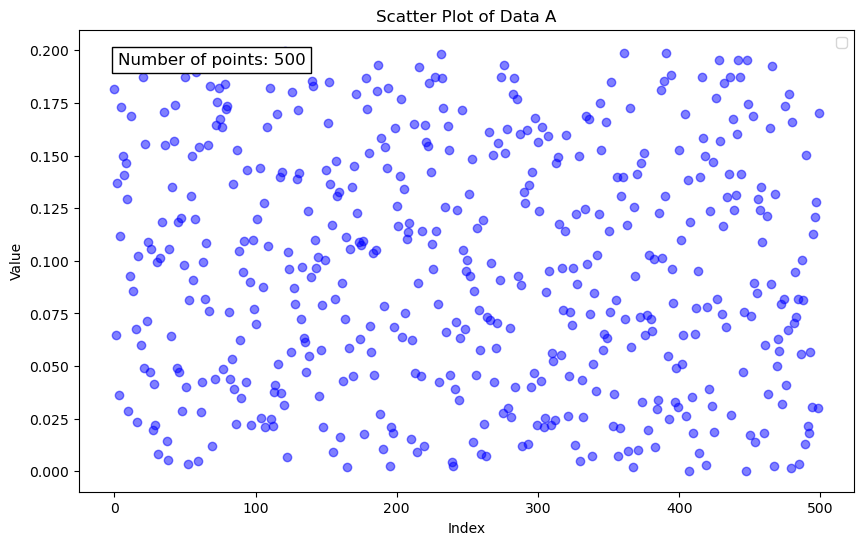

In [9]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(500, 1)


In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.05333619076148692, 0.05336021341591813, 0.0532822096170948, 0.053162259187180004, 0.05329504720839433, 0.05329098387001404, 0.05334586575589519, 0.05363439729404418, 0.05332608220095483, 0.053361667228406746]
Error u of fuhe active learning(LHS sampling): 5.333949e-02
[0.0045480064524361895, 0.004543534320273878, 0.004537833752616487, 0.004524304043344519, 0.004537420485802141, 0.004536102778394492, 0.004541301620281989, 0.004937456855751236, 0.004543185744718296, 0.004544337206471896]
MAE of fuhe active learning(LHS sampling): 4.579348e-03
[0.0003474903974658632, 0.00034780290307126667, 0.00034678757532350264, 0.000345228819686005, 0.00034695466576245587, 0.00034690202586077626, 0.00034761624368192124, 0.00035142548382537564, 0.00034735831873662745, 0.00034782154702849325]
MSE of fuhe active learning(LHS sampling): 3.475388e-04
[4.187219e-05, 3.3621436e-05, 4.0340034e-05, 0.00014331724, 3.7062055e-05, 4.7074303e-05, 4.0472438e-05, 9.955118e-05, 0.00010885397, 9.3058654e-05]
Chaos o

/tmp/ipykernel_1429684/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.05333619076148692, 0.05336021341591813, 0.0532822096170948, 0.053162259187180004, 0.05329504720839433, 0.05329098387001404, 0.05334586575589519, 0.05363439729404418, 0.05332608220095483, 0.053361667228406746]
mean Error u: 5.333949e-02
Variance Error u: 1.271427e-08


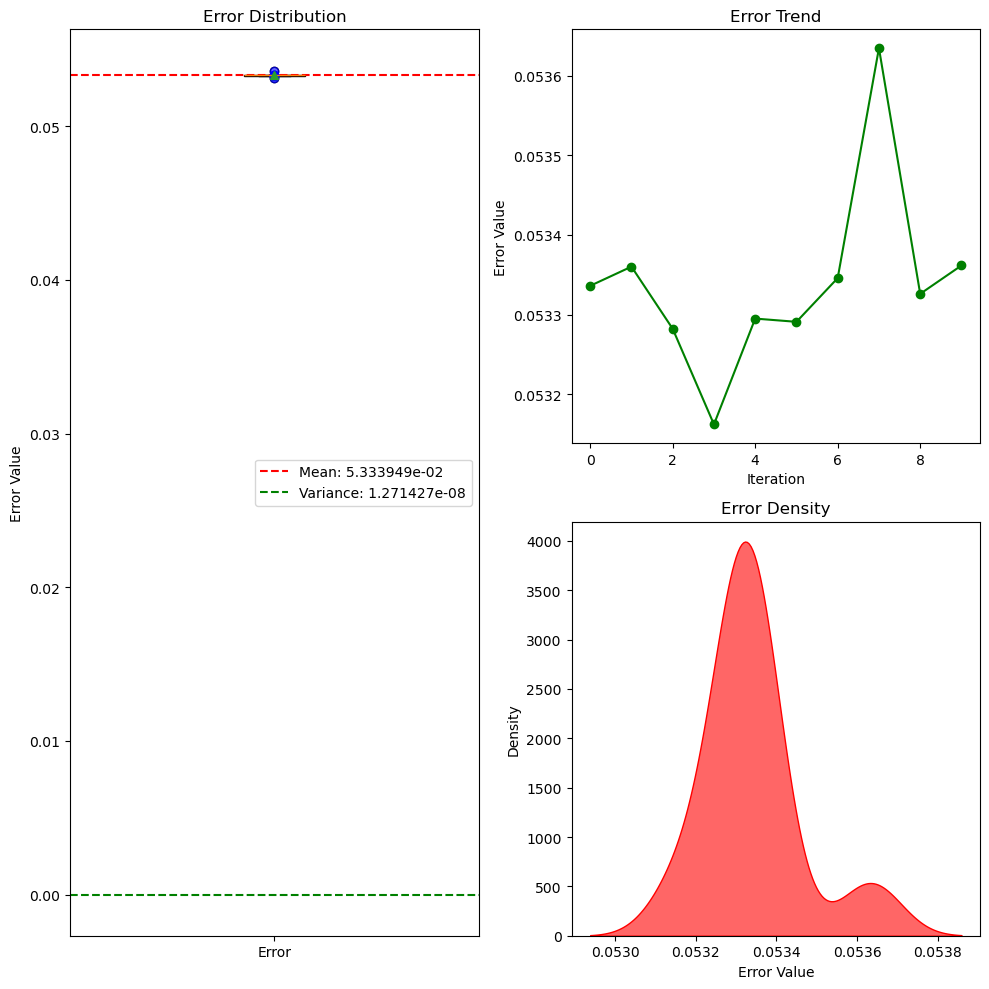

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0045480064524361895, 0.004543534320273878, 0.004537833752616487, 0.004524304043344519, 0.004537420485802141, 0.004536102778394492, 0.004541301620281989, 0.004937456855751236, 0.004543185744718296, 0.004544337206471896]
mean MAE: 4.579348e-03
Variance MAE: 1.428692e-08


/tmp/ipykernel_1429684/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


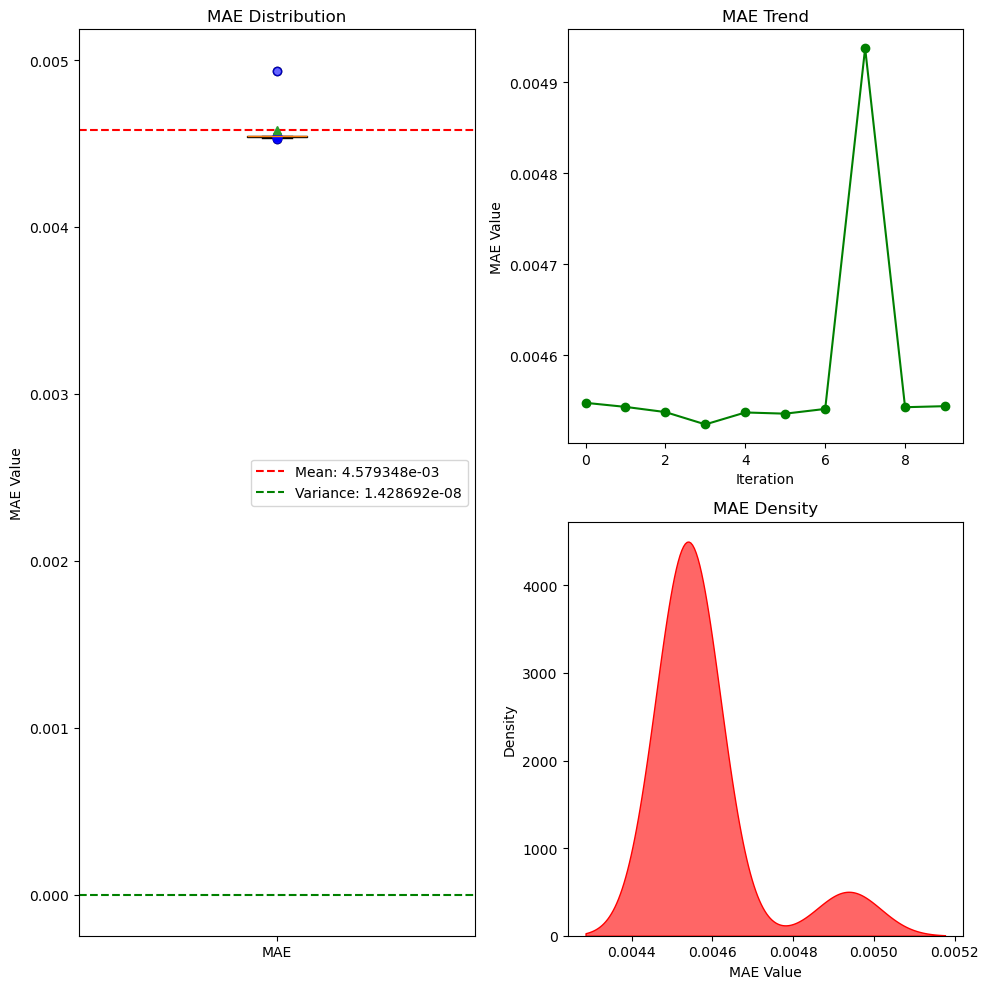

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0003474903974658632, 0.00034780290307126667, 0.00034678757532350264, 0.000345228819686005, 0.00034695466576245587, 0.00034690202586077626, 0.00034761624368192124, 0.00035142548382537564, 0.00034735831873662745, 0.00034782154702849325]
mean MSE: 3.475388e-04
Variance MSE: 2.194396e-12


/tmp/ipykernel_1429684/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.187219e-05, 3.3621436e-05, 4.0340034e-05, 0.00014331724, 3.7062055e-05, 4.7074303e-05, 4.0472438e-05, 9.955118e-05, 0.00010885397, 9.3058654e-05]
mean CHAOS: 6.852235e-05
Variance CHAOS: 1.374485e-09


/tmp/ipykernel_1429684/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.0003258201, 0.00034218968, 0.00034217958, 0.0003216953, 0.00033424702, 0.00032015465, 0.00032836106, 0.0003314031, 0.0003561562, 0.00032962527]
mean RESIDUAL: 3.331832e-04
Variance RESIDUAL: 1.085954e-10


/tmp/ipykernel_1429684/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


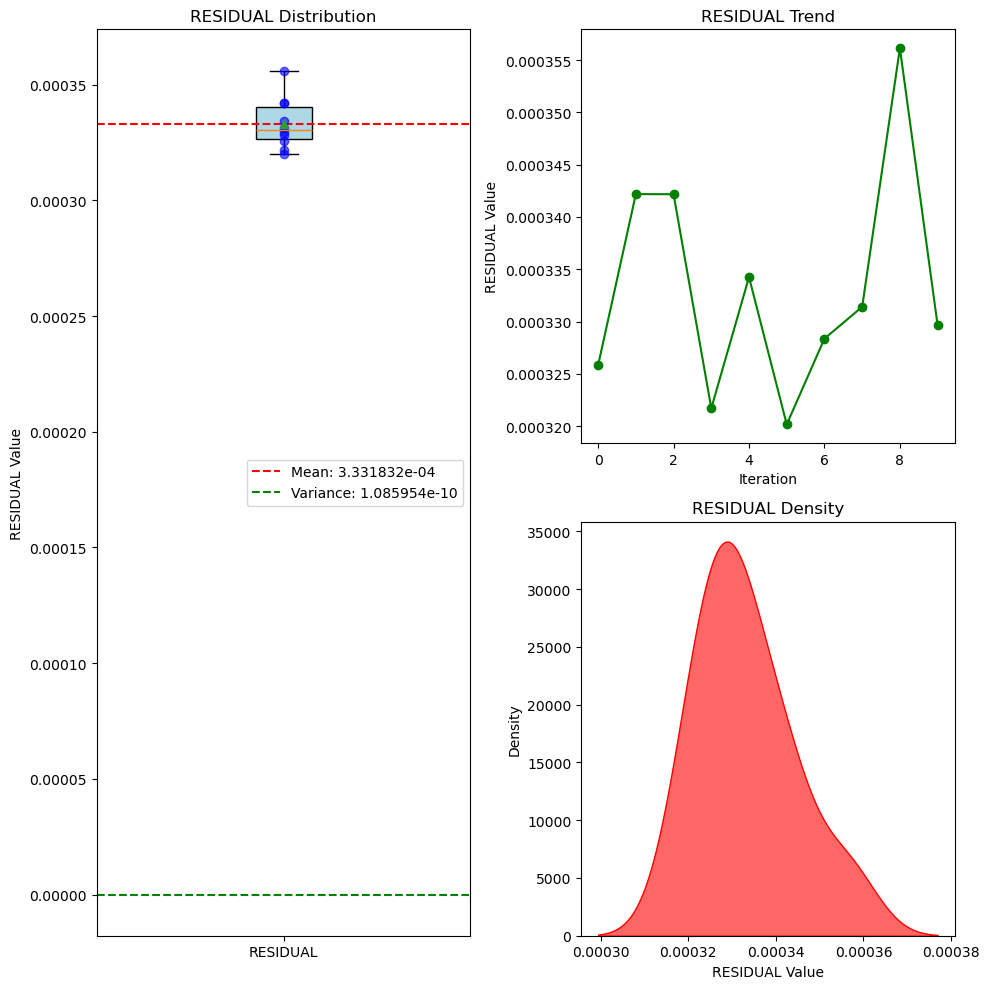

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

40000
[1.7974403e+03 1.7133282e+03 1.6436174e+03 ... 6.2711588e-03 6.2711593e-03
 6.2711518e-03]


In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.758110  0.053041  0.094590  0.068874  0.006606  0.004812  0.008583   
1  0.758104  0.053041  0.094593  0.068875  0.006606  0.004812  0.008583   
2  0.758099  0.053041  0.094597  0.068875  0.006607  0.004812  0.008584   
3  0.758094  0.053041  0.094600  0.068875  0.006607  0.004812  0.008584   
4  0.758089  0.053041  0.094603  0.068875  0.006608  0.004812  0.008585   

    state_8   state_9  state_10  state_11  state_12  
0  0.004001  0.000593  0.000273  0.000489  0.000029  
1  0.004001  0.000593  0.000273  0.000489  0.000029  
2  0.004001  0.000593  0.000273  0.000489  0.000029  
3  0.004002  0.000593  0.000273  0.000489  0.000029  
4  0.004002  0.000593  0.000273  0.000489  0.000029  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757817  0.053036  0.094715  0.068885  0.006636  0.004824  0.008621   
496  0.757814  0.053036  0.094715  0.068885  0.006637  0.004825  0.0086

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

Text(0, 0.5, 'Probability')

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.0017391077351424657
RMSE of between PINN without PCGrad and the analytical solution is 0.0017391077351424523


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.013148022337852084
RMSE of between PINN without PCGrad and the analytical solution is 0.013148022337851391
